In [ ]:
!pip install --upgrade ultralytics==8.0.186
!pip install torch torchvision torchaudio
!pip install opencv-python-headless
!pip install albumentations==1.4

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 618.4/618.4 kB 26.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.6/123.6 kB 11.1 MB/s eta 0:00:00
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.4.20
    Uninstalling albumentations-1.4.20:
      Successfully uninstalled albumentations-1.4.20


In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from ultralytics import YOLO
import numpy as np
from google.colab import drive
import os
import albumentations
import cv2
import torch.nn.functional as F
import matplotlib.pyplot as plt

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dataset_yolo = '/content/drive/My Drive/2024 Fall/COMS 6730/Projects/Senior-Design-VIAD'
epoch_number = 50
weights_path = '/content/drive/My Drive/2024 Fall/COMS 6730/Projects/YoloV8/yolov8n.pt'
data_yaml_path = '/content/drive/My Drive/2024 Fall/COMS 6730/Projects/Senior-Design-VIAD/data.yaml'
saved_path = f'trained_model'
results_folder_name = f"{dataset_yolo}_normal"

# model = YOLO(weights_path)
# model.train(
#     data=data_yaml_path,
#     epochs=epoch_number,
#     batch=40,
#     device='cuda',
#     project=saved_path,
#     name=results_folder_name,
#     patience=epoch_number,
#     pretrained=True,
#     lr0=0.01,
#     lrf=0.001,
#     dropout=0.2
# )

In [ ]:
data_yaml_path = '/content/drive/My Drive/2024 Fall/COMS 6730/Projects/Senior-Design-VIAD/data.yaml'
with open(data_yaml_path, 'r') as f:
    print(f.read())  # 检查文件内容

test: /content/drive/My Drive/2024 Fall/COMS 6730/Projects/Senior-Design-VIAD/test/images
train: /content/drive/My Drive/2024 Fall/COMS 6730/Projects/Senior-Design-VIAD/train/images
val: /content/drive/My Drive/2024 Fall/COMS 6730/Projects/Senior-Design-VIAD/valid/images

nc: 26
names: ['bench', 'bicycle', 'branch', 'bus', 'bushes', 'car', 'crosswalk', 'door', 'elevator', 'fire_hydrant', 'green_light', 'gun', 'motorcycle', 'person', 'pothole', 'rat', 'red_light', 'scooter', 'stairs', 'stop_sign', 'traffic_cone', 'train', 'tree', 'truck', 'umbrella', 'yellow_light']

roboflow:
  workspace: viad-optics-senior-design
  project: senior-design-viad
  version: 5
  license: CC BY 4.0
#   url: https://universe.roboflow.com/viad-optics-senior-design/senior-design-viad/dataset/5


In [ ]:
# transform = transforms.Compose([
#     transforms.Resize((img_size, img_size)),
#     transforms.ToTensor(),
# ])

In [ ]:
class CustomLoss(nn.Module):
    def __init__(self, alpha=0.8, beta=0.5, gamma=0.7):
        super(CustomLoss, self).__init__()
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.epsilon = 1e-6

    def forward(self, outputs, targets):
        # 获取模型输出所在的设备
        device = outputs[0].boxes.conf.device

        # 提取 boxes 属性并移动到相同设备
        boxes = outputs[0].boxes

        # 将 conf 和 cls 张量移至正确设备
        person_conf = boxes.conf.to(device)  # 置信度分数
        person_cls = (boxes.cls == targets['person_class_index']).float().to(device)  # 类别是人物的概率

        # 将 targets 张量移至正确设备
        person_mask = targets['person_mask'].float().to(device)  # 人物区域的掩码
        background_mask = (1.0 - person_mask).to(device)         # 背景区域的掩码

        # 背景区域的误检损失
        L_bg = -torch.sum(
            (torch.log(person_cls + self.epsilon) + torch.log(person_conf + self.epsilon)) * background_mask
        ) / (torch.sum(background_mask) + self.epsilon).to(device)

        # 现有人物区域的抑制损失
        L_person = torch.sum(
            (torch.log(1.0 - person_cls + self.epsilon) + torch.log(1.0 - person_conf + self.epsilon)) * person_mask
        ) / (torch.sum(person_mask) + self.epsilon).to(device)

        # 边界框数量增加损失
        L_bbox = -torch.mean(torch.log(person_conf + self.epsilon)).to(device)

        # 总损失
        loss = self.alpha * L_bg + self.beta * L_person + self.gamma * L_bbox

        return loss

In [ ]:
model_path = f"{results_folder_name}/weights/last.pt"
model = YOLO(model_path)
# model.eval()

/usr/local/lib/python3.10/dist-packages/ultralytics/nn/tasks.py:527: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(file, map_location='cpu'), file  # load


In [ ]:
with torch.no_grad():
    # 禁用参数的更新
    for param in model.parameters():
        param.requires_grad = False


In [143]:
def pgd_attack(model, images, epsilon, alpha, num_iter, target_class=13, lambda1=1.0, lambda2=1.0):
    """
    改进的 PGD 攻击，增强对抗效果。
    参数:
        model: 加载的目标检测模型
        images: 输入图像 (tensor)，形状为 [B, C, H, W]
        epsilon: 扰动范围
        alpha: 每步的扰动步长
        num_iter: 迭代次数
        target_class: 目标类别索引 (int)
        lambda1: 平衡 target_conf 优化的权重
        lambda2: 平衡 other_conf 抑制的权重
    返回:
        images_adv: 生成的对抗样本
    """
    # 克隆输入图像，确保不修改原始图像，并设置需要计算梯度
    images_adv = images.clone().detach().requires_grad_(True)

    # 启用梯度计算
    with torch.enable_grad():
        for i in range(num_iter):
            images_adv.retain_grad()
            outputs = model(images_adv)

            # 检查是否有检测框
            if outputs[0].boxes is None:
                # print(f"Iteration {i+1}: No objects detected, skipping.")
                continue

            # 获取类别索引和置信度
            classes = outputs[0].boxes.cls  # 每个检测框的类别索引
            confidences = outputs[0].boxes.conf  # 每个检测框的置信度

            # 获取目标类别和其他类别的置信度
            target_conf = confidences[classes == target_class]
            other_conf = confidences[classes != target_class]

            if len(target_conf) == 0 and len(other_conf) == 0:
                # print(f"Iteration {i+1}: No objects detected, skipping.")
                continue

            # 定义损失函数
            mean_pixel_loss = images_adv.mean()  # 利用像素均值获得梯度
            confidence_loss = -lambda1 * torch.mean(target_conf) if len(target_conf) > 0 else 0
            suppression_loss = lambda2 * torch.mean(1 - other_conf) if len(other_conf) > 0 else 0
            loss = mean_pixel_loss + confidence_loss + suppression_loss

            # 打印损失值（可选）
            # print(f"Iteration {i+1}/{num_iter}, Loss: {loss.item()}")

            # 反向传播以计算梯度
            loss.backward(retain_graph=True)

            if images_adv.grad is None:
                # print("images_adv.grad is None after backward")
                break

            # 获取梯度的符号
            grad_sign = images_adv.grad.sign()

            # 更新对抗样本
            images_adv = images_adv - alpha * grad_sign

            # 限制扰动范围并确保像素值在 [0, 1] 之间
            eta = torch.clamp(images_adv - images, min=-epsilon, max=epsilon)
            images_adv = torch.clamp(images + eta, min=0, max=3).detach()

            # 重新启用梯度以继续迭代
            images_adv.requires_grad_(True)

    return images_adv

In [ ]:
class_range = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25]

In [ ]:
import random

def draw_boxes(image, outputs, class_names=None, color=(0, 255, 0)):
    """
    在图像上绘制检测框。

    参数：
        image: 原始图像（numpy 数组）
        outputs: YOLO 模型的输出
        class_names: 类别名称列表，例如 ['Person', 'Car', ...]
        color: 框的颜色（BGR 格式）
    返回：
        带有检测框的图像
    """
    # 复制图像，避免直接修改原图
    image_with_boxes = image.copy()

    # 获取检测框信息
    boxes = outputs[0].boxes  # 这是 YOLO 输出的检测框对象

    if boxes is None:
        print("No objects detected.")
        return image_with_boxes

    # 遍历所有检测框
    for box in boxes:
        # 提取框的坐标和置信度
        x1, y1, x2, y2 = map(int, box.xyxy[0].tolist())  # 转换为整数
        conf = float(box.conf[0])  # 置信度分数
        cls = int(box.cls[0])  # 类别索引

        if int(cls)==13:
          color=(0, 255, 0)
        else:
          color = (int(cls)*10, int(cls)*10, int(cls)*10)

        if class_names and cls < len(class_names):
            label = f"{class_names[cls]}: {conf:.2f}"
        else:
            label = f"Class {cls}: {conf:.2f}"  # 如果超出范围，直接使用类别索引

        # 绘制矩形框
        cv2.rectangle(image_with_boxes, (x1, y1), (x2, y2), color, 2)
        print(f"{conf:.2f}")
        # 显示类别和置信度
        label = f"{class_names[cls] if class_names else cls}: {conf:.2f}"
        cv2.putText(image_with_boxes, label, (x1 + 10, y1 + 15), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    return image_with_boxes

In [ ]:
def preprocess_image(image, size=(640, 640)):
    """
    预处理图像，将图像调整为模型输入尺寸，并归一化到 [0, 1]。
    参数:
        image: 原始图像 (numpy 数组)
        size: 调整后的尺寸 (宽, 高)
    返回:
        PyTorch 张量，形状为 [1, 3, H, W]
    """
    # 调整图像大小
    image_resized = cv2.resize(image, size)

    # 转换为 [C, H, W] 格式，并归一化到 [0, 1]
    image_tensor = torch.tensor(image_resized, dtype=torch.float32).permute(2, 0, 1) / 255.0

    # 增加 batch 维度 [B, C, H, W]
    return image_tensor.unsqueeze(0)

In [111]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
epsilon = 0.1  # 最大扰动
alpha = 0.1   # 每次迭代的步长
num_iter = 100   # 迭代次数
# 生成检测框图像
# image_path = '/content/drive/My Drive/2024 Fall/COMS 6730/Projects/Senior-Design-VIAD/train/images/2bfc68c9de334fdfac0c7514e98068f5246d4f8e_jpg.rf.577a69123c2218c40378ffd7781d3c68.jpg'
# image_path = '/content/drive/My Drive/2024 Fall/COMS 6730/Projects/Person-Detection-YOLOV8N-Dectection/test/images/50_png.rf.8c631fbfe884e8a35e7a9592242389f1.jpg'
# image = cv2.imread(image_path)
# image_tensor = preprocess_image(image, size=(640, 640))

# # image_tensor = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0) / 255.0
# # image_tensor = image_tensor.to(device)  # 将 Tensor 移动到 GPU（如果可用）

# # 传入模型
# # outputs = model(image_tensor)

# outputs = model.predict(image_tensor)

# # 将图像和标签转换为 Tensor
# images = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0).to(device) / 255.0
# labels = torch.tensor([0]).to(device)

# # 生成对抗样本
# print("Generating adversarial examples...")
# images_adv = pgd_attack(model, images, epsilon, alpha, num_iter)

# # 使用对抗样本进行预测
# outputs_adv = model(images_adv)

In [112]:
image_path = '/content/drive/My Drive/2024 Fall/COMS 6730/Projects/Person-Detection-YOLOV8N-Dectection/test/images/50_png.rf.8c631fbfe884e8a35e7a9592242389f1.jpg'
image = cv2.imread(image_path)

image_tensor = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0) / 255.0
image_tensor = image_tensor.to(device)  # 将 Tensor 移动到 GPU（如果可用）

# 传入模型
# outputs = model(image_tensor)

outputs = model.predict(image_tensor)

# 将图像和标签转换为 Tensor
images = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0).to(device) / 255.0
labels = torch.tensor([0]).to(device)

# 生成对抗样本
print("Generating adversarial examples...")
images_adv = pgd_attack(model, images, epsilon, alpha, num_iter)

# 使用对抗样本进行预测
outputs_adv = model(images_adv)


0: 640x640 1 person, 1 scooter, 7.6ms
Speed: 0.0ms preprocess, 7.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 1 scooter, 7.5ms
Speed: 0.0ms preprocess, 7.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 car, 1 scooter, 9.4ms
Speed: 0.0ms preprocess, 9.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 car, 1 scooter, 9.4ms
Speed: 0.0ms preprocess, 9.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 car, 1 scooter, 9.4ms
Speed: 0.0ms preprocess, 9.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 car, 1 scooter, 9.4ms
Speed: 0.0ms preprocess, 9.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 car, 1 scooter, 9.4ms
Speed: 0.0ms preprocess, 9.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 car, 1 scooter, 9.4ms
Speed: 0.0ms preprocess, 9.4ms inf

Generating adversarial examples...
Iteration 1/100, Loss: 0.8801246881484985
Iteration 2/100, Loss: 1.0252540111541748
Iteration 3/100, Loss: 1.0252540111541748
Iteration 4/100, Loss: 1.0252540111541748
Iteration 5/100, Loss: 1.0252540111541748
Iteration 6/100, Loss: 1.0252540111541748
Iteration 7/100, Loss: 1.0252540111541748
Iteration 8/100, Loss: 1.0252540111541748
Iteration 9/100, Loss: 1.0252540111541748
Iteration 10/100, Loss: 1.0252540111541748
Iteration 11/100, Loss: 1.0252540111541748


0: 640x640 1 car, 1 scooter, 8.3ms
Speed: 0.0ms preprocess, 8.3ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 car, 1 scooter, 8.4ms
Speed: 0.0ms preprocess, 8.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 car, 1 scooter, 8.7ms
Speed: 0.0ms preprocess, 8.7ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 car, 1 scooter, 8.3ms
Speed: 0.0ms preprocess, 8.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 car, 1 scooter, 8.3ms
Speed: 0.0ms preprocess, 8.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 car, 1 scooter, 8.4ms
Speed: 0.0ms preprocess, 8.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 car, 1 scooter, 8.4ms
Speed: 0.0ms preprocess, 8.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 car, 1 scooter, 8.3ms
Speed: 0.0ms preprocess, 8.3ms inference,

Iteration 12/100, Loss: 1.0252540111541748
Iteration 13/100, Loss: 1.0252540111541748
Iteration 14/100, Loss: 1.0252540111541748
Iteration 15/100, Loss: 1.0252540111541748
Iteration 16/100, Loss: 1.0252540111541748
Iteration 17/100, Loss: 1.0252540111541748
Iteration 18/100, Loss: 1.0252540111541748
Iteration 19/100, Loss: 1.0252540111541748
Iteration 20/100, Loss: 1.0252540111541748
Iteration 21/100, Loss: 1.0252540111541748
Iteration 22/100, Loss: 1.0252540111541748
Iteration 23/100, Loss: 1.0252540111541748



0: 640x640 1 car, 1 scooter, 8.9ms
Speed: 0.0ms preprocess, 8.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 car, 1 scooter, 8.2ms
Speed: 0.0ms preprocess, 8.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 car, 1 scooter, 8.3ms
Speed: 0.0ms preprocess, 8.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 car, 1 scooter, 8.3ms
Speed: 0.0ms preprocess, 8.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 car, 1 scooter, 8.7ms
Speed: 0.0ms preprocess, 8.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 car, 1 scooter, 8.9ms
Speed: 0.0ms preprocess, 8.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 car, 1 scooter, 9.7ms
Speed: 0.0ms preprocess, 9.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 car, 1 scooter, 10.1ms
Speed: 0.0ms preprocess, 10.1ms inferen

Iteration 24/100, Loss: 1.0252540111541748
Iteration 25/100, Loss: 1.0252540111541748
Iteration 26/100, Loss: 1.0252540111541748
Iteration 27/100, Loss: 1.0252540111541748
Iteration 28/100, Loss: 1.0252540111541748
Iteration 29/100, Loss: 1.0252540111541748
Iteration 30/100, Loss: 1.0252540111541748
Iteration 31/100, Loss: 1.0252540111541748
Iteration 32/100, Loss: 1.0252540111541748
Iteration 33/100, Loss: 1.0252540111541748
Iteration 34/100, Loss: 1.0252540111541748
Iteration 35/100, Loss: 1.0252540111541748


0: 640x640 1 car, 1 scooter, 10.3ms
Speed: 0.0ms preprocess, 10.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 car, 1 scooter, 8.4ms
Speed: 0.0ms preprocess, 8.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 car, 1 scooter, 8.5ms
Speed: 0.0ms preprocess, 8.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 car, 1 scooter, 10.9ms
Speed: 0.0ms preprocess, 10.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 car, 1 scooter, 9.2ms
Speed: 0.0ms preprocess, 9.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 car, 1 scooter, 8.3ms
Speed: 0.0ms preprocess, 8.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 car, 1 scooter, 9.5ms
Speed: 0.0ms preprocess, 9.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 car, 1 scooter, 9.4ms
Speed: 0.0ms preprocess, 9.4ms infere

Iteration 36/100, Loss: 1.0252540111541748
Iteration 37/100, Loss: 1.0252540111541748
Iteration 38/100, Loss: 1.0252540111541748
Iteration 39/100, Loss: 1.0252540111541748
Iteration 40/100, Loss: 1.0252540111541748
Iteration 41/100, Loss: 1.0252540111541748
Iteration 42/100, Loss: 1.0252540111541748
Iteration 43/100, Loss: 1.0252540111541748
Iteration 44/100, Loss: 1.0252540111541748
Iteration 45/100, Loss: 1.0252540111541748
Iteration 46/100, Loss: 1.0252540111541748
Iteration 47/100, Loss: 1.0252540111541748


0: 640x640 1 car, 1 scooter, 10.3ms
Speed: 0.0ms preprocess, 10.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 car, 1 scooter, 10.0ms
Speed: 0.0ms preprocess, 10.0ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 car, 1 scooter, 8.0ms
Speed: 0.0ms preprocess, 8.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 car, 1 scooter, 8.6ms
Speed: 0.0ms preprocess, 8.6ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 car, 1 scooter, 8.4ms
Speed: 0.0ms preprocess, 8.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 car, 1 scooter, 8.4ms
Speed: 0.0ms preprocess, 8.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 car, 1 scooter, 8.1ms
Speed: 0.0ms preprocess, 8.1ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 car, 1 scooter, 8.1ms
Speed: 0.0ms preprocess, 8.1ms infere

Iteration 48/100, Loss: 1.0252540111541748
Iteration 49/100, Loss: 1.0252540111541748
Iteration 50/100, Loss: 1.0252540111541748
Iteration 51/100, Loss: 1.0252540111541748
Iteration 52/100, Loss: 1.0252540111541748
Iteration 53/100, Loss: 1.0252540111541748
Iteration 54/100, Loss: 1.0252540111541748
Iteration 55/100, Loss: 1.0252540111541748
Iteration 56/100, Loss: 1.0252540111541748
Iteration 57/100, Loss: 1.0252540111541748
Iteration 58/100, Loss: 1.0252540111541748
Iteration 59/100, Loss: 1.0252540111541748


0: 640x640 1 car, 1 scooter, 9.3ms
Speed: 0.1ms preprocess, 9.3ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 car, 1 scooter, 8.5ms
Speed: 0.0ms preprocess, 8.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 car, 1 scooter, 9.9ms
Speed: 0.0ms preprocess, 9.9ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 car, 1 scooter, 8.9ms
Speed: 0.0ms preprocess, 8.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 car, 1 scooter, 8.7ms
Speed: 0.0ms preprocess, 8.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 car, 1 scooter, 9.8ms
Speed: 0.0ms preprocess, 9.8ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 car, 1 scooter, 10.1ms
Speed: 0.0ms preprocess, 10.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 car, 1 scooter, 8.4ms
Speed: 0.0ms preprocess, 8.4ms inferenc

Iteration 60/100, Loss: 1.0252540111541748
Iteration 61/100, Loss: 1.0252540111541748
Iteration 62/100, Loss: 1.0252540111541748
Iteration 63/100, Loss: 1.0252540111541748
Iteration 64/100, Loss: 1.0252540111541748
Iteration 65/100, Loss: 1.0252540111541748
Iteration 66/100, Loss: 1.0252540111541748
Iteration 67/100, Loss: 1.0252540111541748
Iteration 68/100, Loss: 1.0252540111541748
Iteration 69/100, Loss: 1.0252540111541748
Iteration 70/100, Loss: 1.0252540111541748


Speed: 0.0ms preprocess, 8.5ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 car, 1 scooter, 9.5ms
Speed: 0.1ms preprocess, 9.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 car, 1 scooter, 10.1ms
Speed: 0.0ms preprocess, 10.1ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 car, 1 scooter, 9.3ms
Speed: 0.0ms preprocess, 9.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 car, 1 scooter, 9.4ms
Speed: 0.0ms preprocess, 9.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 car, 1 scooter, 10.5ms
Speed: 0.0ms preprocess, 10.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 car, 1 scooter, 9.0ms
Speed: 0.0ms preprocess, 9.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 car, 1 scooter, 9.4ms
Speed: 0.0ms preprocess, 9.4ms inference, 2.2ms postprocess per image at

Iteration 71/100, Loss: 1.0252540111541748
Iteration 72/100, Loss: 1.0252540111541748
Iteration 73/100, Loss: 1.0252540111541748
Iteration 74/100, Loss: 1.0252540111541748
Iteration 75/100, Loss: 1.0252540111541748
Iteration 76/100, Loss: 1.0252540111541748
Iteration 77/100, Loss: 1.0252540111541748
Iteration 78/100, Loss: 1.0252540111541748
Iteration 79/100, Loss: 1.0252540111541748
Iteration 80/100, Loss: 1.0252540111541748
Iteration 81/100, Loss: 1.0252540111541748
Iteration 82/100, Loss: 1.0252540111541748



0: 640x640 1 car, 1 scooter, 8.6ms
Speed: 0.0ms preprocess, 8.6ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 car, 1 scooter, 8.2ms
Speed: 0.0ms preprocess, 8.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 car, 1 scooter, 8.6ms
Speed: 0.0ms preprocess, 8.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 car, 1 scooter, 9.0ms
Speed: 0.0ms preprocess, 9.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 car, 1 scooter, 8.5ms
Speed: 0.0ms preprocess, 8.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 car, 1 scooter, 9.0ms
Speed: 0.0ms preprocess, 9.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 car, 1 scooter, 9.3ms
Speed: 0.0ms preprocess, 9.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 car, 1 scooter, 8.2ms
Speed: 0.0ms preprocess, 8.2ms inference

Iteration 83/100, Loss: 1.0252540111541748
Iteration 84/100, Loss: 1.0252540111541748
Iteration 85/100, Loss: 1.0252540111541748
Iteration 86/100, Loss: 1.0252540111541748
Iteration 87/100, Loss: 1.0252540111541748
Iteration 88/100, Loss: 1.0252540111541748
Iteration 89/100, Loss: 1.0252540111541748
Iteration 90/100, Loss: 1.0252540111541748
Iteration 91/100, Loss: 1.0252540111541748
Iteration 92/100, Loss: 1.0252540111541748
Iteration 93/100, Loss: 1.0252540111541748
Iteration 94/100, Loss: 1.0252540111541748


0: 640x640 1 car, 1 scooter, 8.3ms
Speed: 0.0ms preprocess, 8.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 car, 1 scooter, 8.5ms
Speed: 0.0ms preprocess, 8.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 car, 1 scooter, 9.7ms
Speed: 0.0ms preprocess, 9.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 car, 1 scooter, 8.3ms
Speed: 0.0ms preprocess, 8.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 car, 1 scooter, 8.4ms
Speed: 0.0ms preprocess, 8.4ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 car, 1 scooter, 8.0ms
Speed: 0.0ms preprocess, 8.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 car, 1 scooter, 10.5ms
Speed: 0.0ms preprocess, 10.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


Iteration 95/100, Loss: 1.0252540111541748
Iteration 96/100, Loss: 1.0252540111541748
Iteration 97/100, Loss: 1.0252540111541748
Iteration 98/100, Loss: 1.0252540111541748
Iteration 99/100, Loss: 1.0252540111541748
Iteration 100/100, Loss: 1.0252540111541748


0.33
0.27


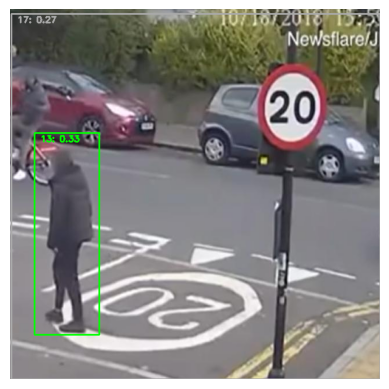

0.39
0.32


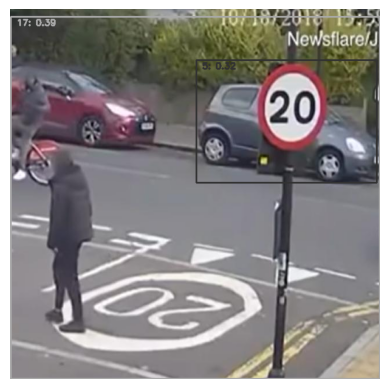

In [113]:
# 生成检测框图像
image_with_boxes = draw_boxes(image, outputs, class_range)

# 显示图像
plt.imshow(cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

image_with_boxes = draw_boxes(image, outputs_adv, class_range)

plt.imshow(cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

In [114]:
image_path = '/content/drive/My Drive/2024 Fall/COMS 6730/Projects/Person-Detection-YOLOV8N-Dectection/test/images/541_png.rf.ec9614119dfe10f5fb1cda98f657b47e.jpg'
image = cv2.imread(image_path)

outputs = model(image)

# 将图像和标签转换为 Tensor
images = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0).to(device) / 255.0
labels = torch.tensor([0]).to(device)

# 生成对抗样本
print("Generating adversarial examples...")
images_adv = pgd_attack(model, images, epsilon, alpha, num_iter)

# 使用对抗样本进行预测
outputs_adv = model(images_adv)


0: 640x640 (no detections), 7.5ms
Speed: 2.0ms preprocess, 7.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 door, 1 yellow_light, 7.5ms
Speed: 0.0ms preprocess, 7.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 door, 9.3ms
Speed: 0.0ms preprocess, 9.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 door, 9.3ms
Speed: 0.0ms preprocess, 9.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 door, 9.3ms
Speed: 0.0ms preprocess, 9.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 door, 9.3ms
Speed: 0.0ms preprocess, 9.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 door, 9.4ms
Speed: 0.0ms preprocess, 9.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 door, 9.4ms
Speed: 0.0ms preprocess, 9.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

Generating adversarial examples...
Iteration 1/100, Loss: 1.1284255981445312
Iteration 2/100, Loss: 1.1769086122512817
Iteration 3/100, Loss: 1.1769086122512817
Iteration 4/100, Loss: 1.1769086122512817
Iteration 5/100, Loss: 1.1769086122512817
Iteration 6/100, Loss: 1.1769086122512817
Iteration 7/100, Loss: 1.1769086122512817
Iteration 8/100, Loss: 1.1769086122512817
Iteration 9/100, Loss: 1.1769086122512817
Iteration 10/100, Loss: 1.1769086122512817
Iteration 11/100, Loss: 1.1769086122512817


Speed: 0.0ms preprocess, 9.3ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 door, 9.4ms
Speed: 0.0ms preprocess, 9.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 door, 9.3ms
Speed: 0.0ms preprocess, 9.3ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 door, 9.3ms
Speed: 0.0ms preprocess, 9.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 door, 8.3ms
Speed: 0.0ms preprocess, 8.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 door, 11.2ms
Speed: 0.0ms preprocess, 11.2ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 door, 8.3ms
Speed: 0.0ms preprocess, 8.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 door, 7.9ms
Speed: 0.0ms preprocess, 7.9ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 door, 8.1ms
Speed: 0.0ms preproces

Iteration 12/100, Loss: 1.1769086122512817
Iteration 13/100, Loss: 1.1769086122512817
Iteration 14/100, Loss: 1.1769086122512817
Iteration 15/100, Loss: 1.1769086122512817
Iteration 16/100, Loss: 1.1769086122512817
Iteration 17/100, Loss: 1.1769086122512817
Iteration 18/100, Loss: 1.1769086122512817
Iteration 19/100, Loss: 1.1769086122512817
Iteration 20/100, Loss: 1.1769086122512817
Iteration 21/100, Loss: 1.1769086122512817
Iteration 22/100, Loss: 1.1769086122512817
Iteration 23/100, Loss: 1.1769086122512817
Iteration 24/100, Loss: 1.1769086122512817


0: 640x640 1 door, 8.1ms
Speed: 0.0ms preprocess, 8.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 door, 8.4ms
Speed: 0.0ms preprocess, 8.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 door, 8.5ms
Speed: 0.0ms preprocess, 8.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 door, 8.5ms
Speed: 0.0ms preprocess, 8.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 door, 8.6ms
Speed: 0.0ms preprocess, 8.6ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 door, 8.5ms
Speed: 0.0ms preprocess, 8.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 door, 8.0ms
Speed: 0.0ms preprocess, 8.0ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 door, 8.5ms
Speed: 0.0ms preprocess, 8.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 door, 8.4ms

Iteration 25/100, Loss: 1.1769086122512817
Iteration 26/100, Loss: 1.1769086122512817
Iteration 27/100, Loss: 1.1769086122512817
Iteration 28/100, Loss: 1.1769086122512817
Iteration 29/100, Loss: 1.1769086122512817
Iteration 30/100, Loss: 1.1769086122512817
Iteration 31/100, Loss: 1.1769086122512817
Iteration 32/100, Loss: 1.1769086122512817
Iteration 33/100, Loss: 1.1769086122512817
Iteration 34/100, Loss: 1.1769086122512817
Iteration 35/100, Loss: 1.1769086122512817
Iteration 36/100, Loss: 1.1769086122512817
Iteration 37/100, Loss: 1.1769086122512817


0: 640x640 1 door, 8.8ms
Speed: 0.0ms preprocess, 8.8ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 door, 8.3ms
Speed: 0.0ms preprocess, 8.3ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 door, 9.2ms
Speed: 0.0ms preprocess, 9.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 door, 7.9ms
Speed: 0.0ms preprocess, 7.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 door, 9.0ms
Speed: 0.0ms preprocess, 9.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 door, 9.0ms
Speed: 0.0ms preprocess, 9.0ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 door, 8.4ms
Speed: 0.0ms preprocess, 8.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 door, 8.4ms
Speed: 0.0ms preprocess, 8.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 door, 10.5m

Iteration 38/100, Loss: 1.1769086122512817
Iteration 39/100, Loss: 1.1769086122512817
Iteration 40/100, Loss: 1.1769086122512817
Iteration 41/100, Loss: 1.1769086122512817
Iteration 42/100, Loss: 1.1769086122512817
Iteration 43/100, Loss: 1.1769086122512817
Iteration 44/100, Loss: 1.1769086122512817
Iteration 45/100, Loss: 1.1769086122512817
Iteration 46/100, Loss: 1.1769086122512817
Iteration 47/100, Loss: 1.1769086122512817
Iteration 48/100, Loss: 1.1769086122512817
Iteration 49/100, Loss: 1.1769086122512817
Iteration 50/100, Loss: 1.1769086122512817


0: 640x640 1 door, 9.3ms
Speed: 0.0ms preprocess, 9.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 door, 8.6ms
Speed: 0.0ms preprocess, 8.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 door, 8.8ms
Speed: 0.0ms preprocess, 8.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 door, 8.5ms
Speed: 0.0ms preprocess, 8.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 door, 9.3ms
Speed: 0.0ms preprocess, 9.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 door, 9.0ms
Speed: 0.0ms preprocess, 9.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 door, 8.5ms
Speed: 0.0ms preprocess, 8.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 door, 9.1ms
Speed: 0.0ms preprocess, 9.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 door, 8.4ms

Iteration 51/100, Loss: 1.1769086122512817
Iteration 52/100, Loss: 1.1769086122512817
Iteration 53/100, Loss: 1.1769086122512817
Iteration 54/100, Loss: 1.1769086122512817
Iteration 55/100, Loss: 1.1769086122512817
Iteration 56/100, Loss: 1.1769086122512817
Iteration 57/100, Loss: 1.1769086122512817
Iteration 58/100, Loss: 1.1769086122512817
Iteration 59/100, Loss: 1.1769086122512817
Iteration 60/100, Loss: 1.1769086122512817
Iteration 61/100, Loss: 1.1769086122512817
Iteration 62/100, Loss: 1.1769086122512817


0: 640x640 1 door, 8.7ms
Speed: 0.0ms preprocess, 8.7ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 door, 9.6ms
Speed: 0.0ms preprocess, 9.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 door, 8.2ms
Speed: 0.0ms preprocess, 8.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 door, 10.8ms
Speed: 0.0ms preprocess, 10.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 door, 7.9ms
Speed: 0.0ms preprocess, 7.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 door, 8.2ms
Speed: 0.0ms preprocess, 8.2ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 door, 8.4ms
Speed: 0.0ms preprocess, 8.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 door, 9.4ms
Speed: 0.0ms preprocess, 9.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 door, 9.2

Iteration 63/100, Loss: 1.1769086122512817
Iteration 64/100, Loss: 1.1769086122512817
Iteration 65/100, Loss: 1.1769086122512817
Iteration 66/100, Loss: 1.1769086122512817
Iteration 67/100, Loss: 1.1769086122512817
Iteration 68/100, Loss: 1.1769086122512817
Iteration 69/100, Loss: 1.1769086122512817
Iteration 70/100, Loss: 1.1769086122512817
Iteration 71/100, Loss: 1.1769086122512817
Iteration 72/100, Loss: 1.1769086122512817
Iteration 73/100, Loss: 1.1769086122512817
Iteration 74/100, Loss: 1.1769086122512817



0: 640x640 1 door, 8.0ms
Speed: 0.0ms preprocess, 8.0ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 door, 7.8ms
Speed: 0.0ms preprocess, 7.8ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 door, 10.4ms
Speed: 0.0ms preprocess, 10.4ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 door, 8.1ms
Speed: 0.0ms preprocess, 8.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 door, 8.7ms
Speed: 0.0ms preprocess, 8.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 door, 10.5ms
Speed: 0.0ms preprocess, 10.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 door, 8.9ms
Speed: 0.0ms preprocess, 8.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 door, 10.5ms
Speed: 0.0ms preprocess, 10.5ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 door

Iteration 75/100, Loss: 1.1769086122512817
Iteration 76/100, Loss: 1.1769086122512817
Iteration 77/100, Loss: 1.1769086122512817
Iteration 78/100, Loss: 1.1769086122512817
Iteration 79/100, Loss: 1.1769086122512817
Iteration 80/100, Loss: 1.1769086122512817
Iteration 81/100, Loss: 1.1769086122512817
Iteration 82/100, Loss: 1.1769086122512817
Iteration 83/100, Loss: 1.1769086122512817
Iteration 84/100, Loss: 1.1769086122512817
Iteration 85/100, Loss: 1.1769086122512817
Iteration 86/100, Loss: 1.1769086122512817


0: 640x640 1 door, 9.7ms
Speed: 0.0ms preprocess, 9.7ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 door, 10.5ms
Speed: 0.0ms preprocess, 10.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 door, 8.2ms
Speed: 0.0ms preprocess, 8.2ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 door, 8.2ms
Speed: 0.0ms preprocess, 8.2ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 door, 9.8ms
Speed: 0.0ms preprocess, 9.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 door, 9.2ms
Speed: 0.0ms preprocess, 9.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 door, 9.2ms
Speed: 0.0ms preprocess, 9.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 door, 8.7ms
Speed: 0.0ms preprocess, 8.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 door, 8.5

Iteration 87/100, Loss: 1.1769086122512817
Iteration 88/100, Loss: 1.1769086122512817
Iteration 89/100, Loss: 1.1769086122512817
Iteration 90/100, Loss: 1.1769086122512817
Iteration 91/100, Loss: 1.1769086122512817
Iteration 92/100, Loss: 1.1769086122512817
Iteration 93/100, Loss: 1.1769086122512817
Iteration 94/100, Loss: 1.1769086122512817
Iteration 95/100, Loss: 1.1769086122512817
Iteration 96/100, Loss: 1.1769086122512817
Iteration 97/100, Loss: 1.1769086122512817
Iteration 98/100, Loss: 1.1769086122512817


0: 640x640 1 door, 9.4ms
Speed: 0.0ms preprocess, 9.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 door, 8.9ms
Speed: 0.1ms preprocess, 8.9ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 door, 8.7ms
Speed: 0.0ms preprocess, 8.7ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


Iteration 99/100, Loss: 1.1769086122512817
Iteration 100/100, Loss: 1.1769086122512817


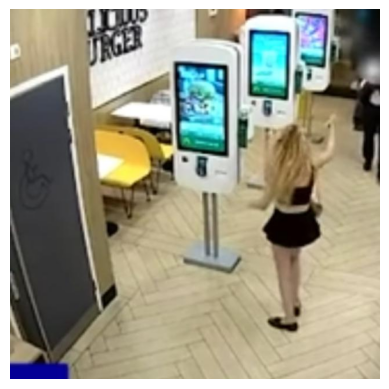

0.27


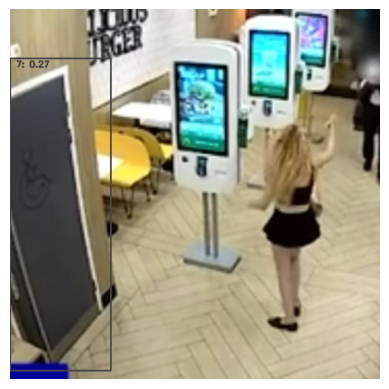

In [115]:
# 生成检测框图像
image_with_boxes = draw_boxes(image, outputs, class_range)

# 显示图像
plt.imshow(cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

image_with_boxes = draw_boxes(image, outputs_adv, class_range)

plt.imshow(cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

In [116]:
image_path = '/content/drive/My Drive/2024 Fall/COMS 6730/Projects/Person-Detection-YOLOV8N-Dectection/test/images/552_png.rf.db52aefafea5e76c45f6d0d6eeb6760b.jpg'
image = cv2.imread(image_path)

outputs = model(image)

# 将图像和标签转换为 Tensor
images = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0).to(device) / 255.0
labels = torch.tensor([0]).to(device)

# 生成对抗样本
print("Generating adversarial examples...")
images_adv = pgd_attack(model, images, epsilon, alpha, num_iter)

# 使用对抗样本进行预测
outputs_adv = model(images_adv)


0: 640x640 1 person, 9.5ms
Speed: 1.8ms preprocess, 9.5ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.5ms
Speed: 0.0ms preprocess, 7.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.4ms
Speed: 0.0ms preprocess, 9.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.4ms
Speed: 0.0ms preprocess, 9.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.3ms
Speed: 0.0ms preprocess, 9.3ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.4ms
Speed: 0.0ms preprocess, 9.4ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.3ms
Speed: 0.0ms preprocess, 9.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 11.4ms
Speed: 0.0ms preprocess, 11.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


Generating adversarial examples...
Iteration 1/100, Loss: -0.14604008197784424
Iteration 2/100, Loss: 0.02646985650062561
Iteration 3/100, Loss: 0.02646985650062561
Iteration 4/100, Loss: 0.02646985650062561
Iteration 5/100, Loss: 0.02646985650062561
Iteration 6/100, Loss: 0.02646985650062561
Iteration 7/100, Loss: 0.02646985650062561
Iteration 8/100, Loss: 0.02646985650062561
Iteration 9/100, Loss: 0.02646985650062561
Iteration 10/100, Loss: 0.02646985650062561
Iteration 11/100, Loss: 0.02646985650062561


0: 640x640 2 persons, 9.4ms
Speed: 0.0ms preprocess, 9.4ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.4ms
Speed: 0.0ms preprocess, 9.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.4ms
Speed: 0.0ms preprocess, 9.4ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.4ms
Speed: 0.0ms preprocess, 9.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.4ms
Speed: 0.0ms preprocess, 9.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.4ms
Speed: 0.0ms preprocess, 9.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.1ms
Speed: 0.0ms preprocess, 9.1ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.4ms
Speed: 0.0ms preprocess, 8.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)



Iteration 12/100, Loss: 0.02646985650062561
Iteration 13/100, Loss: 0.02646985650062561
Iteration 14/100, Loss: 0.02646985650062561
Iteration 15/100, Loss: 0.02646985650062561
Iteration 16/100, Loss: 0.02646985650062561
Iteration 17/100, Loss: 0.02646985650062561
Iteration 18/100, Loss: 0.02646985650062561
Iteration 19/100, Loss: 0.02646985650062561
Iteration 20/100, Loss: 0.02646985650062561
Iteration 21/100, Loss: 0.02646985650062561
Iteration 22/100, Loss: 0.02646985650062561
Iteration 23/100, Loss: 0.02646985650062561



0: 640x640 2 persons, 8.4ms
Speed: 0.0ms preprocess, 8.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.8ms
Speed: 0.0ms preprocess, 8.8ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.3ms
Speed: 0.0ms preprocess, 8.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.8ms
Speed: 0.0ms preprocess, 7.8ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.2ms
Speed: 0.0ms preprocess, 8.2ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 10.7ms
Speed: 0.0ms preprocess, 10.7ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 10.1ms
Speed: 0.0ms preprocess, 10.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.6ms
Speed: 0.0ms preprocess, 8.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 6

Iteration 24/100, Loss: 0.02646985650062561
Iteration 25/100, Loss: 0.02646985650062561
Iteration 26/100, Loss: 0.02646985650062561
Iteration 27/100, Loss: 0.02646985650062561
Iteration 28/100, Loss: 0.02646985650062561
Iteration 29/100, Loss: 0.02646985650062561
Iteration 30/100, Loss: 0.02646985650062561
Iteration 31/100, Loss: 0.02646985650062561
Iteration 32/100, Loss: 0.02646985650062561
Iteration 33/100, Loss: 0.02646985650062561
Iteration 34/100, Loss: 0.02646985650062561
Iteration 35/100, Loss: 0.02646985650062561


0: 640x640 2 persons, 8.8ms
Speed: 0.0ms preprocess, 8.8ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.2ms
Speed: 0.0ms preprocess, 9.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.5ms
Speed: 0.0ms preprocess, 8.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.1ms
Speed: 0.0ms preprocess, 8.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.6ms
Speed: 0.0ms preprocess, 8.6ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.5ms
Speed: 0.0ms preprocess, 9.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.6ms
Speed: 0.0ms preprocess, 9.6ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.8ms
Speed: 0.0ms preprocess, 8.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



Iteration 36/100, Loss: 0.02646985650062561
Iteration 37/100, Loss: 0.02646985650062561
Iteration 38/100, Loss: 0.02646985650062561
Iteration 39/100, Loss: 0.02646985650062561
Iteration 40/100, Loss: 0.02646985650062561
Iteration 41/100, Loss: 0.02646985650062561
Iteration 42/100, Loss: 0.02646985650062561
Iteration 43/100, Loss: 0.02646985650062561
Iteration 44/100, Loss: 0.02646985650062561
Iteration 45/100, Loss: 0.02646985650062561
Iteration 46/100, Loss: 0.02646985650062561
Iteration 47/100, Loss: 0.02646985650062561



0: 640x640 2 persons, 9.7ms
Speed: 0.0ms preprocess, 9.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 10.4ms
Speed: 0.0ms preprocess, 10.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.7ms
Speed: 0.0ms preprocess, 8.7ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.1ms
Speed: 0.0ms preprocess, 9.1ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.2ms
Speed: 0.0ms preprocess, 9.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 10.3ms
Speed: 0.0ms preprocess, 10.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.4ms
Speed: 0.0ms preprocess, 8.4ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.0ms
Speed: 0.0ms preprocess, 8.0ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 6

Iteration 48/100, Loss: 0.02646985650062561
Iteration 49/100, Loss: 0.02646985650062561
Iteration 50/100, Loss: 0.02646985650062561
Iteration 51/100, Loss: 0.02646985650062561
Iteration 52/100, Loss: 0.02646985650062561
Iteration 53/100, Loss: 0.02646985650062561
Iteration 54/100, Loss: 0.02646985650062561
Iteration 55/100, Loss: 0.02646985650062561
Iteration 56/100, Loss: 0.02646985650062561
Iteration 57/100, Loss: 0.02646985650062561
Iteration 58/100, Loss: 0.02646985650062561
Iteration 59/100, Loss: 0.02646985650062561


0: 640x640 2 persons, 9.2ms
Speed: 0.0ms preprocess, 9.2ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.8ms
Speed: 0.0ms preprocess, 8.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.2ms
Speed: 0.0ms preprocess, 9.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.0ms
Speed: 0.0ms preprocess, 8.0ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 10.4ms
Speed: 0.0ms preprocess, 10.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.9ms
Speed: 0.0ms preprocess, 8.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.4ms
Speed: 0.0ms preprocess, 8.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.1ms
Speed: 0.0ms preprocess, 8.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

Iteration 60/100, Loss: 0.02646985650062561
Iteration 61/100, Loss: 0.02646985650062561
Iteration 62/100, Loss: 0.02646985650062561
Iteration 63/100, Loss: 0.02646985650062561
Iteration 64/100, Loss: 0.02646985650062561
Iteration 65/100, Loss: 0.02646985650062561
Iteration 66/100, Loss: 0.02646985650062561
Iteration 67/100, Loss: 0.02646985650062561
Iteration 68/100, Loss: 0.02646985650062561
Iteration 69/100, Loss: 0.02646985650062561
Iteration 70/100, Loss: 0.02646985650062561
Iteration 71/100, Loss: 0.02646985650062561


0: 640x640 2 persons, 8.3ms
Speed: 0.0ms preprocess, 8.3ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 10.7ms
Speed: 0.0ms preprocess, 10.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.3ms
Speed: 0.0ms preprocess, 8.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.5ms
Speed: 0.0ms preprocess, 7.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.1ms
Speed: 0.0ms preprocess, 8.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.3ms
Speed: 0.0ms preprocess, 9.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.3ms
Speed: 0.0ms preprocess, 9.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.4ms
Speed: 0.0ms preprocess, 8.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

Iteration 72/100, Loss: 0.02646985650062561
Iteration 73/100, Loss: 0.02646985650062561
Iteration 74/100, Loss: 0.02646985650062561
Iteration 75/100, Loss: 0.02646985650062561
Iteration 76/100, Loss: 0.02646985650062561
Iteration 77/100, Loss: 0.02646985650062561
Iteration 78/100, Loss: 0.02646985650062561
Iteration 79/100, Loss: 0.02646985650062561
Iteration 80/100, Loss: 0.02646985650062561
Iteration 81/100, Loss: 0.02646985650062561
Iteration 82/100, Loss: 0.02646985650062561
Iteration 83/100, Loss: 0.02646985650062561



0: 640x640 2 persons, 9.3ms
Speed: 0.0ms preprocess, 9.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 10.1ms
Speed: 0.1ms preprocess, 10.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 10.5ms
Speed: 0.0ms preprocess, 10.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.6ms
Speed: 0.0ms preprocess, 8.6ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.4ms
Speed: 0.1ms preprocess, 9.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.2ms
Speed: 0.0ms preprocess, 8.2ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 11.5ms
Speed: 0.0ms preprocess, 11.5ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.8ms
Speed: 0.0ms preprocess, 8.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640,

Iteration 84/100, Loss: 0.02646985650062561
Iteration 85/100, Loss: 0.02646985650062561
Iteration 86/100, Loss: 0.02646985650062561
Iteration 87/100, Loss: 0.02646985650062561
Iteration 88/100, Loss: 0.02646985650062561
Iteration 89/100, Loss: 0.02646985650062561
Iteration 90/100, Loss: 0.02646985650062561
Iteration 91/100, Loss: 0.02646985650062561
Iteration 92/100, Loss: 0.02646985650062561
Iteration 93/100, Loss: 0.02646985650062561
Iteration 94/100, Loss: 0.02646985650062561
Iteration 95/100, Loss: 0.02646985650062561


0: 640x640 2 persons, 10.2ms
Speed: 0.0ms preprocess, 10.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.6ms
Speed: 0.0ms preprocess, 8.6ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.7ms
Speed: 0.0ms preprocess, 8.7ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.8ms
Speed: 0.0ms preprocess, 9.8ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.3ms
Speed: 0.0ms preprocess, 8.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 10.4ms
Speed: 0.0ms preprocess, 10.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


Iteration 96/100, Loss: 0.02646985650062561
Iteration 97/100, Loss: 0.02646985650062561
Iteration 98/100, Loss: 0.02646985650062561
Iteration 99/100, Loss: 0.02646985650062561
Iteration 100/100, Loss: 0.02646985650062561


0.36


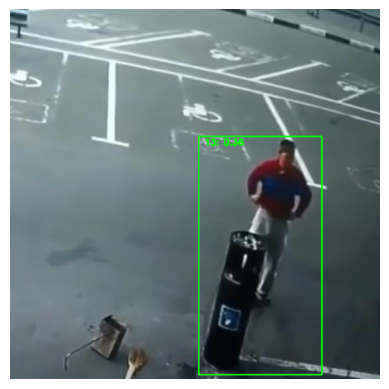

0.35
0.26


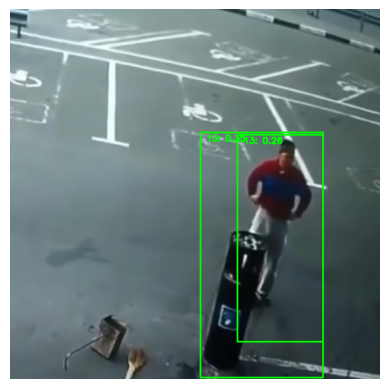

In [117]:
# 生成检测框图像
image_with_boxes = draw_boxes(image, outputs, class_range)

# 显示图像
plt.imshow(cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

image_with_boxes = draw_boxes(image, outputs_adv, class_range)

plt.imshow(cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

In [118]:
image_path = '/content/drive/My Drive/2024 Fall/COMS 6730/Projects/Person-Detection-YOLOV8N-Dectection/test/images/553_png.rf.53156c7f677314703d70b307e360efb6.jpg'
image = cv2.imread(image_path)

outputs = model(image)

# 将图像和标签转换为 Tensor
images = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0).to(device) / 255.0
labels = torch.tensor([0]).to(device)

# 生成对抗样本
print("Generating adversarial examples...")
images_adv = pgd_attack(model, images, epsilon, alpha, num_iter)

# 使用对抗样本进行预测
outputs_adv = model(images_adv)


0: 640x640 2 persons, 7.5ms
Speed: 1.8ms preprocess, 7.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.4ms
Speed: 0.0ms preprocess, 8.4ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.4ms
Speed: 0.0ms preprocess, 9.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.4ms
Speed: 0.0ms preprocess, 9.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.4ms
Speed: 0.0ms preprocess, 9.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.4ms
Speed: 0.0ms preprocess, 9.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.4ms
Speed: 0.0ms preprocess, 9.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.4ms
Speed: 0.0ms preprocess, 9.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


Generating adversarial examples...
Iteration 1/100, Loss: 0.025692284107208252
Iteration 2/100, Loss: -0.051129624247550964
Iteration 3/100, Loss: -0.051129624247550964
Iteration 4/100, Loss: -0.051129624247550964
Iteration 5/100, Loss: -0.051129624247550964
Iteration 6/100, Loss: -0.051129624247550964
Iteration 7/100, Loss: -0.051129624247550964
Iteration 8/100, Loss: -0.051129624247550964
Iteration 9/100, Loss: -0.051129624247550964
Iteration 10/100, Loss: -0.051129624247550964
Iteration 11/100, Loss: -0.051129624247550964


0: 640x640 2 persons, 12.9ms
Speed: 0.0ms preprocess, 12.9ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 10.8ms
Speed: 0.0ms preprocess, 10.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.4ms
Speed: 0.0ms preprocess, 9.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.4ms
Speed: 0.0ms preprocess, 9.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.9ms
Speed: 0.0ms preprocess, 8.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.2ms
Speed: 0.0ms preprocess, 8.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 11.4ms
Speed: 0.0ms preprocess, 11.4ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 11.2ms
Speed: 0.0ms preprocess, 11.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640

Iteration 12/100, Loss: -0.051129624247550964
Iteration 13/100, Loss: -0.051129624247550964
Iteration 14/100, Loss: -0.051129624247550964
Iteration 15/100, Loss: -0.051129624247550964
Iteration 16/100, Loss: -0.051129624247550964
Iteration 17/100, Loss: -0.051129624247550964
Iteration 18/100, Loss: -0.051129624247550964
Iteration 19/100, Loss: -0.051129624247550964
Iteration 20/100, Loss: -0.051129624247550964
Iteration 21/100, Loss: -0.051129624247550964
Iteration 22/100, Loss: -0.051129624247550964



0: 640x640 2 persons, 8.1ms
Speed: 0.0ms preprocess, 8.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.8ms
Speed: 0.0ms preprocess, 9.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 11.2ms
Speed: 0.0ms preprocess, 11.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.5ms
Speed: 0.0ms preprocess, 8.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.9ms
Speed: 0.0ms preprocess, 7.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 10.3ms
Speed: 0.0ms preprocess, 10.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.7ms
Speed: 0.0ms preprocess, 8.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.6ms
Speed: 0.0ms preprocess, 9.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 6

Iteration 23/100, Loss: -0.051129624247550964
Iteration 24/100, Loss: -0.051129624247550964
Iteration 25/100, Loss: -0.051129624247550964
Iteration 26/100, Loss: -0.051129624247550964
Iteration 27/100, Loss: -0.051129624247550964
Iteration 28/100, Loss: -0.051129624247550964
Iteration 29/100, Loss: -0.051129624247550964
Iteration 30/100, Loss: -0.051129624247550964
Iteration 31/100, Loss: -0.051129624247550964
Iteration 32/100, Loss: -0.051129624247550964
Iteration 33/100, Loss: -0.051129624247550964
Iteration 34/100, Loss: -0.051129624247550964


0: 640x640 2 persons, 10.2ms
Speed: 0.0ms preprocess, 10.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.6ms
Speed: 0.0ms preprocess, 8.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.7ms
Speed: 0.0ms preprocess, 8.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.9ms
Speed: 0.0ms preprocess, 9.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.1ms
Speed: 0.0ms preprocess, 8.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.7ms
Speed: 0.0ms preprocess, 8.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.2ms
Speed: 0.0ms preprocess, 8.2ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.1ms
Speed: 0.0ms preprocess, 8.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

Iteration 35/100, Loss: -0.051129624247550964
Iteration 36/100, Loss: -0.051129624247550964
Iteration 37/100, Loss: -0.051129624247550964
Iteration 38/100, Loss: -0.051129624247550964
Iteration 39/100, Loss: -0.051129624247550964
Iteration 40/100, Loss: -0.051129624247550964
Iteration 41/100, Loss: -0.051129624247550964
Iteration 42/100, Loss: -0.051129624247550964
Iteration 43/100, Loss: -0.051129624247550964
Iteration 44/100, Loss: -0.051129624247550964
Iteration 45/100, Loss: -0.051129624247550964
Iteration 46/100, Loss: -0.051129624247550964


0: 640x640 2 persons, 9.2ms
Speed: 0.0ms preprocess, 9.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.7ms
Speed: 0.0ms preprocess, 8.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.5ms
Speed: 0.0ms preprocess, 9.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.8ms
Speed: 0.0ms preprocess, 8.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.6ms
Speed: 0.0ms preprocess, 8.6ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.9ms
Speed: 0.0ms preprocess, 9.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.3ms
Speed: 0.0ms preprocess, 8.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.3ms
Speed: 0.0ms preprocess, 8.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)



Iteration 47/100, Loss: -0.051129624247550964
Iteration 48/100, Loss: -0.051129624247550964
Iteration 49/100, Loss: -0.051129624247550964
Iteration 50/100, Loss: -0.051129624247550964
Iteration 51/100, Loss: -0.051129624247550964
Iteration 52/100, Loss: -0.051129624247550964
Iteration 53/100, Loss: -0.051129624247550964
Iteration 54/100, Loss: -0.051129624247550964
Iteration 55/100, Loss: -0.051129624247550964
Iteration 56/100, Loss: -0.051129624247550964
Iteration 57/100, Loss: -0.051129624247550964
Iteration 58/100, Loss: -0.051129624247550964


0: 640x640 2 persons, 9.6ms
Speed: 0.0ms preprocess, 9.6ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 11.6ms
Speed: 0.0ms preprocess, 11.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.9ms
Speed: 0.0ms preprocess, 9.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.7ms
Speed: 0.0ms preprocess, 8.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.3ms
Speed: 0.0ms preprocess, 8.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.5ms
Speed: 0.0ms preprocess, 9.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 11.1ms
Speed: 0.0ms preprocess, 11.1ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.1ms
Speed: 0.0ms preprocess, 9.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 64

Iteration 59/100, Loss: -0.051129624247550964
Iteration 60/100, Loss: -0.051129624247550964
Iteration 61/100, Loss: -0.051129624247550964
Iteration 62/100, Loss: -0.051129624247550964
Iteration 63/100, Loss: -0.051129624247550964
Iteration 64/100, Loss: -0.051129624247550964
Iteration 65/100, Loss: -0.051129624247550964
Iteration 66/100, Loss: -0.051129624247550964
Iteration 67/100, Loss: -0.051129624247550964
Iteration 68/100, Loss: -0.051129624247550964
Iteration 69/100, Loss: -0.051129624247550964
Iteration 70/100, Loss: -0.051129624247550964


0: 640x640 2 persons, 9.1ms
Speed: 0.0ms preprocess, 9.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.1ms
Speed: 0.0ms preprocess, 8.1ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.2ms
Speed: 0.0ms preprocess, 8.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.2ms
Speed: 0.0ms preprocess, 8.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.1ms
Speed: 0.0ms preprocess, 8.1ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.5ms
Speed: 0.0ms preprocess, 8.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.5ms
Speed: 0.0ms preprocess, 8.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 10.0ms
Speed: 0.0ms preprocess, 10.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

Iteration 71/100, Loss: -0.051129624247550964
Iteration 72/100, Loss: -0.051129624247550964
Iteration 73/100, Loss: -0.051129624247550964
Iteration 74/100, Loss: -0.051129624247550964
Iteration 75/100, Loss: -0.051129624247550964
Iteration 76/100, Loss: -0.051129624247550964
Iteration 77/100, Loss: -0.051129624247550964
Iteration 78/100, Loss: -0.051129624247550964
Iteration 79/100, Loss: -0.051129624247550964
Iteration 80/100, Loss: -0.051129624247550964
Iteration 81/100, Loss: -0.051129624247550964
Iteration 82/100, Loss: -0.051129624247550964
Iteration 83/100, Loss: -0.051129624247550964



0: 640x640 2 persons, 9.0ms
Speed: 0.0ms preprocess, 9.0ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.7ms
Speed: 0.0ms preprocess, 8.7ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.1ms
Speed: 0.0ms preprocess, 9.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.3ms
Speed: 0.0ms preprocess, 8.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.3ms
Speed: 0.0ms preprocess, 8.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.7ms
Speed: 0.0ms preprocess, 7.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.3ms
Speed: 0.0ms preprocess, 8.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.6ms
Speed: 0.0ms preprocess, 8.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Iteration 84/100, Loss: -0.051129624247550964
Iteration 85/100, Loss: -0.051129624247550964
Iteration 86/100, Loss: -0.051129624247550964
Iteration 87/100, Loss: -0.051129624247550964
Iteration 88/100, Loss: -0.051129624247550964
Iteration 89/100, Loss: -0.051129624247550964
Iteration 90/100, Loss: -0.051129624247550964
Iteration 91/100, Loss: -0.051129624247550964
Iteration 92/100, Loss: -0.051129624247550964
Iteration 93/100, Loss: -0.051129624247550964
Iteration 94/100, Loss: -0.051129624247550964
Iteration 95/100, Loss: -0.051129624247550964


0: 640x640 2 persons, 10.8ms
Speed: 0.0ms preprocess, 10.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 10.7ms
Speed: 0.0ms preprocess, 10.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.1ms
Speed: 0.0ms preprocess, 8.1ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.5ms
Speed: 0.0ms preprocess, 8.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.5ms
Speed: 0.0ms preprocess, 8.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.6ms
Speed: 0.0ms preprocess, 9.6ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


Iteration 96/100, Loss: -0.051129624247550964
Iteration 97/100, Loss: -0.051129624247550964
Iteration 98/100, Loss: -0.051129624247550964
Iteration 99/100, Loss: -0.051129624247550964
Iteration 100/100, Loss: -0.051129624247550964


0.52
0.39


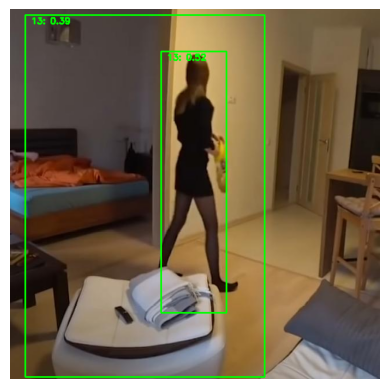

0.31
0.27


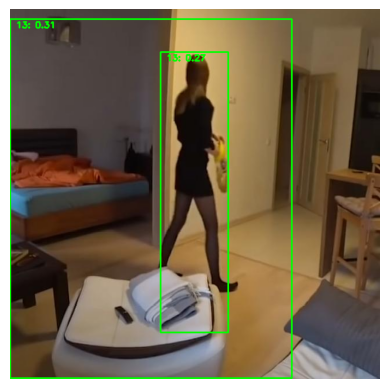

In [119]:
# 生成检测框图像
image_with_boxes = draw_boxes(image, outputs, class_range)

# 显示图像
plt.imshow(cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

image_with_boxes = draw_boxes(image, outputs_adv, class_range)

plt.imshow(cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

In [120]:
image_path = '/content/drive/My Drive/2024 Fall/COMS 6730/Projects/Person-Detection-YOLOV8N-Dectection/test/images/556_png.rf.04e60f97d172739af5012df81fcf73ab.jpg'
image = cv2.imread(image_path)

outputs = model(image)

# 将图像和标签转换为 Tensor
images = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0).to(device) / 255.0
labels = torch.tensor([0]).to(device)

# 生成对抗样本
print("Generating adversarial examples...")
images_adv = pgd_attack(model, images, epsilon, alpha, num_iter)

# 使用对抗样本进行预测
outputs_adv = model(images_adv)


0: 640x640 1 rat, 7.5ms
Speed: 2.4ms preprocess, 7.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 door, 7.5ms
Speed: 0.0ms preprocess, 7.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 door, 9.4ms
Speed: 0.0ms preprocess, 9.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 door, 9.3ms
Speed: 0.0ms preprocess, 9.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 door, 9.3ms
Speed: 0.0ms preprocess, 9.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 door, 9.3ms
Speed: 0.0ms preprocess, 9.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 door, 9.3ms
Speed: 0.0ms preprocess, 9.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 door, 9.3ms
Speed: 0.0ms preprocess, 9.3ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 door, 9.4ms

Generating adversarial examples...
Iteration 1/100, Loss: 0.7222399711608887
Iteration 2/100, Loss: 0.6267245411872864
Iteration 3/100, Loss: 0.6267245411872864
Iteration 4/100, Loss: 0.6267245411872864
Iteration 5/100, Loss: 0.6267245411872864
Iteration 6/100, Loss: 0.6267245411872864
Iteration 7/100, Loss: 0.6267245411872864
Iteration 8/100, Loss: 0.6267245411872864
Iteration 9/100, Loss: 0.6267245411872864
Iteration 10/100, Loss: 0.6267245411872864
Iteration 11/100, Loss: 0.6267245411872864


0: 640x640 1 door, 10.2ms
Speed: 0.0ms preprocess, 10.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 door, 8.4ms
Speed: 0.0ms preprocess, 8.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 door, 9.6ms
Speed: 0.0ms preprocess, 9.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 door, 8.3ms
Speed: 0.0ms preprocess, 8.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 door, 8.6ms
Speed: 0.0ms preprocess, 8.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 door, 8.8ms
Speed: 0.0ms preprocess, 8.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 door, 8.5ms
Speed: 0.0ms preprocess, 8.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 door, 8.9ms
Speed: 0.0ms preprocess, 8.9ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 door, 9.1

Iteration 12/100, Loss: 0.6267245411872864
Iteration 13/100, Loss: 0.6267245411872864
Iteration 14/100, Loss: 0.6267245411872864
Iteration 15/100, Loss: 0.6267245411872864
Iteration 16/100, Loss: 0.6267245411872864
Iteration 17/100, Loss: 0.6267245411872864
Iteration 18/100, Loss: 0.6267245411872864
Iteration 19/100, Loss: 0.6267245411872864
Iteration 20/100, Loss: 0.6267245411872864
Iteration 21/100, Loss: 0.6267245411872864
Iteration 22/100, Loss: 0.6267245411872864
Iteration 23/100, Loss: 0.6267245411872864


0: 640x640 1 door, 11.0ms
Speed: 0.0ms preprocess, 11.0ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 door, 10.2ms
Speed: 0.0ms preprocess, 10.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 door, 8.4ms
Speed: 0.0ms preprocess, 8.4ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 door, 8.0ms
Speed: 0.0ms preprocess, 8.0ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 door, 8.2ms
Speed: 0.0ms preprocess, 8.2ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 door, 8.3ms
Speed: 0.0ms preprocess, 8.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 door, 8.0ms
Speed: 0.0ms preprocess, 8.0ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 door, 8.7ms
Speed: 0.0ms preprocess, 8.7ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 door, 8

Iteration 24/100, Loss: 0.6267245411872864
Iteration 25/100, Loss: 0.6267245411872864
Iteration 26/100, Loss: 0.6267245411872864
Iteration 27/100, Loss: 0.6267245411872864
Iteration 28/100, Loss: 0.6267245411872864
Iteration 29/100, Loss: 0.6267245411872864
Iteration 30/100, Loss: 0.6267245411872864
Iteration 31/100, Loss: 0.6267245411872864
Iteration 32/100, Loss: 0.6267245411872864
Iteration 33/100, Loss: 0.6267245411872864
Iteration 34/100, Loss: 0.6267245411872864
Iteration 35/100, Loss: 0.6267245411872864


0: 640x640 1 door, 8.4ms
Speed: 0.0ms preprocess, 8.4ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 door, 8.4ms
Speed: 0.0ms preprocess, 8.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 door, 8.4ms
Speed: 0.0ms preprocess, 8.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 door, 7.8ms
Speed: 0.0ms preprocess, 7.8ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 door, 7.7ms
Speed: 0.0ms preprocess, 7.7ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 door, 7.6ms
Speed: 0.0ms preprocess, 7.6ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 door, 7.9ms
Speed: 0.0ms preprocess, 7.9ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 door, 8.6ms
Speed: 0.0ms preprocess, 8.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 door, 8.5ms

Iteration 36/100, Loss: 0.6267245411872864
Iteration 37/100, Loss: 0.6267245411872864
Iteration 38/100, Loss: 0.6267245411872864
Iteration 39/100, Loss: 0.6267245411872864
Iteration 40/100, Loss: 0.6267245411872864
Iteration 41/100, Loss: 0.6267245411872864
Iteration 42/100, Loss: 0.6267245411872864
Iteration 43/100, Loss: 0.6267245411872864
Iteration 44/100, Loss: 0.6267245411872864
Iteration 45/100, Loss: 0.6267245411872864
Iteration 46/100, Loss: 0.6267245411872864
Iteration 47/100, Loss: 0.6267245411872864


0: 640x640 1 door, 9.0ms
Speed: 0.0ms preprocess, 9.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 door, 8.0ms
Speed: 0.0ms preprocess, 8.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 door, 8.2ms
Speed: 0.0ms preprocess, 8.2ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 door, 8.8ms
Speed: 0.0ms preprocess, 8.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 door, 8.3ms
Speed: 0.0ms preprocess, 8.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 door, 8.8ms
Speed: 0.0ms preprocess, 8.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 door, 9.7ms
Speed: 0.0ms preprocess, 9.7ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 door, 8.9ms
Speed: 0.0ms preprocess, 8.9ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 door, 9.0ms

Iteration 48/100, Loss: 0.6267245411872864
Iteration 49/100, Loss: 0.6267245411872864
Iteration 50/100, Loss: 0.6267245411872864
Iteration 51/100, Loss: 0.6267245411872864
Iteration 52/100, Loss: 0.6267245411872864
Iteration 53/100, Loss: 0.6267245411872864
Iteration 54/100, Loss: 0.6267245411872864
Iteration 55/100, Loss: 0.6267245411872864
Iteration 56/100, Loss: 0.6267245411872864
Iteration 57/100, Loss: 0.6267245411872864
Iteration 58/100, Loss: 0.6267245411872864
Iteration 59/100, Loss: 0.6267245411872864


0: 640x640 1 door, 10.4ms
Speed: 0.0ms preprocess, 10.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 door, 8.0ms
Speed: 0.0ms preprocess, 8.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 door, 7.9ms
Speed: 0.0ms preprocess, 7.9ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 door, 8.5ms
Speed: 0.0ms preprocess, 8.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 door, 10.2ms
Speed: 0.0ms preprocess, 10.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 door, 8.4ms
Speed: 0.0ms preprocess, 8.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 door, 8.2ms
Speed: 0.0ms preprocess, 8.2ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 door, 8.4ms
Speed: 0.0ms preprocess, 8.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 door, 8

Iteration 60/100, Loss: 0.6267245411872864
Iteration 61/100, Loss: 0.6267245411872864
Iteration 62/100, Loss: 0.6267245411872864
Iteration 63/100, Loss: 0.6267245411872864
Iteration 64/100, Loss: 0.6267245411872864
Iteration 65/100, Loss: 0.6267245411872864
Iteration 66/100, Loss: 0.6267245411872864
Iteration 67/100, Loss: 0.6267245411872864
Iteration 68/100, Loss: 0.6267245411872864
Iteration 69/100, Loss: 0.6267245411872864
Iteration 70/100, Loss: 0.6267245411872864
Iteration 71/100, Loss: 0.6267245411872864


Speed: 0.0ms preprocess, 8.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 door, 8.9ms
Speed: 0.0ms preprocess, 8.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 door, 10.4ms
Speed: 0.0ms preprocess, 10.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 door, 9.7ms
Speed: 0.0ms preprocess, 9.7ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 door, 12.7ms
Speed: 0.0ms preprocess, 12.7ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 door, 8.2ms
Speed: 0.0ms preprocess, 8.2ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 door, 10.5ms
Speed: 0.0ms preprocess, 10.5ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 door, 10.3ms
Speed: 0.0ms preprocess, 10.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 door, 7.7ms
Speed: 0.0ms pre

Iteration 72/100, Loss: 0.6267245411872864
Iteration 73/100, Loss: 0.6267245411872864
Iteration 74/100, Loss: 0.6267245411872864
Iteration 75/100, Loss: 0.6267245411872864
Iteration 76/100, Loss: 0.6267245411872864
Iteration 77/100, Loss: 0.6267245411872864
Iteration 78/100, Loss: 0.6267245411872864
Iteration 79/100, Loss: 0.6267245411872864
Iteration 80/100, Loss: 0.6267245411872864
Iteration 81/100, Loss: 0.6267245411872864
Iteration 82/100, Loss: 0.6267245411872864


Speed: 0.0ms preprocess, 9.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 door, 8.4ms
Speed: 0.1ms preprocess, 8.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 door, 7.9ms
Speed: 0.0ms preprocess, 7.9ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 door, 8.3ms
Speed: 0.0ms preprocess, 8.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 door, 9.8ms
Speed: 0.0ms preprocess, 9.8ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 door, 8.4ms
Speed: 0.0ms preprocess, 8.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 door, 8.0ms
Speed: 0.0ms preprocess, 8.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 door, 8.4ms
Speed: 0.1ms preprocess, 8.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 door, 9.0ms
Speed: 0.0ms preprocess,

Iteration 83/100, Loss: 0.6267245411872864
Iteration 84/100, Loss: 0.6267245411872864
Iteration 85/100, Loss: 0.6267245411872864
Iteration 86/100, Loss: 0.6267245411872864
Iteration 87/100, Loss: 0.6267245411872864
Iteration 88/100, Loss: 0.6267245411872864
Iteration 89/100, Loss: 0.6267245411872864
Iteration 90/100, Loss: 0.6267245411872864
Iteration 91/100, Loss: 0.6267245411872864
Iteration 92/100, Loss: 0.6267245411872864
Iteration 93/100, Loss: 0.6267245411872864
Iteration 94/100, Loss: 0.6267245411872864


0: 640x640 1 door, 9.4ms
Speed: 0.0ms preprocess, 9.4ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 door, 8.1ms
Speed: 0.0ms preprocess, 8.1ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 door, 8.7ms
Speed: 0.0ms preprocess, 8.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 door, 8.9ms
Speed: 0.0ms preprocess, 8.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 door, 8.6ms
Speed: 0.0ms preprocess, 8.6ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 door, 8.4ms
Speed: 0.0ms preprocess, 8.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 door, 10.1ms
Speed: 0.0ms preprocess, 10.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


Iteration 95/100, Loss: 0.6267245411872864
Iteration 96/100, Loss: 0.6267245411872864
Iteration 97/100, Loss: 0.6267245411872864
Iteration 98/100, Loss: 0.6267245411872864
Iteration 99/100, Loss: 0.6267245411872864
Iteration 100/100, Loss: 0.6267245411872864


0.33


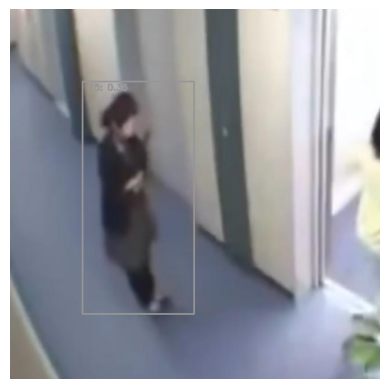

0.85


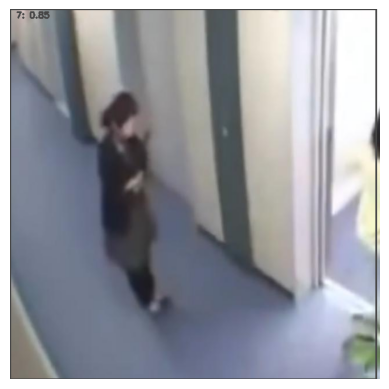

In [121]:
# 生成检测框图像
image_with_boxes = draw_boxes(image, outputs, class_range)

# 显示图像
plt.imshow(cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

image_with_boxes = draw_boxes(image, outputs_adv, class_range)

plt.imshow(cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

In [122]:
image_path = '/content/drive/My Drive/2024 Fall/COMS 6730/Projects/Person-Detection-YOLOV8N-Dectection/test/images/554_png.rf.537775b63b27818ceb81d8a71aa48abf.jpg'
image = cv2.imread(image_path)

outputs = model(image)

# 将图像和标签转换为 Tensor
images = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0).to(device) / 255.0
labels = torch.tensor([0]).to(device)

# 生成对抗样本
print("Generating adversarial examples...")
images_adv = pgd_attack(model, images, epsilon, alpha, num_iter)

# 使用对抗样本进行预测
outputs_adv = model(images_adv)


0: 640x640 1 scooter, 7.5ms
Speed: 1.8ms preprocess, 7.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 scooter, 7.5ms
Speed: 0.0ms preprocess, 7.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 scooter, 9.4ms
Speed: 0.0ms preprocess, 9.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 scooter, 9.4ms
Speed: 0.0ms preprocess, 9.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 scooter, 9.4ms
Speed: 0.1ms preprocess, 9.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 scooter, 9.8ms
Speed: 0.1ms preprocess, 9.8ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 scooter, 9.4ms
Speed: 0.0ms preprocess, 9.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 scooter, 9.3ms
Speed: 0.0ms preprocess, 9.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


Generating adversarial examples...
Iteration 1/100, Loss: 0.9607757329940796
Iteration 2/100, Loss: 0.6042485237121582
Iteration 3/100, Loss: 0.6042485237121582
Iteration 4/100, Loss: 0.6042485237121582
Iteration 5/100, Loss: 0.6042485237121582
Iteration 6/100, Loss: 0.6042485237121582
Iteration 7/100, Loss: 0.6042485237121582
Iteration 8/100, Loss: 0.6042485237121582
Iteration 9/100, Loss: 0.6042485237121582
Iteration 10/100, Loss: 0.6042485237121582
Iteration 11/100, Loss: 0.6042485237121582


0: 640x640 1 scooter, 9.4ms
Speed: 0.0ms preprocess, 9.4ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 scooter, 9.3ms
Speed: 0.0ms preprocess, 9.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 scooter, 8.5ms
Speed: 0.0ms preprocess, 8.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 scooter, 8.1ms
Speed: 0.0ms preprocess, 8.1ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 scooter, 8.4ms
Speed: 0.0ms preprocess, 8.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 scooter, 8.5ms
Speed: 0.0ms preprocess, 8.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 scooter, 8.3ms
Speed: 0.0ms preprocess, 8.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 scooter, 7.9ms
Speed: 0.0ms preprocess, 7.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)



Iteration 12/100, Loss: 0.6042485237121582
Iteration 13/100, Loss: 0.6042485237121582
Iteration 14/100, Loss: 0.6042485237121582
Iteration 15/100, Loss: 0.6042485237121582
Iteration 16/100, Loss: 0.6042485237121582
Iteration 17/100, Loss: 0.6042485237121582
Iteration 18/100, Loss: 0.6042485237121582
Iteration 19/100, Loss: 0.6042485237121582
Iteration 20/100, Loss: 0.6042485237121582
Iteration 21/100, Loss: 0.6042485237121582
Iteration 22/100, Loss: 0.6042485237121582
Iteration 23/100, Loss: 0.6042485237121582
Iteration 24/100, Loss: 0.6042485237121582



0: 640x640 1 scooter, 9.9ms
Speed: 0.0ms preprocess, 9.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 scooter, 9.2ms
Speed: 0.1ms preprocess, 9.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 scooter, 7.7ms
Speed: 0.0ms preprocess, 7.7ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 scooter, 8.3ms
Speed: 0.0ms preprocess, 8.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 scooter, 8.0ms
Speed: 0.0ms preprocess, 8.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 scooter, 9.5ms
Speed: 0.0ms preprocess, 9.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 scooter, 8.7ms
Speed: 0.0ms preprocess, 8.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 scooter, 10.2ms
Speed: 0.0ms preprocess, 10.2ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640

Iteration 25/100, Loss: 0.6042485237121582
Iteration 26/100, Loss: 0.6042485237121582
Iteration 27/100, Loss: 0.6042485237121582
Iteration 28/100, Loss: 0.6042485237121582
Iteration 29/100, Loss: 0.6042485237121582
Iteration 30/100, Loss: 0.6042485237121582
Iteration 31/100, Loss: 0.6042485237121582
Iteration 32/100, Loss: 0.6042485237121582
Iteration 33/100, Loss: 0.6042485237121582
Iteration 34/100, Loss: 0.6042485237121582
Iteration 35/100, Loss: 0.6042485237121582
Iteration 36/100, Loss: 0.6042485237121582


0: 640x640 1 scooter, 10.3ms
Speed: 0.0ms preprocess, 10.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 scooter, 8.2ms
Speed: 0.0ms preprocess, 8.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 scooter, 9.6ms
Speed: 0.0ms preprocess, 9.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 scooter, 9.3ms
Speed: 0.0ms preprocess, 9.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 scooter, 9.1ms
Speed: 0.0ms preprocess, 9.1ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 scooter, 8.9ms
Speed: 0.0ms preprocess, 8.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 scooter, 9.1ms
Speed: 0.0ms preprocess, 9.1ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 scooter, 8.9ms
Speed: 0.0ms preprocess, 8.9ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

Iteration 37/100, Loss: 0.6042485237121582
Iteration 38/100, Loss: 0.6042485237121582
Iteration 39/100, Loss: 0.6042485237121582
Iteration 40/100, Loss: 0.6042485237121582
Iteration 41/100, Loss: 0.6042485237121582
Iteration 42/100, Loss: 0.6042485237121582
Iteration 43/100, Loss: 0.6042485237121582
Iteration 44/100, Loss: 0.6042485237121582
Iteration 45/100, Loss: 0.6042485237121582
Iteration 46/100, Loss: 0.6042485237121582
Iteration 47/100, Loss: 0.6042485237121582
Iteration 48/100, Loss: 0.6042485237121582
Iteration 49/100, Loss: 0.6042485237121582


0: 640x640 1 scooter, 9.1ms
Speed: 0.0ms preprocess, 9.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 scooter, 8.7ms
Speed: 0.0ms preprocess, 8.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 scooter, 8.9ms
Speed: 0.0ms preprocess, 8.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 scooter, 8.6ms
Speed: 0.0ms preprocess, 8.6ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 scooter, 7.6ms
Speed: 0.0ms preprocess, 7.6ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 scooter, 8.7ms
Speed: 0.0ms preprocess, 8.7ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 scooter, 9.3ms
Speed: 0.0ms preprocess, 9.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 scooter, 8.3ms
Speed: 0.0ms preprocess, 8.3ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)



Iteration 50/100, Loss: 0.6042485237121582
Iteration 51/100, Loss: 0.6042485237121582
Iteration 52/100, Loss: 0.6042485237121582
Iteration 53/100, Loss: 0.6042485237121582
Iteration 54/100, Loss: 0.6042485237121582
Iteration 55/100, Loss: 0.6042485237121582
Iteration 56/100, Loss: 0.6042485237121582
Iteration 57/100, Loss: 0.6042485237121582
Iteration 58/100, Loss: 0.6042485237121582
Iteration 59/100, Loss: 0.6042485237121582
Iteration 60/100, Loss: 0.6042485237121582
Iteration 61/100, Loss: 0.6042485237121582


0: 640x640 1 scooter, 8.3ms
Speed: 0.0ms preprocess, 8.3ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 scooter, 10.0ms
Speed: 0.0ms preprocess, 10.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 scooter, 8.2ms
Speed: 0.0ms preprocess, 8.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 scooter, 9.6ms
Speed: 0.0ms preprocess, 9.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 scooter, 9.2ms
Speed: 0.0ms preprocess, 9.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 scooter, 10.1ms
Speed: 0.0ms preprocess, 10.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 scooter, 9.2ms
Speed: 0.0ms preprocess, 9.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 scooter, 8.3ms
Speed: 0.0ms preprocess, 8.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 64

Iteration 62/100, Loss: 0.6042485237121582
Iteration 63/100, Loss: 0.6042485237121582
Iteration 64/100, Loss: 0.6042485237121582
Iteration 65/100, Loss: 0.6042485237121582
Iteration 66/100, Loss: 0.6042485237121582
Iteration 67/100, Loss: 0.6042485237121582
Iteration 68/100, Loss: 0.6042485237121582
Iteration 69/100, Loss: 0.6042485237121582
Iteration 70/100, Loss: 0.6042485237121582
Iteration 71/100, Loss: 0.6042485237121582
Iteration 72/100, Loss: 0.6042485237121582
Iteration 73/100, Loss: 0.6042485237121582


0: 640x640 1 scooter, 8.9ms
Speed: 0.0ms preprocess, 8.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 scooter, 9.0ms
Speed: 0.0ms preprocess, 9.0ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 scooter, 9.5ms
Speed: 0.0ms preprocess, 9.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 scooter, 8.1ms
Speed: 0.0ms preprocess, 8.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 scooter, 8.7ms
Speed: 0.0ms preprocess, 8.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 scooter, 8.2ms
Speed: 0.0ms preprocess, 8.2ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 scooter, 7.9ms
Speed: 0.0ms preprocess, 7.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 scooter, 8.7ms
Speed: 0.0ms preprocess, 8.7ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)



Iteration 74/100, Loss: 0.6042485237121582
Iteration 75/100, Loss: 0.6042485237121582
Iteration 76/100, Loss: 0.6042485237121582
Iteration 77/100, Loss: 0.6042485237121582
Iteration 78/100, Loss: 0.6042485237121582
Iteration 79/100, Loss: 0.6042485237121582
Iteration 80/100, Loss: 0.6042485237121582
Iteration 81/100, Loss: 0.6042485237121582
Iteration 82/100, Loss: 0.6042485237121582
Iteration 83/100, Loss: 0.6042485237121582
Iteration 84/100, Loss: 0.6042485237121582
Iteration 85/100, Loss: 0.6042485237121582
Iteration 86/100, Loss: 0.6042485237121582


0: 640x640 1 scooter, 10.3ms
Speed: 0.0ms preprocess, 10.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 scooter, 7.9ms
Speed: 0.0ms preprocess, 7.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 scooter, 8.3ms
Speed: 0.0ms preprocess, 8.3ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 scooter, 8.2ms
Speed: 0.0ms preprocess, 8.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 scooter, 8.4ms
Speed: 0.0ms preprocess, 8.4ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 scooter, 9.2ms
Speed: 0.0ms preprocess, 9.2ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 scooter, 7.7ms
Speed: 0.0ms preprocess, 7.7ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 scooter, 8.3ms
Speed: 0.0ms preprocess, 8.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

Iteration 87/100, Loss: 0.6042485237121582
Iteration 88/100, Loss: 0.6042485237121582
Iteration 89/100, Loss: 0.6042485237121582
Iteration 90/100, Loss: 0.6042485237121582
Iteration 91/100, Loss: 0.6042485237121582
Iteration 92/100, Loss: 0.6042485237121582
Iteration 93/100, Loss: 0.6042485237121582
Iteration 94/100, Loss: 0.6042485237121582
Iteration 95/100, Loss: 0.6042485237121582
Iteration 96/100, Loss: 0.6042485237121582
Iteration 97/100, Loss: 0.6042485237121582
Iteration 98/100, Loss: 0.6042485237121582
Iteration 99/100, Loss: 0.6042485237121582


0: 640x640 1 scooter, 8.9ms
Speed: 0.0ms preprocess, 8.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 scooter, 8.2ms
Speed: 0.0ms preprocess, 8.2ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


Iteration 100/100, Loss: 0.6042485237121582


0.33


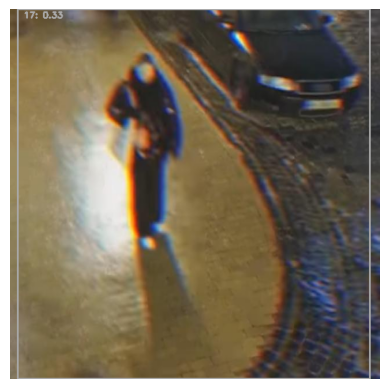

0.66


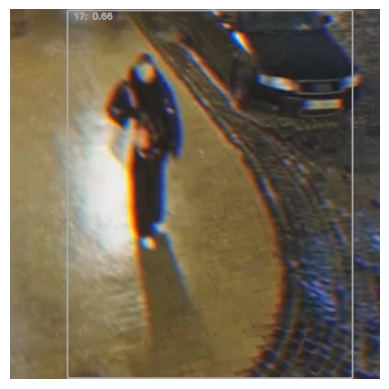

In [123]:
# 生成检测框图像
image_with_boxes = draw_boxes(image, outputs, class_range)

# 显示图像
plt.imshow(cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

image_with_boxes = draw_boxes(image, outputs_adv, class_range)

plt.imshow(cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

In [124]:
image_path = '/content/drive/My Drive/2024 Fall/COMS 6730/Projects/Person-Detection-YOLOV8N-Dectection/test/images/557_png.rf.8f5abb75a4102fc16dbaf19279e33389.jpg'
image = cv2.imread(image_path)

outputs = model(image)

# 将图像和标签转换为 Tensor
images = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0).to(device) / 255.0
labels = torch.tensor([0]).to(device)

# 生成对抗样本
print("Generating adversarial examples...")
images_adv = pgd_attack(model, images, epsilon, alpha, num_iter)

# 使用对抗样本进行预测
outputs_adv = model(images_adv)


0: 640x640 1 elevator, 2 persons, 7.6ms
Speed: 1.9ms preprocess, 7.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.5ms
Speed: 0.0ms preprocess, 7.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.4ms
Speed: 0.0ms preprocess, 9.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.4ms
Speed: 0.0ms preprocess, 9.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.4ms
Speed: 0.0ms preprocess, 9.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.4ms
Speed: 0.0ms preprocess, 9.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.4ms
Speed: 0.0ms preprocess, 9.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.4ms
Speed: 0.0ms preprocess, 9.4ms inference, 1.9ms postprocess per image at shape (1, 3,

Generating adversarial examples...
Iteration 1/100, Loss: 0.09936964511871338
Iteration 2/100, Loss: 0.07143330574035645
Iteration 3/100, Loss: 0.07143330574035645
Iteration 4/100, Loss: 0.07143330574035645
Iteration 5/100, Loss: 0.07143330574035645
Iteration 6/100, Loss: 0.07143330574035645
Iteration 7/100, Loss: 0.07143330574035645
Iteration 8/100, Loss: 0.07143330574035645
Iteration 9/100, Loss: 0.07143330574035645
Iteration 10/100, Loss: 0.07143330574035645
Iteration 11/100, Loss: 0.07143330574035645


0: 640x640 2 persons, 9.4ms
Speed: 0.0ms preprocess, 9.4ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.3ms
Speed: 0.0ms preprocess, 9.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.5ms
Speed: 0.0ms preprocess, 8.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.0ms
Speed: 0.0ms preprocess, 8.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.8ms
Speed: 0.0ms preprocess, 7.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.1ms
Speed: 0.0ms preprocess, 8.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.1ms
Speed: 0.0ms preprocess, 8.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.1ms
Speed: 0.0ms preprocess, 8.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



Iteration 12/100, Loss: 0.07143330574035645
Iteration 13/100, Loss: 0.07143330574035645
Iteration 14/100, Loss: 0.07143330574035645
Iteration 15/100, Loss: 0.07143330574035645
Iteration 16/100, Loss: 0.07143330574035645
Iteration 17/100, Loss: 0.07143330574035645
Iteration 18/100, Loss: 0.07143330574035645
Iteration 19/100, Loss: 0.07143330574035645
Iteration 20/100, Loss: 0.07143330574035645
Iteration 21/100, Loss: 0.07143330574035645
Iteration 22/100, Loss: 0.07143330574035645
Iteration 23/100, Loss: 0.07143330574035645
Iteration 24/100, Loss: 0.07143330574035645


0: 640x640 2 persons, 9.5ms
Speed: 0.0ms preprocess, 9.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.9ms
Speed: 0.0ms preprocess, 7.9ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.3ms
Speed: 0.0ms preprocess, 8.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.1ms
Speed: 0.0ms preprocess, 8.1ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.8ms
Speed: 0.0ms preprocess, 8.8ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.7ms
Speed: 0.0ms preprocess, 9.7ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.2ms
Speed: 0.0ms preprocess, 8.2ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.0ms
Speed: 0.0ms preprocess, 9.0ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)



Iteration 25/100, Loss: 0.07143330574035645
Iteration 26/100, Loss: 0.07143330574035645
Iteration 27/100, Loss: 0.07143330574035645
Iteration 28/100, Loss: 0.07143330574035645
Iteration 29/100, Loss: 0.07143330574035645
Iteration 30/100, Loss: 0.07143330574035645
Iteration 31/100, Loss: 0.07143330574035645
Iteration 32/100, Loss: 0.07143330574035645
Iteration 33/100, Loss: 0.07143330574035645
Iteration 34/100, Loss: 0.07143330574035645
Iteration 35/100, Loss: 0.07143330574035645
Iteration 36/100, Loss: 0.07143330574035645
Iteration 37/100, Loss: 0.07143330574035645



0: 640x640 2 persons, 9.7ms
Speed: 0.0ms preprocess, 9.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 10.8ms
Speed: 0.0ms preprocess, 10.8ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.0ms
Speed: 0.0ms preprocess, 8.0ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.5ms
Speed: 0.0ms preprocess, 9.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.7ms
Speed: 0.0ms preprocess, 9.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.2ms
Speed: 0.0ms preprocess, 8.2ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.8ms
Speed: 0.0ms preprocess, 8.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 11.2ms
Speed: 0.0ms preprocess, 11.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 6

Iteration 38/100, Loss: 0.07143330574035645
Iteration 39/100, Loss: 0.07143330574035645
Iteration 40/100, Loss: 0.07143330574035645
Iteration 41/100, Loss: 0.07143330574035645
Iteration 42/100, Loss: 0.07143330574035645
Iteration 43/100, Loss: 0.07143330574035645
Iteration 44/100, Loss: 0.07143330574035645
Iteration 45/100, Loss: 0.07143330574035645
Iteration 46/100, Loss: 0.07143330574035645
Iteration 47/100, Loss: 0.07143330574035645
Iteration 48/100, Loss: 0.07143330574035645
Iteration 49/100, Loss: 0.07143330574035645


0: 640x640 2 persons, 9.3ms
Speed: 0.0ms preprocess, 9.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.9ms
Speed: 0.0ms preprocess, 7.9ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.8ms
Speed: 0.0ms preprocess, 9.8ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.3ms
Speed: 0.0ms preprocess, 8.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.2ms
Speed: 0.0ms preprocess, 8.2ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.4ms
Speed: 0.0ms preprocess, 8.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.3ms
Speed: 0.0ms preprocess, 8.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.2ms
Speed: 0.0ms preprocess, 9.2ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)



Iteration 50/100, Loss: 0.07143330574035645
Iteration 51/100, Loss: 0.07143330574035645
Iteration 52/100, Loss: 0.07143330574035645
Iteration 53/100, Loss: 0.07143330574035645
Iteration 54/100, Loss: 0.07143330574035645
Iteration 55/100, Loss: 0.07143330574035645
Iteration 56/100, Loss: 0.07143330574035645
Iteration 57/100, Loss: 0.07143330574035645
Iteration 58/100, Loss: 0.07143330574035645
Iteration 59/100, Loss: 0.07143330574035645
Iteration 60/100, Loss: 0.07143330574035645
Iteration 61/100, Loss: 0.07143330574035645


0: 640x640 2 persons, 7.8ms
Speed: 0.0ms preprocess, 7.8ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 10.6ms
Speed: 0.0ms preprocess, 10.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.1ms
Speed: 0.0ms preprocess, 9.1ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 11.2ms
Speed: 0.0ms preprocess, 11.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.5ms
Speed: 0.0ms preprocess, 8.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 11.2ms
Speed: 0.0ms preprocess, 11.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.0ms
Speed: 0.1ms preprocess, 9.0ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 10.8ms
Speed: 0.0ms preprocess, 10.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640

Iteration 62/100, Loss: 0.07143330574035645
Iteration 63/100, Loss: 0.07143330574035645
Iteration 64/100, Loss: 0.07143330574035645
Iteration 65/100, Loss: 0.07143330574035645
Iteration 66/100, Loss: 0.07143330574035645
Iteration 67/100, Loss: 0.07143330574035645
Iteration 68/100, Loss: 0.07143330574035645
Iteration 69/100, Loss: 0.07143330574035645
Iteration 70/100, Loss: 0.07143330574035645
Iteration 71/100, Loss: 0.07143330574035645
Iteration 72/100, Loss: 0.07143330574035645
Iteration 73/100, Loss: 0.07143330574035645


0: 640x640 2 persons, 8.8ms
Speed: 0.0ms preprocess, 8.8ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.4ms
Speed: 0.0ms preprocess, 9.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.5ms
Speed: 0.0ms preprocess, 8.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.0ms
Speed: 0.0ms preprocess, 8.0ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.1ms
Speed: 0.0ms preprocess, 9.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 10.7ms
Speed: 0.0ms preprocess, 10.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.6ms
Speed: 0.0ms preprocess, 8.6ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.1ms
Speed: 0.0ms preprocess, 8.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

Iteration 74/100, Loss: 0.07143330574035645
Iteration 75/100, Loss: 0.07143330574035645
Iteration 76/100, Loss: 0.07143330574035645
Iteration 77/100, Loss: 0.07143330574035645
Iteration 78/100, Loss: 0.07143330574035645
Iteration 79/100, Loss: 0.07143330574035645
Iteration 80/100, Loss: 0.07143330574035645
Iteration 81/100, Loss: 0.07143330574035645
Iteration 82/100, Loss: 0.07143330574035645
Iteration 83/100, Loss: 0.07143330574035645
Iteration 84/100, Loss: 0.07143330574035645
Iteration 85/100, Loss: 0.07143330574035645


0: 640x640 2 persons, 10.8ms
Speed: 0.0ms preprocess, 10.8ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.2ms
Speed: 0.0ms preprocess, 9.2ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.3ms
Speed: 0.0ms preprocess, 9.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.9ms
Speed: 0.0ms preprocess, 8.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.3ms
Speed: 0.0ms preprocess, 8.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.0ms
Speed: 0.0ms preprocess, 9.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.4ms
Speed: 0.0ms preprocess, 9.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.5ms
Speed: 0.0ms preprocess, 8.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

Iteration 86/100, Loss: 0.07143330574035645
Iteration 87/100, Loss: 0.07143330574035645
Iteration 88/100, Loss: 0.07143330574035645
Iteration 89/100, Loss: 0.07143330574035645
Iteration 90/100, Loss: 0.07143330574035645
Iteration 91/100, Loss: 0.07143330574035645
Iteration 92/100, Loss: 0.07143330574035645
Iteration 93/100, Loss: 0.07143330574035645
Iteration 94/100, Loss: 0.07143330574035645
Iteration 95/100, Loss: 0.07143330574035645
Iteration 96/100, Loss: 0.07143330574035645
Iteration 97/100, Loss: 0.07143330574035645


0: 640x640 2 persons, 8.2ms
Speed: 0.0ms preprocess, 8.2ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.4ms
Speed: 0.0ms preprocess, 8.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.1ms
Speed: 0.0ms preprocess, 8.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 11.3ms
Speed: 0.0ms preprocess, 11.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Iteration 98/100, Loss: 0.07143330574035645
Iteration 99/100, Loss: 0.07143330574035645
Iteration 100/100, Loss: 0.07143330574035645


0.75
0.68
0.65


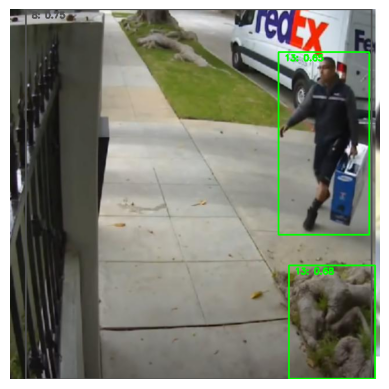

0.27
0.26


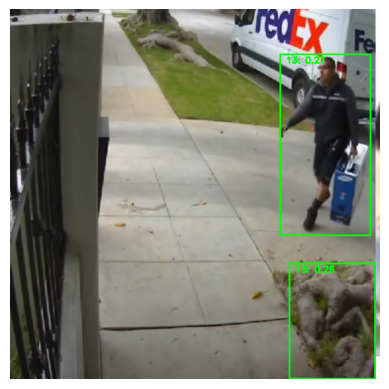

In [125]:
# 生成检测框图像
image_with_boxes = draw_boxes(image, outputs, class_range)

# 显示图像
plt.imshow(cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

image_with_boxes = draw_boxes(image, outputs_adv, class_range)

plt.imshow(cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

In [126]:
image_path = '/content/drive/My Drive/2024 Fall/COMS 6730/Projects/Person-Detection-YOLOV8N-Dectection/test/images/555_png.rf.446202f35c08bcb3670180cf46677a2a.jpg'
image = cv2.imread(image_path)

outputs = model(image)

# 将图像和标签转换为 Tensor
images = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0).to(device) / 255.0
labels = torch.tensor([0]).to(device)

# 生成对抗样本
print("Generating adversarial examples...")
images_adv = pgd_attack(model, images, epsilon, alpha, num_iter)

# 使用对抗样本进行预测
outputs_adv = model(images_adv)


0: 640x640 1 person, 8.3ms
Speed: 2.9ms preprocess, 8.3ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 7.5ms
Speed: 0.0ms preprocess, 7.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 7.5ms
Speed: 0.0ms preprocess, 7.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 7.6ms
Speed: 0.0ms preprocess, 7.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 7.5ms
Speed: 0.0ms preprocess, 7.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 7.5ms
Speed: 0.0ms preprocess, 7.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 7.5ms
Speed: 0.0ms preprocess, 7.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 7.9ms
Speed: 0.0ms preprocess, 7.9ms inference, 1.5ms postpro

Generating adversarial examples...
Iteration 1: No objects detected, skipping.
Iteration 2: No objects detected, skipping.
Iteration 3: No objects detected, skipping.
Iteration 4: No objects detected, skipping.
Iteration 5: No objects detected, skipping.
Iteration 6: No objects detected, skipping.
Iteration 7: No objects detected, skipping.
Iteration 8: No objects detected, skipping.
Iteration 9: No objects detected, skipping.
Iteration 10: No objects detected, skipping.
Iteration 11: No objects detected, skipping.
Iteration 12: No objects detected, skipping.
Iteration 13: No objects detected, skipping.
Iteration 14: No objects detected, skipping.


0: 640x640 (no detections), 7.6ms
Speed: 0.0ms preprocess, 7.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 6.8ms
Speed: 0.0ms preprocess, 6.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 6.7ms
Speed: 0.0ms preprocess, 6.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 8.3ms
Speed: 0.0ms preprocess, 8.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.0ms
Speed: 0.0ms preprocess, 9.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 6.7ms
Speed: 0.0ms preprocess, 6.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 7.4ms
Speed: 0.0ms preprocess, 7.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 7.4ms
Speed: 0.0ms preprocess, 7.4ms inference, 1.5ms p

Iteration 15: No objects detected, skipping.
Iteration 16: No objects detected, skipping.
Iteration 17: No objects detected, skipping.
Iteration 18: No objects detected, skipping.
Iteration 19: No objects detected, skipping.
Iteration 20: No objects detected, skipping.
Iteration 21: No objects detected, skipping.
Iteration 22: No objects detected, skipping.
Iteration 23: No objects detected, skipping.
Iteration 24: No objects detected, skipping.
Iteration 25: No objects detected, skipping.
Iteration 26: No objects detected, skipping.
Iteration 27: No objects detected, skipping.
Iteration 28: No objects detected, skipping.
Iteration 29: No objects detected, skipping.


0: 640x640 (no detections), 7.4ms
Speed: 0.0ms preprocess, 7.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 6.8ms
Speed: 0.0ms preprocess, 6.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 7.3ms
Speed: 0.0ms preprocess, 7.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 8.0ms
Speed: 0.0ms preprocess, 8.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 8.5ms
Speed: 0.0ms preprocess, 8.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 7.8ms
Speed: 0.0ms preprocess, 7.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 6.4ms
Speed: 0.0ms preprocess, 6.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 7.3ms
Speed: 0.0ms preprocess, 7.3ms inference, 1.5ms p

Iteration 30: No objects detected, skipping.
Iteration 31: No objects detected, skipping.
Iteration 32: No objects detected, skipping.
Iteration 33: No objects detected, skipping.
Iteration 34: No objects detected, skipping.
Iteration 35: No objects detected, skipping.
Iteration 36: No objects detected, skipping.
Iteration 37: No objects detected, skipping.
Iteration 38: No objects detected, skipping.
Iteration 39: No objects detected, skipping.
Iteration 40: No objects detected, skipping.
Iteration 41: No objects detected, skipping.
Iteration 42: No objects detected, skipping.
Iteration 43: No objects detected, skipping.
Iteration 44: No objects detected, skipping.


0: 640x640 (no detections), 7.3ms
Speed: 0.0ms preprocess, 7.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 7.7ms
Speed: 0.0ms preprocess, 7.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 6.4ms
Speed: 0.0ms preprocess, 6.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 8.3ms
Speed: 0.0ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 6.4ms
Speed: 0.0ms preprocess, 6.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 6.6ms
Speed: 0.0ms preprocess, 6.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 8.6ms
Speed: 0.0ms preprocess, 8.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 6.7ms
Speed: 0.0ms preprocess, 6.7ms inference, 1.2ms p

Iteration 45: No objects detected, skipping.
Iteration 46: No objects detected, skipping.
Iteration 47: No objects detected, skipping.
Iteration 48: No objects detected, skipping.
Iteration 49: No objects detected, skipping.
Iteration 50: No objects detected, skipping.
Iteration 51: No objects detected, skipping.
Iteration 52: No objects detected, skipping.
Iteration 53: No objects detected, skipping.
Iteration 54: No objects detected, skipping.
Iteration 55: No objects detected, skipping.
Iteration 56: No objects detected, skipping.
Iteration 57: No objects detected, skipping.
Iteration 58: No objects detected, skipping.
Iteration 59: No objects detected, skipping.


0: 640x640 (no detections), 7.8ms
Speed: 0.0ms preprocess, 7.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 6.2ms
Speed: 0.0ms preprocess, 6.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 8.1ms
Speed: 0.0ms preprocess, 8.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 6.8ms
Speed: 0.0ms preprocess, 6.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 6.4ms
Speed: 0.0ms preprocess, 6.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 8.3ms
Speed: 0.0ms preprocess, 8.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 7.2ms
Speed: 0.0ms preprocess, 7.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 7.1ms
Speed: 0.0ms preprocess, 7.1ms inference, 1.5ms p

Iteration 60: No objects detected, skipping.
Iteration 61: No objects detected, skipping.
Iteration 62: No objects detected, skipping.
Iteration 63: No objects detected, skipping.
Iteration 64: No objects detected, skipping.
Iteration 65: No objects detected, skipping.
Iteration 66: No objects detected, skipping.
Iteration 67: No objects detected, skipping.
Iteration 68: No objects detected, skipping.
Iteration 69: No objects detected, skipping.
Iteration 70: No objects detected, skipping.
Iteration 71: No objects detected, skipping.
Iteration 72: No objects detected, skipping.
Iteration 73: No objects detected, skipping.
Iteration 74: No objects detected, skipping.


0: 640x640 (no detections), 11.8ms
Speed: 0.0ms preprocess, 11.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 6.4ms
Speed: 0.0ms preprocess, 6.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 6.6ms
Speed: 0.0ms preprocess, 6.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 7.8ms
Speed: 0.0ms preprocess, 7.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 6.7ms
Speed: 0.1ms preprocess, 6.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 6.9ms
Speed: 0.0ms preprocess, 6.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 7.2ms
Speed: 0.0ms preprocess, 7.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 6.9ms
Speed: 0.0ms preprocess, 6.9ms inference, 1.3ms

Iteration 75: No objects detected, skipping.
Iteration 76: No objects detected, skipping.
Iteration 77: No objects detected, skipping.
Iteration 78: No objects detected, skipping.
Iteration 79: No objects detected, skipping.
Iteration 80: No objects detected, skipping.
Iteration 81: No objects detected, skipping.
Iteration 82: No objects detected, skipping.
Iteration 83: No objects detected, skipping.
Iteration 84: No objects detected, skipping.
Iteration 85: No objects detected, skipping.
Iteration 86: No objects detected, skipping.
Iteration 87: No objects detected, skipping.
Iteration 88: No objects detected, skipping.
Iteration 89: No objects detected, skipping.


0: 640x640 (no detections), 8.9ms
Speed: 0.0ms preprocess, 8.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 6.7ms
Speed: 0.0ms preprocess, 6.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 8.4ms
Speed: 0.0ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 7.1ms
Speed: 0.0ms preprocess, 7.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 7.4ms
Speed: 0.0ms preprocess, 7.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 6.6ms
Speed: 0.0ms preprocess, 6.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 8.4ms
Speed: 0.0ms preprocess, 8.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 6.3ms
Speed: 0.0ms preprocess, 6.3ms inference, 1.3ms p

Iteration 90: No objects detected, skipping.
Iteration 91: No objects detected, skipping.
Iteration 92: No objects detected, skipping.
Iteration 93: No objects detected, skipping.
Iteration 94: No objects detected, skipping.
Iteration 95: No objects detected, skipping.
Iteration 96: No objects detected, skipping.
Iteration 97: No objects detected, skipping.
Iteration 98: No objects detected, skipping.
Iteration 99: No objects detected, skipping.
Iteration 100: No objects detected, skipping.


0.41


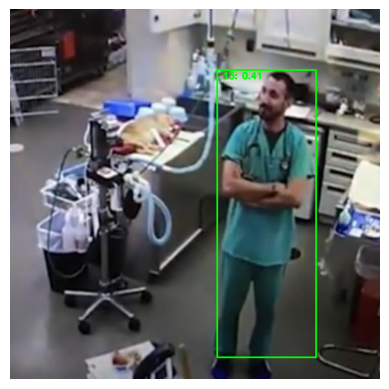

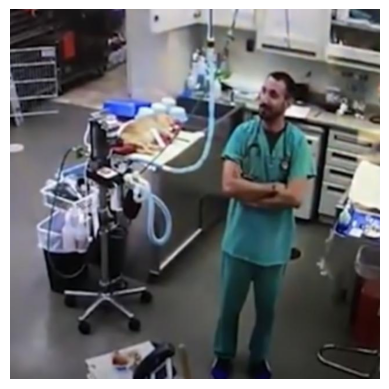

In [127]:
# 生成检测框图像
image_with_boxes = draw_boxes(image, outputs, class_range)

# 显示图像
plt.imshow(cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

image_with_boxes = draw_boxes(image, outputs_adv, class_range)

plt.imshow(cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

In [131]:
image_path = '/content/drive/My Drive/2024 Fall/COMS 6730/Projects/Senior-Design-VIAD/test/images/0b2f8a24c937aa78_jpg.rf.1e13f040d4c4b02bc6c101e3cfee0981.jpg'
image = cv2.imread(image_path)

outputs = model(image)

# 将图像和标签转换为 Tensor
# images = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0).to(device) / 255.0
# labels = torch.tensor([0]).to(device)
images = preprocess_image(image, size=(640, 640))

# 生成对抗样本
print("Generating adversarial examples...")
images_adv = pgd_attack(model, images, epsilon, alpha, num_iter)

# 使用对抗样本进行预测
outputs_adv = model(images_adv)


0: 640x640 7 persons, 8.7ms
Speed: 4.0ms preprocess, 8.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 persons, 7.5ms
Speed: 1.2ms preprocess, 7.5ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 persons, 9.6ms
Speed: 1.2ms preprocess, 9.6ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 persons, 9.5ms
Speed: 1.3ms preprocess, 9.5ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 persons, 9.5ms
Speed: 1.2ms preprocess, 9.5ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 persons, 9.6ms
Speed: 1.3ms preprocess, 9.6ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 persons, 9.4ms
Speed: 1.3ms preprocess, 9.4ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 persons, 10.0ms
Speed: 1.3ms preprocess, 10.0ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640

Generating adversarial examples...
Iteration 1/100, Loss: -0.012934625148773193
Iteration 2/100, Loss: -0.10911053419113159
Iteration 3/100, Loss: -0.10911053419113159
Iteration 4/100, Loss: -0.10911053419113159
Iteration 5/100, Loss: -0.10911053419113159
Iteration 6/100, Loss: -0.10911053419113159
Iteration 7/100, Loss: -0.10911053419113159


0: 640x640 6 persons, 10.0ms
Speed: 1.3ms preprocess, 10.0ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 persons, 9.5ms
Speed: 1.3ms preprocess, 9.5ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 persons, 9.6ms
Speed: 1.2ms preprocess, 9.6ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 persons, 9.4ms
Speed: 1.2ms preprocess, 9.4ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 persons, 9.4ms
Speed: 1.2ms preprocess, 9.4ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 persons, 9.4ms
Speed: 1.1ms preprocess, 9.4ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 persons, 9.4ms
Speed: 1.3ms preprocess, 9.4ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 persons, 9.4ms
Speed: 1.2ms preprocess, 9.4ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

Iteration 8/100, Loss: -0.10911053419113159
Iteration 9/100, Loss: -0.10911053419113159
Iteration 10/100, Loss: -0.10911053419113159
Iteration 11/100, Loss: -0.10911053419113159
Iteration 12/100, Loss: -0.10911053419113159
Iteration 13/100, Loss: -0.10911053419113159
Iteration 14/100, Loss: -0.10911053419113159
Iteration 15/100, Loss: -0.10911053419113159


0: 640x640 6 persons, 10.1ms
Speed: 1.3ms preprocess, 10.1ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 persons, 9.4ms
Speed: 1.2ms preprocess, 9.4ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 persons, 9.4ms
Speed: 1.2ms preprocess, 9.4ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 persons, 9.4ms
Speed: 1.2ms preprocess, 9.4ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 persons, 10.0ms
Speed: 1.2ms preprocess, 10.0ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 persons, 9.5ms
Speed: 1.2ms preprocess, 9.5ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 persons, 9.4ms
Speed: 1.3ms preprocess, 9.4ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 persons, 12.1ms
Speed: 1.2ms preprocess, 12.1ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 

Iteration 16/100, Loss: -0.10911053419113159
Iteration 17/100, Loss: -0.10911053419113159
Iteration 18/100, Loss: -0.10911053419113159
Iteration 19/100, Loss: -0.10911053419113159
Iteration 20/100, Loss: -0.10911053419113159
Iteration 21/100, Loss: -0.10911053419113159
Iteration 22/100, Loss: -0.10911053419113159
Iteration 23/100, Loss: -0.10911053419113159


0: 640x640 6 persons, 10.9ms
Speed: 1.2ms preprocess, 10.9ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 persons, 9.5ms
Speed: 1.2ms preprocess, 9.5ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 persons, 9.5ms
Speed: 1.3ms preprocess, 9.5ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 persons, 9.4ms
Speed: 1.1ms preprocess, 9.4ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 persons, 9.4ms
Speed: 1.1ms preprocess, 9.4ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 persons, 9.4ms
Speed: 1.1ms preprocess, 9.4ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 persons, 9.6ms
Speed: 1.2ms preprocess, 9.6ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 persons, 9.5ms
Speed: 1.2ms preprocess, 9.5ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

Iteration 24/100, Loss: -0.10911053419113159
Iteration 25/100, Loss: -0.10911053419113159
Iteration 26/100, Loss: -0.10911053419113159
Iteration 27/100, Loss: -0.10911053419113159
Iteration 28/100, Loss: -0.10911053419113159
Iteration 29/100, Loss: -0.10911053419113159
Iteration 30/100, Loss: -0.10911053419113159
Iteration 31/100, Loss: -0.10911053419113159


0: 640x640 6 persons, 10.8ms
Speed: 1.2ms preprocess, 10.8ms inference, 3.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 persons, 9.4ms
Speed: 1.2ms preprocess, 9.4ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 persons, 9.9ms
Speed: 1.2ms preprocess, 9.9ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 persons, 9.5ms
Speed: 1.3ms preprocess, 9.5ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 persons, 9.5ms
Speed: 1.3ms preprocess, 9.5ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 persons, 10.7ms
Speed: 1.3ms preprocess, 10.7ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 persons, 9.8ms
Speed: 1.3ms preprocess, 9.8ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 persons, 9.4ms
Speed: 1.3ms preprocess, 9.4ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 64

Iteration 32/100, Loss: -0.10911053419113159
Iteration 33/100, Loss: -0.10911053419113159
Iteration 34/100, Loss: -0.10911053419113159
Iteration 35/100, Loss: -0.10911053419113159
Iteration 36/100, Loss: -0.10911053419113159
Iteration 37/100, Loss: -0.10911053419113159
Iteration 38/100, Loss: -0.10911053419113159
Iteration 39/100, Loss: -0.10911053419113159


0: 640x640 6 persons, 10.1ms
Speed: 1.2ms preprocess, 10.1ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 persons, 9.5ms
Speed: 1.2ms preprocess, 9.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 persons, 9.5ms
Speed: 1.2ms preprocess, 9.5ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 persons, 10.7ms
Speed: 1.3ms preprocess, 10.7ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 persons, 10.0ms
Speed: 1.3ms preprocess, 10.0ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 persons, 9.5ms
Speed: 1.3ms preprocess, 9.5ms inference, 4.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 persons, 9.5ms
Speed: 1.2ms preprocess, 9.5ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 persons, 9.5ms
Speed: 1.2ms preprocess, 9.5ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 

Iteration 40/100, Loss: -0.10911053419113159
Iteration 41/100, Loss: -0.10911053419113159
Iteration 42/100, Loss: -0.10911053419113159
Iteration 43/100, Loss: -0.10911053419113159
Iteration 44/100, Loss: -0.10911053419113159
Iteration 45/100, Loss: -0.10911053419113159
Iteration 46/100, Loss: -0.10911053419113159
Iteration 47/100, Loss: -0.10911053419113159



0: 640x640 6 persons, 9.5ms
Speed: 1.1ms preprocess, 9.5ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 persons, 11.5ms
Speed: 1.3ms preprocess, 11.5ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 persons, 9.5ms
Speed: 1.2ms preprocess, 9.5ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 persons, 9.5ms
Speed: 1.2ms preprocess, 9.5ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 persons, 10.8ms
Speed: 1.2ms preprocess, 10.8ms inference, 3.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 persons, 9.5ms
Speed: 1.3ms preprocess, 9.5ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 persons, 10.4ms
Speed: 1.2ms preprocess, 10.4ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 persons, 9.5ms
Speed: 1.2ms preprocess, 9.5ms inference, 2.9ms postprocess per image at shape (1, 3, 640,

Iteration 48/100, Loss: -0.10911053419113159
Iteration 49/100, Loss: -0.10911053419113159
Iteration 50/100, Loss: -0.10911053419113159
Iteration 51/100, Loss: -0.10911053419113159
Iteration 52/100, Loss: -0.10911053419113159
Iteration 53/100, Loss: -0.10911053419113159
Iteration 54/100, Loss: -0.10911053419113159



0: 640x640 6 persons, 9.5ms
Speed: 1.1ms preprocess, 9.5ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 persons, 11.3ms
Speed: 1.3ms preprocess, 11.3ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 persons, 10.8ms
Speed: 1.3ms preprocess, 10.8ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 persons, 9.5ms
Speed: 1.2ms preprocess, 9.5ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 persons, 11.3ms
Speed: 1.3ms preprocess, 11.3ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 persons, 10.6ms
Speed: 1.3ms preprocess, 10.6ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 persons, 11.5ms
Speed: 1.3ms preprocess, 11.5ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)


Iteration 55/100, Loss: -0.10911053419113159
Iteration 56/100, Loss: -0.10911053419113159
Iteration 57/100, Loss: -0.10911053419113159
Iteration 58/100, Loss: -0.10911053419113159
Iteration 59/100, Loss: -0.10911053419113159
Iteration 60/100, Loss: -0.10911053419113159
Iteration 61/100, Loss: -0.10911053419113159
Iteration 62/100, Loss: -0.10911053419113159



0: 640x640 6 persons, 9.5ms
Speed: 1.2ms preprocess, 9.5ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 persons, 10.2ms
Speed: 1.4ms preprocess, 10.2ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 persons, 10.8ms
Speed: 1.2ms preprocess, 10.8ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 persons, 9.6ms
Speed: 1.3ms preprocess, 9.6ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 persons, 10.4ms
Speed: 1.3ms preprocess, 10.4ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 persons, 9.5ms
Speed: 1.2ms preprocess, 9.5ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 persons, 9.5ms
Speed: 1.2ms preprocess, 9.5ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 persons, 9.4ms
Speed: 1.1ms preprocess, 9.4ms inference, 2.6ms postprocess per image at shape (1, 3, 640,

Iteration 63/100, Loss: -0.10911053419113159
Iteration 64/100, Loss: -0.10911053419113159
Iteration 65/100, Loss: -0.10911053419113159
Iteration 66/100, Loss: -0.10911053419113159
Iteration 67/100, Loss: -0.10911053419113159
Iteration 68/100, Loss: -0.10911053419113159
Iteration 69/100, Loss: -0.10911053419113159
Iteration 70/100, Loss: -0.10911053419113159


0: 640x640 6 persons, 9.5ms
Speed: 1.2ms preprocess, 9.5ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 persons, 9.4ms
Speed: 1.2ms preprocess, 9.4ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 persons, 9.5ms
Speed: 1.2ms preprocess, 9.5ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 persons, 9.6ms
Speed: 1.3ms preprocess, 9.6ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 persons, 10.6ms
Speed: 1.3ms preprocess, 10.6ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 persons, 9.5ms
Speed: 1.3ms preprocess, 9.5ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 persons, 9.5ms
Speed: 1.3ms preprocess, 9.5ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 persons, 9.5ms
Speed: 1.3ms preprocess, 9.5ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

Iteration 71/100, Loss: -0.10911053419113159
Iteration 72/100, Loss: -0.10911053419113159
Iteration 73/100, Loss: -0.10911053419113159
Iteration 74/100, Loss: -0.10911053419113159
Iteration 75/100, Loss: -0.10911053419113159
Iteration 76/100, Loss: -0.10911053419113159
Iteration 77/100, Loss: -0.10911053419113159
Iteration 78/100, Loss: -0.10911053419113159


0: 640x640 6 persons, 10.4ms
Speed: 1.2ms preprocess, 10.4ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 persons, 9.5ms
Speed: 1.2ms preprocess, 9.5ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 persons, 9.5ms
Speed: 1.2ms preprocess, 9.5ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 persons, 9.8ms
Speed: 1.2ms preprocess, 9.8ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 persons, 9.4ms
Speed: 1.3ms preprocess, 9.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 persons, 9.4ms
Speed: 1.3ms preprocess, 9.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 persons, 9.6ms
Speed: 1.3ms preprocess, 9.6ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 persons, 9.4ms
Speed: 1.3ms preprocess, 9.4ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

Iteration 79/100, Loss: -0.10911053419113159
Iteration 80/100, Loss: -0.10911053419113159
Iteration 81/100, Loss: -0.10911053419113159
Iteration 82/100, Loss: -0.10911053419113159
Iteration 83/100, Loss: -0.10911053419113159
Iteration 84/100, Loss: -0.10911053419113159
Iteration 85/100, Loss: -0.10911053419113159
Iteration 86/100, Loss: -0.10911053419113159



0: 640x640 6 persons, 9.5ms
Speed: 1.3ms preprocess, 9.5ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 persons, 9.2ms
Speed: 1.3ms preprocess, 9.2ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 persons, 9.2ms
Speed: 1.3ms preprocess, 9.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 persons, 9.5ms
Speed: 1.2ms preprocess, 9.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 persons, 9.3ms
Speed: 1.2ms preprocess, 9.3ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 persons, 9.3ms
Speed: 1.2ms preprocess, 9.3ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 persons, 9.3ms
Speed: 1.2ms preprocess, 9.3ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 persons, 9.3ms


Iteration 87/100, Loss: -0.10911053419113159
Iteration 88/100, Loss: -0.10911053419113159
Iteration 89/100, Loss: -0.10911053419113159
Iteration 90/100, Loss: -0.10911053419113159
Iteration 91/100, Loss: -0.10911053419113159
Iteration 92/100, Loss: -0.10911053419113159
Iteration 93/100, Loss: -0.10911053419113159
Iteration 94/100, Loss: -0.10911053419113159


Speed: 1.3ms preprocess, 9.3ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 persons, 9.4ms
Speed: 1.2ms preprocess, 9.4ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 persons, 9.3ms
Speed: 1.3ms preprocess, 9.3ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 persons, 9.3ms
Speed: 1.2ms preprocess, 9.3ms inference, 4.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 persons, 9.3ms
Speed: 1.2ms preprocess, 9.3ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 persons, 9.4ms
Speed: 1.3ms preprocess, 9.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 persons, 10.1ms
Speed: 1.4ms preprocess, 10.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


Iteration 95/100, Loss: -0.10911053419113159
Iteration 96/100, Loss: -0.10911053419113159
Iteration 97/100, Loss: -0.10911053419113159
Iteration 98/100, Loss: -0.10911053419113159
Iteration 99/100, Loss: -0.10911053419113159
Iteration 100/100, Loss: -0.10911053419113159


0.37
0.37
0.36
0.35
0.32
0.31
0.27


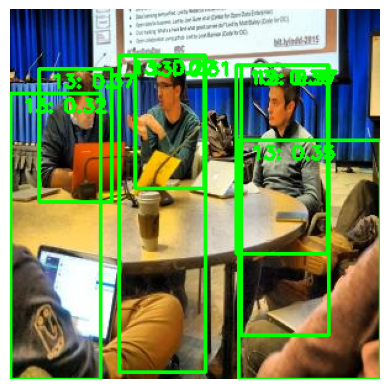

0.72
0.56
0.40
0.39
0.38
0.30


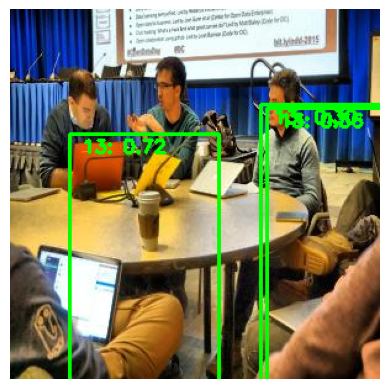

In [132]:
# 生成检测框图像
image_with_boxes = draw_boxes(image, outputs, class_range)

# 显示图像
plt.imshow(cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

image_with_boxes = draw_boxes(image, outputs_adv, class_range)

plt.imshow(cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

In [51]:
image_path = '/content/drive/My Drive/2024 Fall/COMS 6730/Projects/Person-Detection-YOLOV8N-Dectection/test/images/545_png.rf.49ce1de985fff5c22ca5f340decdffdb.jpg'
image = cv2.imread(image_path)

outputs = model(image)

# 将图像和标签转换为 Tensor
images = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0).to(device) / 255.0
labels = torch.tensor([0]).to(device)

# 生成对抗样本
print("Generating adversarial examples...")
images_adv = pgd_attack(model, images, epsilon, alpha, num_iter)

# 使用对抗样本进行预测
outputs_adv = model(images_adv)


0: 640x640 1 car, 7.8ms
Speed: 2.2ms preprocess, 7.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 cars, 7.5ms
Speed: 0.0ms preprocess, 7.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 cars, 7.5ms
Speed: 0.0ms preprocess, 7.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 cars, 7.5ms
Speed: 0.0ms preprocess, 7.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 cars, 7.4ms
Speed: 0.0ms preprocess, 7.4ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 cars, 7.5ms
Speed: 0.0ms preprocess, 7.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 cars, 7.5ms
Speed: 0.0ms preprocess, 7.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 cars, 7.4ms
Speed: 0.0ms preprocess, 7.4ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 cars, 7.6ms

Generating adversarial examples...
Iteration 1: No target class detected, skipping.
Iteration 2: No target class detected, skipping.
Iteration 3: No target class detected, skipping.
Iteration 4: No target class detected, skipping.
Iteration 5: No target class detected, skipping.
Iteration 6: No target class detected, skipping.
Iteration 7: No target class detected, skipping.
Iteration 8: No target class detected, skipping.
Iteration 9: No target class detected, skipping.
Iteration 10: No target class detected, skipping.
Iteration 11: No target class detected, skipping.
Iteration 12: No target class detected, skipping.
Iteration 13: No target class detected, skipping.



0: 640x640 2 cars, 7.4ms
Speed: 0.0ms preprocess, 7.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 cars, 7.5ms
Speed: 0.0ms preprocess, 7.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 cars, 7.4ms
Speed: 0.0ms preprocess, 7.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 cars, 7.4ms
Speed: 0.0ms preprocess, 7.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 cars, 7.5ms
Speed: 0.0ms preprocess, 7.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 cars, 7.5ms
Speed: 0.0ms preprocess, 7.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 cars, 7.5ms
Speed: 0.0ms preprocess, 7.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 cars, 7.5ms
Speed: 0.0ms preprocess, 7.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 cars, 8.3m

Iteration 14: No target class detected, skipping.
Iteration 15: No target class detected, skipping.
Iteration 16: No target class detected, skipping.
Iteration 17: No target class detected, skipping.
Iteration 18: No target class detected, skipping.
Iteration 19: No target class detected, skipping.
Iteration 20: No target class detected, skipping.
Iteration 21: No target class detected, skipping.
Iteration 22: No target class detected, skipping.
Iteration 23: No target class detected, skipping.
Iteration 24: No target class detected, skipping.
Iteration 25: No target class detected, skipping.
Iteration 26: No target class detected, skipping.
Iteration 27: No target class detected, skipping.
Iteration 28: No target class detected, skipping.


0: 640x640 2 cars, 7.0ms
Speed: 0.0ms preprocess, 7.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 cars, 7.0ms
Speed: 0.0ms preprocess, 7.0ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 cars, 6.7ms
Speed: 0.0ms preprocess, 6.7ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 cars, 6.9ms
Speed: 0.0ms preprocess, 6.9ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 cars, 6.1ms
Speed: 0.0ms preprocess, 6.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 cars, 6.3ms
Speed: 0.0ms preprocess, 6.3ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 cars, 6.5ms
Speed: 0.0ms preprocess, 6.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 cars, 6.1ms
Speed: 0.0ms preprocess, 6.1ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 cars, 6.1ms

Iteration 29: No target class detected, skipping.
Iteration 30: No target class detected, skipping.
Iteration 31: No target class detected, skipping.
Iteration 32: No target class detected, skipping.
Iteration 33: No target class detected, skipping.
Iteration 34: No target class detected, skipping.
Iteration 35: No target class detected, skipping.
Iteration 36: No target class detected, skipping.
Iteration 37: No target class detected, skipping.
Iteration 38: No target class detected, skipping.
Iteration 39: No target class detected, skipping.
Iteration 40: No target class detected, skipping.
Iteration 41: No target class detected, skipping.
Iteration 42: No target class detected, skipping.
Iteration 43: No target class detected, skipping.


0: 640x640 2 cars, 7.5ms
Speed: 0.0ms preprocess, 7.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 cars, 6.7ms
Speed: 0.0ms preprocess, 6.7ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 cars, 6.1ms
Speed: 0.0ms preprocess, 6.1ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 cars, 7.5ms
Speed: 0.0ms preprocess, 7.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 cars, 6.4ms
Speed: 0.0ms preprocess, 6.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 cars, 6.8ms
Speed: 0.0ms preprocess, 6.8ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 cars, 6.2ms
Speed: 0.0ms preprocess, 6.2ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 cars, 6.2ms
Speed: 0.0ms preprocess, 6.2ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 cars, 8.7ms

Iteration 44: No target class detected, skipping.
Iteration 45: No target class detected, skipping.
Iteration 46: No target class detected, skipping.
Iteration 47: No target class detected, skipping.
Iteration 48: No target class detected, skipping.
Iteration 49: No target class detected, skipping.
Iteration 50: No target class detected, skipping.
Iteration 51: No target class detected, skipping.
Iteration 52: No target class detected, skipping.
Iteration 53: No target class detected, skipping.
Iteration 54: No target class detected, skipping.
Iteration 55: No target class detected, skipping.
Iteration 56: No target class detected, skipping.
Iteration 57: No target class detected, skipping.
Iteration 58: No target class detected, skipping.


0: 640x640 2 cars, 8.2ms
Speed: 0.0ms preprocess, 8.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 cars, 6.9ms
Speed: 0.0ms preprocess, 6.9ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 cars, 7.6ms
Speed: 0.0ms preprocess, 7.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 cars, 7.6ms
Speed: 0.0ms preprocess, 7.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 cars, 7.6ms
Speed: 0.0ms preprocess, 7.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 cars, 6.5ms
Speed: 0.0ms preprocess, 6.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 cars, 6.4ms
Speed: 0.0ms preprocess, 6.4ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 cars, 6.6ms
Speed: 0.0ms preprocess, 6.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 cars, 8.3ms

Iteration 59: No target class detected, skipping.
Iteration 60: No target class detected, skipping.
Iteration 61: No target class detected, skipping.
Iteration 62: No target class detected, skipping.
Iteration 63: No target class detected, skipping.
Iteration 64: No target class detected, skipping.
Iteration 65: No target class detected, skipping.
Iteration 66: No target class detected, skipping.
Iteration 67: No target class detected, skipping.
Iteration 68: No target class detected, skipping.
Iteration 69: No target class detected, skipping.
Iteration 70: No target class detected, skipping.
Iteration 71: No target class detected, skipping.
Iteration 72: No target class detected, skipping.
Iteration 73: No target class detected, skipping.


0: 640x640 2 cars, 7.1ms
Speed: 0.0ms preprocess, 7.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 cars, 7.1ms
Speed: 0.0ms preprocess, 7.1ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 cars, 6.1ms
Speed: 0.0ms preprocess, 6.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 cars, 6.0ms
Speed: 0.0ms preprocess, 6.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 cars, 8.5ms
Speed: 0.0ms preprocess, 8.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 cars, 7.0ms
Speed: 0.1ms preprocess, 7.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 cars, 6.0ms
Speed: 0.0ms preprocess, 6.0ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 cars, 6.1ms
Speed: 0.0ms preprocess, 6.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 cars, 6.7ms

Iteration 74: No target class detected, skipping.
Iteration 75: No target class detected, skipping.
Iteration 76: No target class detected, skipping.
Iteration 77: No target class detected, skipping.
Iteration 78: No target class detected, skipping.
Iteration 79: No target class detected, skipping.
Iteration 80: No target class detected, skipping.
Iteration 81: No target class detected, skipping.
Iteration 82: No target class detected, skipping.
Iteration 83: No target class detected, skipping.
Iteration 84: No target class detected, skipping.
Iteration 85: No target class detected, skipping.
Iteration 86: No target class detected, skipping.
Iteration 87: No target class detected, skipping.
Iteration 88: No target class detected, skipping.


0: 640x640 2 cars, 7.1ms
Speed: 0.0ms preprocess, 7.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 cars, 7.1ms
Speed: 0.0ms preprocess, 7.1ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 cars, 7.1ms
Speed: 0.0ms preprocess, 7.1ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 cars, 7.7ms
Speed: 0.0ms preprocess, 7.7ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 cars, 6.6ms
Speed: 0.0ms preprocess, 6.6ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 cars, 6.7ms
Speed: 0.0ms preprocess, 6.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 cars, 6.9ms
Speed: 0.0ms preprocess, 6.9ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 cars, 6.5ms
Speed: 0.1ms preprocess, 6.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 cars, 6.8ms

Iteration 89: No target class detected, skipping.
Iteration 90: No target class detected, skipping.
Iteration 91: No target class detected, skipping.
Iteration 92: No target class detected, skipping.
Iteration 93: No target class detected, skipping.
Iteration 94: No target class detected, skipping.
Iteration 95: No target class detected, skipping.
Iteration 96: No target class detected, skipping.
Iteration 97: No target class detected, skipping.
Iteration 98: No target class detected, skipping.
Iteration 99: No target class detected, skipping.
Iteration 100: No target class detected, skipping.


0.51


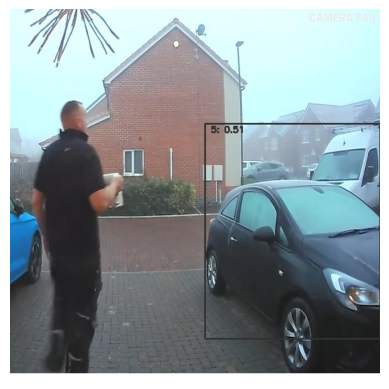

0.45
0.33


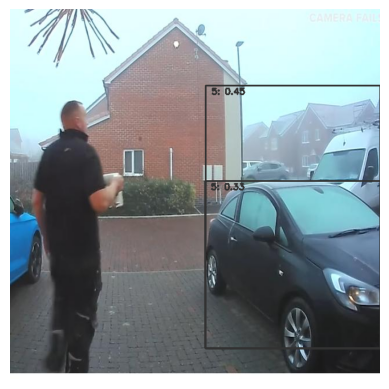

In [52]:
# 生成检测框图像
image_with_boxes = draw_boxes(image, outputs, class_range)

# 显示图像
plt.imshow(cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

image_with_boxes = draw_boxes(image, outputs_adv, class_range)

plt.imshow(cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

In [53]:
image_path = '/content/drive/My Drive/2024 Fall/COMS 6730/Projects/Person-Detection-YOLOV8N-Dectection/test/images/51_png.rf.127d6881ff6b79a0eccaa4998ac8f34b.jpg'
image = cv2.imread(image_path)

outputs = model(image)

# 将图像和标签转换为 Tensor
images = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0).to(device) / 255.0
labels = torch.tensor([0]).to(device)

# 生成对抗样本
print("Generating adversarial examples...")
images_adv = pgd_attack(model, images, epsilon, alpha, num_iter)

# 使用对抗样本进行预测
outputs_adv = model(images_adv)


0: 640x640 1 person, 8.3ms
Speed: 1.8ms preprocess, 8.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.5ms
Speed: 0.0ms preprocess, 7.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.4ms
Speed: 0.0ms preprocess, 9.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.4ms
Speed: 0.0ms preprocess, 9.4ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.3ms
Speed: 0.0ms preprocess, 9.3ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.4ms
Speed: 0.0ms preprocess, 9.4ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.4ms
Speed: 0.0ms preprocess, 9.4ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.3ms
Speed: 0.0ms preprocess, 9.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x

Generating adversarial examples...
Iteration 1/100, Loss: -0.24874746799468994
Iteration 2/100, Loss: -0.2933976352214813
Iteration 3/100, Loss: -0.2933976352214813
Iteration 4/100, Loss: -0.2933976352214813
Iteration 5/100, Loss: -0.2933976352214813
Iteration 6/100, Loss: -0.2933976352214813
Iteration 7/100, Loss: -0.2933976352214813
Iteration 8/100, Loss: -0.2933976352214813
Iteration 9/100, Loss: -0.2933976352214813
Iteration 10/100, Loss: -0.2933976352214813
Iteration 11/100, Loss: -0.2933976352214813
Iteration 12/100, Loss: -0.2933976352214813


0: 640x640 1 person, 10.3ms
Speed: 0.1ms preprocess, 10.3ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.4ms
Speed: 0.0ms preprocess, 9.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.3ms
Speed: 0.0ms preprocess, 9.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 0.0ms preprocess, 8.2ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.7ms
Speed: 0.0ms preprocess, 7.7ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.6ms
Speed: 0.0ms preprocess, 7.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.6ms
Speed: 0.0ms preprocess, 7.6ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 0.0ms preprocess, 8.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640

Iteration 13/100, Loss: -0.2933976352214813
Iteration 14/100, Loss: -0.2933976352214813
Iteration 15/100, Loss: -0.2933976352214813
Iteration 16/100, Loss: -0.2933976352214813
Iteration 17/100, Loss: -0.2933976352214813
Iteration 18/100, Loss: -0.2933976352214813
Iteration 19/100, Loss: -0.2933976352214813
Iteration 20/100, Loss: -0.2933976352214813
Iteration 21/100, Loss: -0.2933976352214813
Iteration 22/100, Loss: -0.2933976352214813
Iteration 23/100, Loss: -0.2933976352214813
Iteration 24/100, Loss: -0.2933976352214813
Iteration 25/100, Loss: -0.2933976352214813



0: 640x640 1 person, 7.8ms
Speed: 0.0ms preprocess, 7.8ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.6ms
Speed: 0.0ms preprocess, 7.6ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.4ms
Speed: 0.0ms preprocess, 7.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.6ms
Speed: 0.0ms preprocess, 7.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.5ms
Speed: 0.0ms preprocess, 7.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.3ms
Speed: 0.0ms preprocess, 9.3ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 0.0ms preprocess, 8.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.6ms
Speed: 0.0ms preprocess, 7.6ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x

Iteration 26/100, Loss: -0.2933976352214813
Iteration 27/100, Loss: -0.2933976352214813
Iteration 28/100, Loss: -0.2933976352214813
Iteration 29/100, Loss: -0.2933976352214813
Iteration 30/100, Loss: -0.2933976352214813
Iteration 31/100, Loss: -0.2933976352214813
Iteration 32/100, Loss: -0.2933976352214813
Iteration 33/100, Loss: -0.2933976352214813
Iteration 34/100, Loss: -0.2933976352214813
Iteration 35/100, Loss: -0.2933976352214813
Iteration 36/100, Loss: -0.2933976352214813
Iteration 37/100, Loss: -0.2933976352214813
Iteration 38/100, Loss: -0.2933976352214813
Iteration 39/100, Loss: -0.2933976352214813


0: 640x640 1 person, 7.6ms
Speed: 0.0ms preprocess, 7.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 0.0ms preprocess, 8.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 0.0ms preprocess, 7.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 0.0ms preprocess, 8.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 0.0ms preprocess, 8.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 0.0ms preprocess, 8.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 0.0ms preprocess, 7.8ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.7ms
Speed: 0.0ms preprocess, 7.7ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x6

Iteration 40/100, Loss: -0.2933976352214813
Iteration 41/100, Loss: -0.2933976352214813
Iteration 42/100, Loss: -0.2933976352214813
Iteration 43/100, Loss: -0.2933976352214813
Iteration 44/100, Loss: -0.2933976352214813
Iteration 45/100, Loss: -0.2933976352214813
Iteration 46/100, Loss: -0.2933976352214813
Iteration 47/100, Loss: -0.2933976352214813
Iteration 48/100, Loss: -0.2933976352214813
Iteration 49/100, Loss: -0.2933976352214813
Iteration 50/100, Loss: -0.2933976352214813
Iteration 51/100, Loss: -0.2933976352214813
Iteration 52/100, Loss: -0.2933976352214813


0: 640x640 1 person, 9.1ms
Speed: 0.0ms preprocess, 9.1ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.9ms
Speed: 0.0ms preprocess, 8.9ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 0.0ms preprocess, 7.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 0.0ms preprocess, 8.3ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 0.0ms preprocess, 8.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 0.1ms preprocess, 8.2ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 0.0ms preprocess, 7.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 0.0ms preprocess, 7.8ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x6

Iteration 53/100, Loss: -0.2933976352214813
Iteration 54/100, Loss: -0.2933976352214813
Iteration 55/100, Loss: -0.2933976352214813
Iteration 56/100, Loss: -0.2933976352214813
Iteration 57/100, Loss: -0.2933976352214813
Iteration 58/100, Loss: -0.2933976352214813
Iteration 59/100, Loss: -0.2933976352214813
Iteration 60/100, Loss: -0.2933976352214813
Iteration 61/100, Loss: -0.2933976352214813
Iteration 62/100, Loss: -0.2933976352214813
Iteration 63/100, Loss: -0.2933976352214813
Iteration 64/100, Loss: -0.2933976352214813
Iteration 65/100, Loss: -0.2933976352214813


0: 640x640 1 person, 9.7ms
Speed: 0.0ms preprocess, 9.7ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 0.0ms preprocess, 7.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.4ms
Speed: 0.0ms preprocess, 9.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.1ms
Speed: 0.0ms preprocess, 11.1ms inference, 3.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 0.0ms preprocess, 8.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 0.0ms preprocess, 8.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.1ms
Speed: 0.0ms preprocess, 9.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 0.0ms preprocess, 8.2ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640

Iteration 66/100, Loss: -0.2933976352214813
Iteration 67/100, Loss: -0.2933976352214813
Iteration 68/100, Loss: -0.2933976352214813
Iteration 69/100, Loss: -0.2933976352214813
Iteration 70/100, Loss: -0.2933976352214813
Iteration 71/100, Loss: -0.2933976352214813
Iteration 72/100, Loss: -0.2933976352214813
Iteration 73/100, Loss: -0.2933976352214813
Iteration 74/100, Loss: -0.2933976352214813
Iteration 75/100, Loss: -0.2933976352214813
Iteration 76/100, Loss: -0.2933976352214813
Iteration 77/100, Loss: -0.2933976352214813
Iteration 78/100, Loss: -0.2933976352214813


0: 640x640 1 person, 9.5ms
Speed: 0.1ms preprocess, 9.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 0.0ms preprocess, 8.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 0.0ms preprocess, 8.2ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 0.1ms preprocess, 8.2ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 0.0ms preprocess, 8.4ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.3ms
Speed: 0.0ms preprocess, 9.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 0.0ms preprocess, 8.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 0.0ms preprocess, 7.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x6

Iteration 79/100, Loss: -0.2933976352214813
Iteration 80/100, Loss: -0.2933976352214813
Iteration 81/100, Loss: -0.2933976352214813
Iteration 82/100, Loss: -0.2933976352214813
Iteration 83/100, Loss: -0.2933976352214813
Iteration 84/100, Loss: -0.2933976352214813
Iteration 85/100, Loss: -0.2933976352214813
Iteration 86/100, Loss: -0.2933976352214813
Iteration 87/100, Loss: -0.2933976352214813
Iteration 88/100, Loss: -0.2933976352214813
Iteration 89/100, Loss: -0.2933976352214813
Iteration 90/100, Loss: -0.2933976352214813
Iteration 91/100, Loss: -0.2933976352214813


0: 640x640 1 person, 9.5ms
Speed: 0.0ms preprocess, 9.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.7ms
Speed: 0.0ms preprocess, 8.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.1ms
Speed: 0.0ms preprocess, 9.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 0.0ms preprocess, 8.1ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.9ms
Speed: 0.0ms preprocess, 8.9ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.7ms
Speed: 0.0ms preprocess, 10.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.8ms
Speed: 0.0ms preprocess, 8.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.1ms
Speed: 0.0ms preprocess, 9.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640

Iteration 92/100, Loss: -0.2933976352214813
Iteration 93/100, Loss: -0.2933976352214813
Iteration 94/100, Loss: -0.2933976352214813
Iteration 95/100, Loss: -0.2933976352214813
Iteration 96/100, Loss: -0.2933976352214813
Iteration 97/100, Loss: -0.2933976352214813
Iteration 98/100, Loss: -0.2933976352214813
Iteration 99/100, Loss: -0.2933976352214813
Iteration 100/100, Loss: -0.2933976352214813


0.76


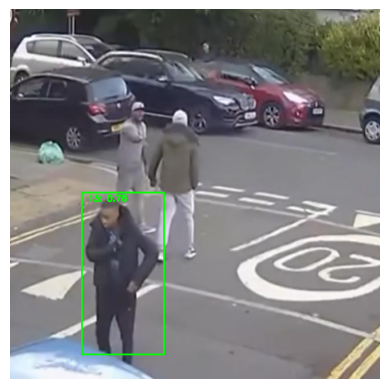

0.74


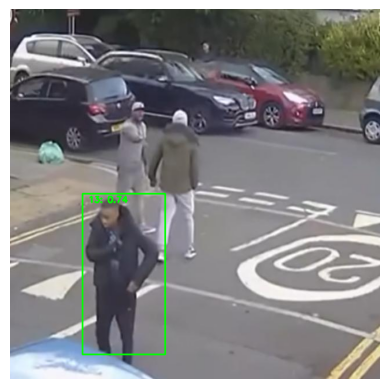

In [54]:
# 生成检测框图像
image_with_boxes = draw_boxes(image, outputs, class_range)

# 显示图像
plt.imshow(cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

image_with_boxes = draw_boxes(image, outputs_adv, class_range)

plt.imshow(cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

In [55]:
image_path = '/content/drive/My Drive/2024 Fall/COMS 6730/Projects/Person-Detection-YOLOV8N-Dectection/test/images/53_png.rf.b6aaa97737f85d6fa41b00637ab72fd9.jpg'
image = cv2.imread(image_path)

outputs = model(image)

# 将图像和标签转换为 Tensor
images = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0).to(device) / 255.0
labels = torch.tensor([0]).to(device)

# 生成对抗样本
print("Generating adversarial examples...")
images_adv = pgd_attack(model, images, epsilon, alpha, num_iter)

# 使用对抗样本进行预测
outputs_adv = model(images_adv)


0: 640x640 1 person, 7.5ms
Speed: 1.9ms preprocess, 7.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.5ms
Speed: 0.0ms preprocess, 7.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.4ms
Speed: 0.0ms preprocess, 9.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.4ms
Speed: 0.0ms preprocess, 9.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.3ms
Speed: 0.0ms preprocess, 9.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.3ms
Speed: 0.0ms preprocess, 9.3ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.3ms
Speed: 0.0ms preprocess, 9.3ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.3ms
Speed: 0.0ms preprocess, 9.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x

Generating adversarial examples...
Iteration 1/100, Loss: 0.17141517996788025
Iteration 2/100, Loss: 0.13795465230941772
Iteration 3/100, Loss: 0.13795465230941772
Iteration 4/100, Loss: 0.13795465230941772
Iteration 5/100, Loss: 0.13795465230941772
Iteration 6/100, Loss: 0.13795465230941772
Iteration 7/100, Loss: 0.13795465230941772
Iteration 8/100, Loss: 0.13795465230941772
Iteration 9/100, Loss: 0.13795465230941772
Iteration 10/100, Loss: 0.13795465230941772
Iteration 11/100, Loss: 0.13795465230941772
Iteration 12/100, Loss: 0.13795465230941772


0: 640x640 1 person, 8.3ms
Speed: 0.0ms preprocess, 8.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.5ms
Speed: 0.0ms preprocess, 7.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.4ms
Speed: 0.0ms preprocess, 7.4ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 0.0ms preprocess, 8.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.6ms
Speed: 0.0ms preprocess, 7.6ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.4ms
Speed: 0.0ms preprocess, 7.4ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.2ms
Speed: 0.0ms preprocess, 7.2ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.3ms
Speed: 0.0ms preprocess, 7.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x6

Iteration 13/100, Loss: 0.13795465230941772
Iteration 14/100, Loss: 0.13795465230941772
Iteration 15/100, Loss: 0.13795465230941772
Iteration 16/100, Loss: 0.13795465230941772
Iteration 17/100, Loss: 0.13795465230941772
Iteration 18/100, Loss: 0.13795465230941772
Iteration 19/100, Loss: 0.13795465230941772
Iteration 20/100, Loss: 0.13795465230941772
Iteration 21/100, Loss: 0.13795465230941772
Iteration 22/100, Loss: 0.13795465230941772
Iteration 23/100, Loss: 0.13795465230941772
Iteration 24/100, Loss: 0.13795465230941772
Iteration 25/100, Loss: 0.13795465230941772
Iteration 26/100, Loss: 0.13795465230941772


0: 640x640 1 person, 8.7ms
Speed: 0.0ms preprocess, 8.7ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.7ms
Speed: 0.0ms preprocess, 7.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.6ms
Speed: 0.0ms preprocess, 7.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.7ms
Speed: 0.0ms preprocess, 7.7ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 0.0ms preprocess, 8.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 0.0ms preprocess, 8.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 0.0ms preprocess, 7.8ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 0.0ms preprocess, 8.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x6

Iteration 27/100, Loss: 0.13795465230941772
Iteration 28/100, Loss: 0.13795465230941772
Iteration 29/100, Loss: 0.13795465230941772
Iteration 30/100, Loss: 0.13795465230941772
Iteration 31/100, Loss: 0.13795465230941772
Iteration 32/100, Loss: 0.13795465230941772
Iteration 33/100, Loss: 0.13795465230941772
Iteration 34/100, Loss: 0.13795465230941772
Iteration 35/100, Loss: 0.13795465230941772
Iteration 36/100, Loss: 0.13795465230941772
Iteration 37/100, Loss: 0.13795465230941772
Iteration 38/100, Loss: 0.13795465230941772
Iteration 39/100, Loss: 0.13795465230941772
Iteration 40/100, Loss: 0.13795465230941772


0: 640x640 1 person, 8.7ms
Speed: 0.0ms preprocess, 8.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 0.0ms preprocess, 8.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.5ms
Speed: 0.0ms preprocess, 7.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.7ms
Speed: 0.0ms preprocess, 7.7ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.0ms
Speed: 0.0ms preprocess, 9.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.6ms
Speed: 0.0ms preprocess, 7.6ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 0.0ms preprocess, 8.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 0.0ms preprocess, 8.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x6

Iteration 41/100, Loss: 0.13795465230941772
Iteration 42/100, Loss: 0.13795465230941772
Iteration 43/100, Loss: 0.13795465230941772
Iteration 44/100, Loss: 0.13795465230941772
Iteration 45/100, Loss: 0.13795465230941772
Iteration 46/100, Loss: 0.13795465230941772
Iteration 47/100, Loss: 0.13795465230941772
Iteration 48/100, Loss: 0.13795465230941772
Iteration 49/100, Loss: 0.13795465230941772
Iteration 50/100, Loss: 0.13795465230941772
Iteration 51/100, Loss: 0.13795465230941772
Iteration 52/100, Loss: 0.13795465230941772
Iteration 53/100, Loss: 0.13795465230941772
Iteration 54/100, Loss: 0.13795465230941772


0: 640x640 1 person, 10.3ms
Speed: 0.0ms preprocess, 10.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.7ms
Speed: 0.0ms preprocess, 7.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.1ms
Speed: 0.0ms preprocess, 7.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.2ms
Speed: 0.0ms preprocess, 7.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.6ms
Speed: 0.0ms preprocess, 7.6ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.4ms
Speed: 0.0ms preprocess, 7.4ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.5ms
Speed: 0.0ms preprocess, 9.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.4ms
Speed: 0.0ms preprocess, 7.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640

Iteration 55/100, Loss: 0.13795465230941772
Iteration 56/100, Loss: 0.13795465230941772
Iteration 57/100, Loss: 0.13795465230941772
Iteration 58/100, Loss: 0.13795465230941772
Iteration 59/100, Loss: 0.13795465230941772
Iteration 60/100, Loss: 0.13795465230941772
Iteration 61/100, Loss: 0.13795465230941772
Iteration 62/100, Loss: 0.13795465230941772
Iteration 63/100, Loss: 0.13795465230941772
Iteration 64/100, Loss: 0.13795465230941772
Iteration 65/100, Loss: 0.13795465230941772
Iteration 66/100, Loss: 0.13795465230941772
Iteration 67/100, Loss: 0.13795465230941772



0: 640x640 1 person, 9.5ms
Speed: 0.0ms preprocess, 9.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.8ms
Speed: 0.0ms preprocess, 9.8ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.6ms
Speed: 0.0ms preprocess, 7.6ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.7ms
Speed: 0.0ms preprocess, 9.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 0.0ms preprocess, 8.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.5ms
Speed: 0.0ms preprocess, 7.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.4ms
Speed: 0.0ms preprocess, 7.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.6ms
Speed: 0.0ms preprocess, 7.6ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x

Iteration 68/100, Loss: 0.13795465230941772
Iteration 69/100, Loss: 0.13795465230941772
Iteration 70/100, Loss: 0.13795465230941772
Iteration 71/100, Loss: 0.13795465230941772
Iteration 72/100, Loss: 0.13795465230941772
Iteration 73/100, Loss: 0.13795465230941772
Iteration 74/100, Loss: 0.13795465230941772
Iteration 75/100, Loss: 0.13795465230941772
Iteration 76/100, Loss: 0.13795465230941772
Iteration 77/100, Loss: 0.13795465230941772
Iteration 78/100, Loss: 0.13795465230941772
Iteration 79/100, Loss: 0.13795465230941772
Iteration 80/100, Loss: 0.13795465230941772


0: 640x640 1 person, 10.5ms
Speed: 0.1ms preprocess, 10.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 0.0ms preprocess, 8.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 0.0ms preprocess, 7.8ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.9ms
Speed: 0.0ms preprocess, 8.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.0ms
Speed: 0.0ms preprocess, 10.0ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.9ms
Speed: 0.0ms preprocess, 8.9ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.9ms
Speed: 0.0ms preprocess, 9.9ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 0.0ms preprocess, 8.3ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 6

Iteration 81/100, Loss: 0.13795465230941772
Iteration 82/100, Loss: 0.13795465230941772
Iteration 83/100, Loss: 0.13795465230941772
Iteration 84/100, Loss: 0.13795465230941772
Iteration 85/100, Loss: 0.13795465230941772
Iteration 86/100, Loss: 0.13795465230941772
Iteration 87/100, Loss: 0.13795465230941772
Iteration 88/100, Loss: 0.13795465230941772
Iteration 89/100, Loss: 0.13795465230941772
Iteration 90/100, Loss: 0.13795465230941772
Iteration 91/100, Loss: 0.13795465230941772
Iteration 92/100, Loss: 0.13795465230941772
Iteration 93/100, Loss: 0.13795465230941772


0: 640x640 1 person, 10.7ms
Speed: 0.0ms preprocess, 10.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.5ms
Speed: 0.0ms preprocess, 8.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 0.0ms preprocess, 8.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.7ms
Speed: 0.0ms preprocess, 8.7ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 0.0ms preprocess, 8.2ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 0.0ms preprocess, 8.0ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 0.0ms preprocess, 8.4ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 0.0ms preprocess, 8.2ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


Iteration 94/100, Loss: 0.13795465230941772
Iteration 95/100, Loss: 0.13795465230941772
Iteration 96/100, Loss: 0.13795465230941772
Iteration 97/100, Loss: 0.13795465230941772
Iteration 98/100, Loss: 0.13795465230941772
Iteration 99/100, Loss: 0.13795465230941772
Iteration 100/100, Loss: 0.13795465230941772


0.26


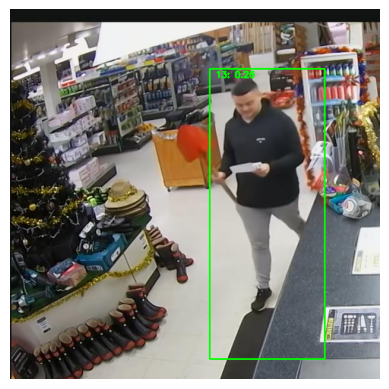

0.27


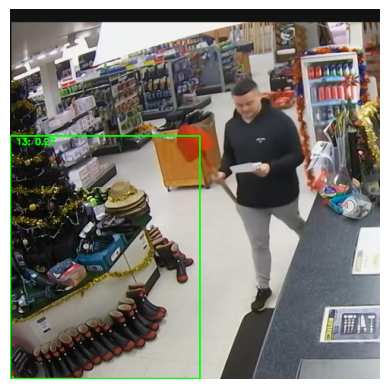

In [56]:
# 生成检测框图像
image_with_boxes = draw_boxes(image, outputs, class_range)

# 显示图像
plt.imshow(cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

image_with_boxes = draw_boxes(image, outputs_adv, class_range)

plt.imshow(cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

In [137]:
image_path = '/content/drive/My Drive/2024 Fall/COMS 6730/Projects/Senior-Design-VIAD/test/images/6a700ca4fcf71484_jpg.rf.c1b171f062001981482f050a0f46dd0d.jpg'
image = cv2.imread(image_path)

outputs = model(image)

# 将图像和标签转换为 Tensor
# images = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0).to(device) / 255.0
# labels = torch.tensor([0]).to(device)
images = preprocess_image(image, size=(640, 640))

# 生成对抗样本
print("Generating adversarial examples...")
images_adv = pgd_attack(model, images, epsilon, alpha, num_iter)

# 使用对抗样本进行预测
outputs_adv = model(images_adv)


0: 640x640 7 persons, 9.5ms
Speed: 2.6ms preprocess, 9.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 14 persons, 2 traffic_cones, 7.5ms
Speed: 1.2ms preprocess, 7.5ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 9.5ms
Speed: 1.3ms preprocess, 9.5ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 9.5ms
Speed: 1.3ms preprocess, 9.5ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 9.5ms
Speed: 1.2ms preprocess, 9.5ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 9.5ms
Speed: 1.2ms preprocess, 9.5ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 9.5ms
Speed: 1.2ms preprocess, 9.5ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 11.1ms
Speed: 1.2ms preprocess, 11.1ms inference, 4.2ms postprocess per image at sha

Generating adversarial examples...
Iteration 1/100, Loss: 0.9444316029548645
Iteration 2/100, Loss: 0.09223541617393494
Iteration 3/100, Loss: 0.09223541617393494
Iteration 4/100, Loss: 0.09223541617393494
Iteration 5/100, Loss: 0.09223541617393494
Iteration 6/100, Loss: 0.09223541617393494
Iteration 7/100, Loss: 0.09223541617393494


0: 640x640 4 persons, 10.0ms
Speed: 1.3ms preprocess, 10.0ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 9.5ms
Speed: 1.2ms preprocess, 9.5ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 9.4ms
Speed: 1.3ms preprocess, 9.4ms inference, 3.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 9.7ms
Speed: 1.3ms preprocess, 9.7ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 9.4ms
Speed: 1.4ms preprocess, 9.4ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 9.5ms
Speed: 1.2ms preprocess, 9.5ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 9.5ms
Speed: 1.2ms preprocess, 9.5ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 9.5ms
Speed: 1.2ms preprocess, 9.5ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

Iteration 8/100, Loss: 0.09223541617393494
Iteration 9/100, Loss: 0.09223541617393494
Iteration 10/100, Loss: 0.09223541617393494
Iteration 11/100, Loss: 0.09223541617393494
Iteration 12/100, Loss: 0.09223541617393494
Iteration 13/100, Loss: 0.09223541617393494
Iteration 14/100, Loss: 0.09223541617393494
Iteration 15/100, Loss: 0.09223541617393494


0: 640x640 4 persons, 9.9ms
Speed: 1.2ms preprocess, 9.9ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 9.6ms
Speed: 1.3ms preprocess, 9.6ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 9.5ms
Speed: 1.2ms preprocess, 9.5ms inference, 4.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 9.4ms
Speed: 1.3ms preprocess, 9.4ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 9.5ms
Speed: 1.2ms preprocess, 9.5ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 9.5ms
Speed: 1.4ms preprocess, 9.5ms inference, 3.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 9.5ms
Speed: 1.3ms preprocess, 9.5ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 9.5ms
Speed: 1.3ms preprocess, 9.5ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)



Iteration 16/100, Loss: 0.09223541617393494
Iteration 17/100, Loss: 0.09223541617393494
Iteration 18/100, Loss: 0.09223541617393494
Iteration 19/100, Loss: 0.09223541617393494
Iteration 20/100, Loss: 0.09223541617393494
Iteration 21/100, Loss: 0.09223541617393494
Iteration 22/100, Loss: 0.09223541617393494
Iteration 23/100, Loss: 0.09223541617393494


0: 640x640 4 persons, 13.0ms
Speed: 1.3ms preprocess, 13.0ms inference, 4.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 9.5ms
Speed: 1.3ms preprocess, 9.5ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 9.5ms
Speed: 1.2ms preprocess, 9.5ms inference, 4.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 9.5ms
Speed: 1.2ms preprocess, 9.5ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 9.9ms
Speed: 1.3ms preprocess, 9.9ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 9.5ms
Speed: 1.2ms preprocess, 9.5ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 9.5ms
Speed: 1.2ms preprocess, 9.5ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 9.5ms
Speed: 1.2ms preprocess, 9.5ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

Iteration 24/100, Loss: 0.09223541617393494
Iteration 25/100, Loss: 0.09223541617393494
Iteration 26/100, Loss: 0.09223541617393494
Iteration 27/100, Loss: 0.09223541617393494
Iteration 28/100, Loss: 0.09223541617393494
Iteration 29/100, Loss: 0.09223541617393494
Iteration 30/100, Loss: 0.09223541617393494
Iteration 31/100, Loss: 0.09223541617393494



0: 640x640 4 persons, 9.6ms
Speed: 1.2ms preprocess, 9.6ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 9.5ms
Speed: 1.2ms preprocess, 9.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 9.5ms
Speed: 1.2ms preprocess, 9.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 11.7ms
Speed: 1.3ms preprocess, 11.7ms inference, 3.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 10.6ms
Speed: 1.3ms preprocess, 10.6ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 9.5ms
Speed: 1.2ms preprocess, 9.5ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 9.5ms
Speed: 1.2ms preprocess, 9.5ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 9.5ms
Speed: 1.2ms preprocess, 9.5ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 6

Iteration 32/100, Loss: 0.09223541617393494
Iteration 33/100, Loss: 0.09223541617393494
Iteration 34/100, Loss: 0.09223541617393494
Iteration 35/100, Loss: 0.09223541617393494
Iteration 36/100, Loss: 0.09223541617393494
Iteration 37/100, Loss: 0.09223541617393494
Iteration 38/100, Loss: 0.09223541617393494



0: 640x640 4 persons, 9.7ms
Speed: 1.2ms preprocess, 9.7ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 9.6ms
Speed: 1.3ms preprocess, 9.6ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 9.4ms
Speed: 1.2ms preprocess, 9.4ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 9.5ms
Speed: 1.3ms preprocess, 9.5ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 9.5ms
Speed: 1.2ms preprocess, 9.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 9.5ms
Speed: 1.2ms preprocess, 9.5ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 9.9ms
Speed: 1.3ms preprocess, 9.9ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)



Iteration 39/100, Loss: 0.09223541617393494
Iteration 40/100, Loss: 0.09223541617393494
Iteration 41/100, Loss: 0.09223541617393494
Iteration 42/100, Loss: 0.09223541617393494
Iteration 43/100, Loss: 0.09223541617393494
Iteration 44/100, Loss: 0.09223541617393494
Iteration 45/100, Loss: 0.09223541617393494
Iteration 46/100, Loss: 0.09223541617393494


0: 640x640 4 persons, 11.5ms
Speed: 1.4ms preprocess, 11.5ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 9.4ms
Speed: 1.2ms preprocess, 9.4ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 10.0ms
Speed: 1.3ms preprocess, 10.0ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 9.7ms
Speed: 1.2ms preprocess, 9.7ms inference, 3.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 9.7ms
Speed: 1.2ms preprocess, 9.7ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 9.3ms
Speed: 1.2ms preprocess, 9.3ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 9.3ms
Speed: 1.2ms preprocess, 9.3ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 9.3ms
Speed: 1.2ms preprocess, 9.3ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 64

Iteration 47/100, Loss: 0.09223541617393494
Iteration 48/100, Loss: 0.09223541617393494
Iteration 49/100, Loss: 0.09223541617393494
Iteration 50/100, Loss: 0.09223541617393494
Iteration 51/100, Loss: 0.09223541617393494
Iteration 52/100, Loss: 0.09223541617393494
Iteration 53/100, Loss: 0.09223541617393494
Iteration 54/100, Loss: 0.09223541617393494


0: 640x640 4 persons, 9.5ms
Speed: 1.2ms preprocess, 9.5ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 9.3ms
Speed: 1.2ms preprocess, 9.3ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 9.7ms
Speed: 1.2ms preprocess, 9.7ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 9.3ms
Speed: 1.2ms preprocess, 9.3ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 9.3ms
Speed: 1.2ms preprocess, 9.3ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 10.5ms
Speed: 1.3ms preprocess, 10.5ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 9.4ms
Speed: 1.2ms preprocess, 9.4ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 10.8ms
Speed: 1.2ms preprocess, 10.8ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 64

Iteration 55/100, Loss: 0.09223541617393494
Iteration 56/100, Loss: 0.09223541617393494
Iteration 57/100, Loss: 0.09223541617393494
Iteration 58/100, Loss: 0.09223541617393494
Iteration 59/100, Loss: 0.09223541617393494
Iteration 60/100, Loss: 0.09223541617393494
Iteration 61/100, Loss: 0.09223541617393494
Iteration 62/100, Loss: 0.09223541617393494


0: 640x640 4 persons, 12.0ms
Speed: 1.3ms preprocess, 12.0ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 9.3ms
Speed: 1.3ms preprocess, 9.3ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 9.4ms
Speed: 1.2ms preprocess, 9.4ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 9.3ms
Speed: 1.2ms preprocess, 9.3ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 9.3ms
Speed: 1.2ms preprocess, 9.3ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 9.3ms
Speed: 1.4ms preprocess, 9.3ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 9.3ms
Speed: 1.6ms preprocess, 9.3ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 9.3ms
Speed: 1.1ms preprocess, 9.3ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

Iteration 63/100, Loss: 0.09223541617393494
Iteration 64/100, Loss: 0.09223541617393494
Iteration 65/100, Loss: 0.09223541617393494
Iteration 66/100, Loss: 0.09223541617393494
Iteration 67/100, Loss: 0.09223541617393494
Iteration 68/100, Loss: 0.09223541617393494
Iteration 69/100, Loss: 0.09223541617393494
Iteration 70/100, Loss: 0.09223541617393494


0: 640x640 4 persons, 11.4ms
Speed: 1.3ms preprocess, 11.4ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 9.4ms
Speed: 1.2ms preprocess, 9.4ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 10.1ms
Speed: 1.2ms preprocess, 10.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 9.2ms
Speed: 1.3ms preprocess, 9.2ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 9.3ms
Speed: 1.2ms preprocess, 9.3ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 9.3ms
Speed: 1.2ms preprocess, 9.3ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 9.5ms
Speed: 1.4ms preprocess, 9.5ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 9.2ms
Speed: 1.2ms preprocess, 9.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 64

Iteration 71/100, Loss: 0.09223541617393494
Iteration 72/100, Loss: 0.09223541617393494
Iteration 73/100, Loss: 0.09223541617393494
Iteration 74/100, Loss: 0.09223541617393494
Iteration 75/100, Loss: 0.09223541617393494
Iteration 76/100, Loss: 0.09223541617393494
Iteration 77/100, Loss: 0.09223541617393494
Iteration 78/100, Loss: 0.09223541617393494


Speed: 1.2ms preprocess, 9.3ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 9.4ms
Speed: 1.2ms preprocess, 9.4ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 9.3ms
Speed: 1.2ms preprocess, 9.3ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 9.3ms
Speed: 1.2ms preprocess, 9.3ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 9.3ms
Speed: 1.2ms preprocess, 9.3ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 9.6ms
Speed: 1.2ms preprocess, 9.6ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 9.3ms
Speed: 1.2ms preprocess, 9.3ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 9.3ms
Speed: 1.2ms preprocess, 9.3ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)



Iteration 79/100, Loss: 0.09223541617393494
Iteration 80/100, Loss: 0.09223541617393494
Iteration 81/100, Loss: 0.09223541617393494
Iteration 82/100, Loss: 0.09223541617393494
Iteration 83/100, Loss: 0.09223541617393494
Iteration 84/100, Loss: 0.09223541617393494
Iteration 85/100, Loss: 0.09223541617393494
Iteration 86/100, Loss: 0.09223541617393494


0: 640x640 4 persons, 9.3ms
Speed: 1.8ms preprocess, 9.3ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 9.3ms
Speed: 1.2ms preprocess, 9.3ms inference, 4.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 9.3ms
Speed: 1.2ms preprocess, 9.3ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 9.4ms
Speed: 1.2ms preprocess, 9.4ms inference, 4.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 9.3ms
Speed: 1.2ms preprocess, 9.3ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 9.3ms
Speed: 1.2ms preprocess, 9.3ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 9.3ms
Speed: 1.2ms preprocess, 9.3ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 9.3ms
Speed: 1.2ms preprocess, 9.3ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)



Iteration 87/100, Loss: 0.09223541617393494
Iteration 88/100, Loss: 0.09223541617393494
Iteration 89/100, Loss: 0.09223541617393494
Iteration 90/100, Loss: 0.09223541617393494
Iteration 91/100, Loss: 0.09223541617393494
Iteration 92/100, Loss: 0.09223541617393494
Iteration 93/100, Loss: 0.09223541617393494
Iteration 94/100, Loss: 0.09223541617393494


0: 640x640 4 persons, 12.9ms
Speed: 1.3ms preprocess, 12.9ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 9.3ms
Speed: 1.2ms preprocess, 9.3ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 9.5ms
Speed: 1.2ms preprocess, 9.5ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 9.3ms
Speed: 1.2ms preprocess, 9.3ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 9.3ms
Speed: 1.2ms preprocess, 9.3ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 9.3ms
Speed: 1.2ms preprocess, 9.3ms inference, 3.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 9.4ms
Speed: 1.2ms preprocess, 9.4ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)


Iteration 95/100, Loss: 0.09223541617393494
Iteration 96/100, Loss: 0.09223541617393494
Iteration 97/100, Loss: 0.09223541617393494
Iteration 98/100, Loss: 0.09223541617393494
Iteration 99/100, Loss: 0.09223541617393494
Iteration 100/100, Loss: 0.09223541617393494


0.67
0.61
0.39
0.32
0.30
0.30
0.29


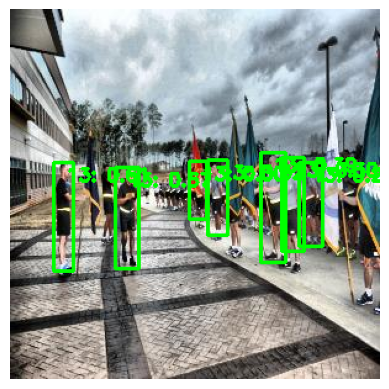

0.59
0.29
0.29
0.27


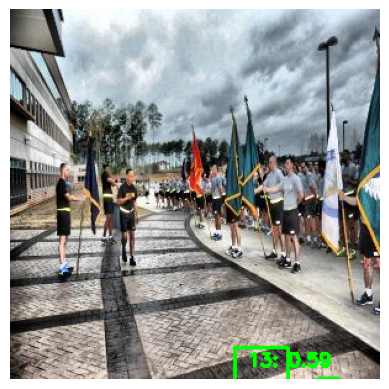

In [138]:
# 生成检测框图像
image_with_boxes = draw_boxes(image, outputs, class_range)

# 显示图像
plt.imshow(cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

image_with_boxes = draw_boxes(image, outputs_adv, class_range)

plt.imshow(cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

In [139]:
image_path = '/content/drive/My Drive/2024 Fall/COMS 6730/Projects/Senior-Design-VIAD/test/images/7ac508fcee342ab9_jpg.rf.e404b1cb80138fd4dd3c2ae7e09a4d3d.jpg'
image = cv2.imread(image_path)

outputs = model(image)

# 将图像和标签转换为 Tensor
# images = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0).to(device) / 255.0
# labels = torch.tensor([0]).to(device)
images = preprocess_image(image, size=(640, 640))

# 生成对抗样本
print("Generating adversarial examples...")
images_adv = pgd_attack(model, images, epsilon, alpha, num_iter)

# 使用对抗样本进行预测
outputs_adv = model(images_adv)


0: 640x640 1 person, 7.5ms
Speed: 2.7ms preprocess, 7.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.5ms
Speed: 1.2ms preprocess, 7.5ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 1 train, 9.5ms
Speed: 1.2ms preprocess, 9.5ms inference, 4.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 1 train, 9.5ms
Speed: 1.2ms preprocess, 9.5ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 1 train, 9.4ms
Speed: 1.2ms preprocess, 9.4ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 1 train, 9.4ms
Speed: 1.2ms preprocess, 9.4ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 1 train, 9.4ms
Speed: 1.2ms preprocess, 9.4ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 1 train, 9.4ms
Speed: 1.2ms preprocess, 9.4ms inference, 2.9ms po

Generating adversarial examples...
Iteration 1/100, Loss: -0.10497719049453735
Iteration 2/100, Loss: 0.4832642078399658
Iteration 3/100, Loss: 0.4832642078399658
Iteration 4/100, Loss: 0.4832642078399658
Iteration 5/100, Loss: 0.4832642078399658
Iteration 6/100, Loss: 0.4832642078399658
Iteration 7/100, Loss: 0.4832642078399658


0: 640x640 1 person, 1 train, 9.4ms
Speed: 1.3ms preprocess, 9.4ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 1 train, 9.4ms
Speed: 1.2ms preprocess, 9.4ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 1 train, 10.0ms
Speed: 1.2ms preprocess, 10.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 1 train, 9.5ms
Speed: 1.2ms preprocess, 9.5ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 1 train, 9.5ms
Speed: 1.2ms preprocess, 9.5ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 1 train, 9.5ms
Speed: 1.2ms preprocess, 9.5ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 1 train, 9.5ms
Speed: 1.2ms preprocess, 9.5ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 1 train, 9.5ms
Speed: 1.2ms preprocess, 9.5ms 

Iteration 8/100, Loss: 0.4832642078399658
Iteration 9/100, Loss: 0.4832642078399658
Iteration 10/100, Loss: 0.4832642078399658
Iteration 11/100, Loss: 0.4832642078399658
Iteration 12/100, Loss: 0.4832642078399658
Iteration 13/100, Loss: 0.4832642078399658
Iteration 14/100, Loss: 0.4832642078399658
Iteration 15/100, Loss: 0.4832642078399658


0: 640x640 1 person, 1 train, 10.6ms
Speed: 1.4ms preprocess, 10.6ms inference, 3.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 1 train, 9.5ms
Speed: 1.2ms preprocess, 9.5ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 1 train, 9.5ms
Speed: 1.2ms preprocess, 9.5ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 1 train, 9.5ms
Speed: 1.3ms preprocess, 9.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 1 train, 9.5ms
Speed: 1.2ms preprocess, 9.5ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 1 train, 9.4ms
Speed: 1.3ms preprocess, 9.4ms inference, 4.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 1 train, 9.4ms
Speed: 1.2ms preprocess, 9.4ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 1 train, 9.5ms
Speed: 1.2ms preprocess, 9.5ms 

Iteration 16/100, Loss: 0.4832642078399658
Iteration 17/100, Loss: 0.4832642078399658
Iteration 18/100, Loss: 0.4832642078399658
Iteration 19/100, Loss: 0.4832642078399658
Iteration 20/100, Loss: 0.4832642078399658
Iteration 21/100, Loss: 0.4832642078399658
Iteration 22/100, Loss: 0.4832642078399658
Iteration 23/100, Loss: 0.4832642078399658


0: 640x640 1 person, 1 train, 9.5ms
Speed: 1.3ms preprocess, 9.5ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 1 train, 9.4ms
Speed: 1.2ms preprocess, 9.4ms inference, 3.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 1 train, 9.5ms
Speed: 1.2ms preprocess, 9.5ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 1 train, 9.4ms
Speed: 1.2ms preprocess, 9.4ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 1 train, 9.4ms
Speed: 1.4ms preprocess, 9.4ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 1 train, 9.5ms
Speed: 1.5ms preprocess, 9.5ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 1 train, 9.6ms
Speed: 1.2ms preprocess, 9.6ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 1 train, 9.8ms
Speed: 1.3ms preprocess, 9.8ms in

Iteration 24/100, Loss: 0.4832642078399658
Iteration 25/100, Loss: 0.4832642078399658
Iteration 26/100, Loss: 0.4832642078399658
Iteration 27/100, Loss: 0.4832642078399658
Iteration 28/100, Loss: 0.4832642078399658
Iteration 29/100, Loss: 0.4832642078399658
Iteration 30/100, Loss: 0.4832642078399658
Iteration 31/100, Loss: 0.4832642078399658


0: 640x640 1 person, 1 train, 10.1ms
Speed: 1.4ms preprocess, 10.1ms inference, 4.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 1 train, 9.6ms
Speed: 1.3ms preprocess, 9.6ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 1 train, 9.3ms
Speed: 1.2ms preprocess, 9.3ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 1 train, 9.3ms
Speed: 1.2ms preprocess, 9.3ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 1 train, 9.5ms
Speed: 1.3ms preprocess, 9.5ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 1 train, 9.3ms
Speed: 1.2ms preprocess, 9.3ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 1 train, 9.3ms
Speed: 1.2ms preprocess, 9.3ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 1 train, 9.3ms
Speed: 1.2ms preprocess, 9.3ms 

Iteration 32/100, Loss: 0.4832642078399658
Iteration 33/100, Loss: 0.4832642078399658
Iteration 34/100, Loss: 0.4832642078399658
Iteration 35/100, Loss: 0.4832642078399658
Iteration 36/100, Loss: 0.4832642078399658
Iteration 37/100, Loss: 0.4832642078399658
Iteration 38/100, Loss: 0.4832642078399658
Iteration 39/100, Loss: 0.4832642078399658


0: 640x640 1 person, 1 train, 9.3ms
Speed: 1.3ms preprocess, 9.3ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 1 train, 9.7ms
Speed: 1.3ms preprocess, 9.7ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 1 train, 9.6ms
Speed: 1.3ms preprocess, 9.6ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 1 train, 11.9ms
Speed: 1.3ms preprocess, 11.9ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 1 train, 9.3ms
Speed: 1.6ms preprocess, 9.3ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 1 train, 9.3ms
Speed: 1.2ms preprocess, 9.3ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 1 train, 9.5ms
Speed: 1.5ms preprocess, 9.5ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 1 train, 9.3ms
Speed: 1.7ms preprocess, 9.3ms 

Iteration 40/100, Loss: 0.4832642078399658
Iteration 41/100, Loss: 0.4832642078399658
Iteration 42/100, Loss: 0.4832642078399658
Iteration 43/100, Loss: 0.4832642078399658
Iteration 44/100, Loss: 0.4832642078399658
Iteration 45/100, Loss: 0.4832642078399658
Iteration 46/100, Loss: 0.4832642078399658
Iteration 47/100, Loss: 0.4832642078399658



0: 640x640 1 person, 1 train, 9.4ms
Speed: 1.3ms preprocess, 9.4ms inference, 4.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 1 train, 9.3ms
Speed: 1.2ms preprocess, 9.3ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 1 train, 9.3ms
Speed: 1.3ms preprocess, 9.3ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 1 train, 11.6ms
Speed: 1.3ms preprocess, 11.6ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 1 train, 11.6ms
Speed: 1.3ms preprocess, 11.6ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 1 train, 9.5ms
Speed: 1.3ms preprocess, 9.5ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 1 train, 9.3ms
Speed: 1.3ms preprocess, 9.3ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 1 train, 9.3ms
Speed: 1.4ms preprocess, 9.3

Iteration 48/100, Loss: 0.4832642078399658
Iteration 49/100, Loss: 0.4832642078399658
Iteration 50/100, Loss: 0.4832642078399658
Iteration 51/100, Loss: 0.4832642078399658
Iteration 52/100, Loss: 0.4832642078399658
Iteration 53/100, Loss: 0.4832642078399658
Iteration 54/100, Loss: 0.4832642078399658
Iteration 55/100, Loss: 0.4832642078399658



0: 640x640 1 person, 1 train, 9.3ms
Speed: 1.2ms preprocess, 9.3ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 1 train, 9.3ms
Speed: 1.2ms preprocess, 9.3ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 1 train, 9.3ms
Speed: 1.2ms preprocess, 9.3ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 1 train, 11.0ms
Speed: 1.2ms preprocess, 11.0ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 1 train, 11.0ms
Speed: 1.2ms preprocess, 11.0ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 1 train, 9.3ms
Speed: 1.2ms preprocess, 9.3ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 1 train, 10.0ms
Speed: 1.2ms preprocess, 10.0ms inference, 4.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 1 train, 9.3ms
Speed: 1.2ms preprocess, 9

Iteration 56/100, Loss: 0.4832642078399658
Iteration 57/100, Loss: 0.4832642078399658
Iteration 58/100, Loss: 0.4832642078399658
Iteration 59/100, Loss: 0.4832642078399658
Iteration 60/100, Loss: 0.4832642078399658
Iteration 61/100, Loss: 0.4832642078399658
Iteration 62/100, Loss: 0.4832642078399658
Iteration 63/100, Loss: 0.4832642078399658


0: 640x640 1 person, 1 train, 9.3ms
Speed: 1.3ms preprocess, 9.3ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 1 train, 9.5ms
Speed: 1.2ms preprocess, 9.5ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 1 train, 9.3ms
Speed: 1.3ms preprocess, 9.3ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 1 train, 10.8ms
Speed: 1.2ms preprocess, 10.8ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 1 train, 9.3ms
Speed: 1.2ms preprocess, 9.3ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 1 train, 9.3ms
Speed: 1.2ms preprocess, 9.3ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 1 train, 9.3ms
Speed: 1.2ms preprocess, 9.3ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 1 train, 10.4ms
Speed: 1.2ms preprocess, 10.4m

Iteration 64/100, Loss: 0.4832642078399658
Iteration 65/100, Loss: 0.4832642078399658
Iteration 66/100, Loss: 0.4832642078399658
Iteration 67/100, Loss: 0.4832642078399658
Iteration 68/100, Loss: 0.4832642078399658
Iteration 69/100, Loss: 0.4832642078399658
Iteration 70/100, Loss: 0.4832642078399658
Iteration 71/100, Loss: 0.4832642078399658


0: 640x640 1 person, 1 train, 11.3ms
Speed: 1.2ms preprocess, 11.3ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 1 train, 9.4ms
Speed: 1.1ms preprocess, 9.4ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 1 train, 9.3ms
Speed: 1.2ms preprocess, 9.3ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 1 train, 9.3ms
Speed: 1.2ms preprocess, 9.3ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 1 train, 9.3ms
Speed: 1.2ms preprocess, 9.3ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 1 train, 9.3ms
Speed: 1.2ms preprocess, 9.3ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 1 train, 9.4ms
Speed: 1.2ms preprocess, 9.4ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 1 train, 9.3ms
Speed: 1.2ms preprocess, 9.3ms 

Iteration 72/100, Loss: 0.4832642078399658
Iteration 73/100, Loss: 0.4832642078399658
Iteration 74/100, Loss: 0.4832642078399658
Iteration 75/100, Loss: 0.4832642078399658
Iteration 76/100, Loss: 0.4832642078399658
Iteration 77/100, Loss: 0.4832642078399658
Iteration 78/100, Loss: 0.4832642078399658
Iteration 79/100, Loss: 0.4832642078399658


0: 640x640 1 person, 1 train, 12.6ms
Speed: 1.2ms preprocess, 12.6ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 1 train, 10.4ms
Speed: 1.3ms preprocess, 10.4ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 1 train, 9.3ms
Speed: 1.2ms preprocess, 9.3ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 1 train, 9.8ms
Speed: 1.2ms preprocess, 9.8ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 1 train, 9.3ms
Speed: 1.2ms preprocess, 9.3ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 1 train, 9.3ms
Speed: 1.2ms preprocess, 9.3ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 1 train, 9.3ms
Speed: 1.3ms preprocess, 9.3ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 1 train, 9.3ms
Speed: 1.2ms preprocess, 9.3m

Iteration 80/100, Loss: 0.4832642078399658
Iteration 81/100, Loss: 0.4832642078399658
Iteration 82/100, Loss: 0.4832642078399658
Iteration 83/100, Loss: 0.4832642078399658
Iteration 84/100, Loss: 0.4832642078399658
Iteration 85/100, Loss: 0.4832642078399658
Iteration 86/100, Loss: 0.4832642078399658
Iteration 87/100, Loss: 0.4832642078399658


0: 640x640 1 person, 1 train, 9.3ms
Speed: 1.4ms preprocess, 9.3ms inference, 3.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 1 train, 11.2ms
Speed: 1.3ms preprocess, 11.2ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 1 train, 9.3ms
Speed: 1.2ms preprocess, 9.3ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 1 train, 9.3ms
Speed: 1.2ms preprocess, 9.3ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 1 train, 10.8ms
Speed: 1.5ms preprocess, 10.8ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 1 train, 9.3ms
Speed: 1.2ms preprocess, 9.3ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 1 train, 11.0ms
Speed: 1.3ms preprocess, 11.0ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 1 train, 9.3ms
Speed: 1.2ms preprocess, 9.

Iteration 88/100, Loss: 0.4832642078399658
Iteration 89/100, Loss: 0.4832642078399658
Iteration 90/100, Loss: 0.4832642078399658
Iteration 91/100, Loss: 0.4832642078399658
Iteration 92/100, Loss: 0.4832642078399658
Iteration 93/100, Loss: 0.4832642078399658
Iteration 94/100, Loss: 0.4832642078399658
Iteration 95/100, Loss: 0.4832642078399658


0: 640x640 1 person, 1 train, 9.3ms
Speed: 1.2ms preprocess, 9.3ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 1 train, 9.3ms
Speed: 1.2ms preprocess, 9.3ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 1 train, 9.6ms
Speed: 1.2ms preprocess, 9.6ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 1 train, 9.5ms
Speed: 1.2ms preprocess, 9.5ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 1 train, 9.5ms
Speed: 1.2ms preprocess, 9.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 1 train, 9.5ms
Speed: 1.2ms preprocess, 9.5ms inference, 4.5ms postprocess per image at shape (1, 3, 640, 640)


Iteration 96/100, Loss: 0.4832642078399658
Iteration 97/100, Loss: 0.4832642078399658
Iteration 98/100, Loss: 0.4832642078399658
Iteration 99/100, Loss: 0.4832642078399658
Iteration 100/100, Loss: 0.4832642078399658


0.66


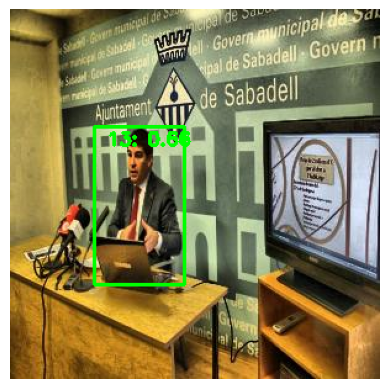

0.57
0.30


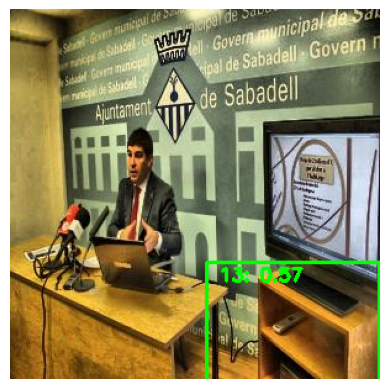

In [140]:
# 生成检测框图像
image_with_boxes = draw_boxes(image, outputs, class_range)

# 显示图像
plt.imshow(cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

image_with_boxes = draw_boxes(image, outputs_adv, class_range)

plt.imshow(cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

In [141]:
image_path = '/content/drive/My Drive/2024 Fall/COMS 6730/Projects/Senior-Design-VIAD/test/images/09a5205eac973e56_jpg.rf.ec1c2cfce5a524ed90d218ffda10dc9a.jpg'
image = cv2.imread(image_path)

outputs = model(image)

# 将图像和标签转换为 Tensor
# images = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0).to(device) / 255.0
# labels = torch.tensor([0]).to(device)
images = preprocess_image(image, size=(640, 640))

# 生成对抗样本
print("Generating adversarial examples...")
images_adv = pgd_attack(model, images, epsilon, alpha, num_iter)

# 使用对抗样本进行预测
outputs_adv = model(images_adv)


0: 640x640 1 gun, 10.3ms
Speed: 2.9ms preprocess, 10.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 guns, 7.5ms
Speed: 1.2ms preprocess, 7.5ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 gun, 9.5ms
Speed: 1.2ms preprocess, 9.5ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 gun, 9.5ms
Speed: 1.2ms preprocess, 9.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 gun, 9.5ms
Speed: 1.2ms preprocess, 9.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 gun, 10.1ms
Speed: 1.3ms preprocess, 10.1ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 gun, 10.3ms
Speed: 1.3ms preprocess, 10.3ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 gun, 9.5ms
Speed: 1.3ms preprocess, 9.5ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)



Generating adversarial examples...
Iteration 1/100, Loss: 1.0406697988510132
Iteration 2/100, Loss: 0.904315710067749
Iteration 3/100, Loss: 0.904315710067749
Iteration 4/100, Loss: 0.904315710067749
Iteration 5/100, Loss: 0.904315710067749
Iteration 6/100, Loss: 0.904315710067749
Iteration 7/100, Loss: 0.904315710067749


0: 640x640 1 gun, 10.2ms
Speed: 1.2ms preprocess, 10.2ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 gun, 9.5ms
Speed: 1.2ms preprocess, 9.5ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 gun, 9.5ms
Speed: 1.2ms preprocess, 9.5ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 gun, 9.5ms
Speed: 1.2ms preprocess, 9.5ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 gun, 9.5ms
Speed: 1.2ms preprocess, 9.5ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 gun, 9.5ms
Speed: 1.2ms preprocess, 9.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 gun, 9.5ms
Speed: 1.2ms preprocess, 9.5ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 gun, 9.8ms
Speed: 1.3ms preprocess, 9.8ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Iteration 8/100, Loss: 0.904315710067749
Iteration 9/100, Loss: 0.904315710067749
Iteration 10/100, Loss: 0.904315710067749
Iteration 11/100, Loss: 0.904315710067749
Iteration 12/100, Loss: 0.904315710067749
Iteration 13/100, Loss: 0.904315710067749
Iteration 14/100, Loss: 0.904315710067749



0: 640x640 1 gun, 9.5ms
Speed: 1.2ms preprocess, 9.5ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 gun, 9.7ms
Speed: 1.2ms preprocess, 9.7ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 gun, 9.5ms
Speed: 1.2ms preprocess, 9.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 gun, 9.9ms
Speed: 1.3ms preprocess, 9.9ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 gun, 9.5ms
Speed: 1.2ms preprocess, 9.5ms inference, 5.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 gun, 9.7ms
Speed: 1.2ms preprocess, 9.7ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 gun, 9.5ms
Speed: 1.2ms preprocess, 9.5ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)



Iteration 15/100, Loss: 0.904315710067749
Iteration 16/100, Loss: 0.904315710067749
Iteration 17/100, Loss: 0.904315710067749
Iteration 18/100, Loss: 0.904315710067749
Iteration 19/100, Loss: 0.904315710067749
Iteration 20/100, Loss: 0.904315710067749
Iteration 21/100, Loss: 0.904315710067749
Iteration 22/100, Loss: 0.904315710067749


0: 640x640 1 gun, 9.5ms
Speed: 1.4ms preprocess, 9.5ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 gun, 9.5ms
Speed: 1.2ms preprocess, 9.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 gun, 9.5ms
Speed: 1.2ms preprocess, 9.5ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 gun, 9.7ms
Speed: 1.2ms preprocess, 9.7ms inference, 4.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 gun, 9.5ms
Speed: 1.2ms preprocess, 9.5ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 gun, 9.5ms
Speed: 1.3ms preprocess, 9.5ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 gun, 9.5ms
Speed: 1.3ms preprocess, 9.5ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 gun, 10.1ms
Speed: 1.3ms preprocess, 10.1ms inference, 4.3ms postprocess per image at shape (1, 3, 640, 640)



Iteration 23/100, Loss: 0.904315710067749
Iteration 24/100, Loss: 0.904315710067749
Iteration 25/100, Loss: 0.904315710067749
Iteration 26/100, Loss: 0.904315710067749
Iteration 27/100, Loss: 0.904315710067749
Iteration 28/100, Loss: 0.904315710067749
Iteration 29/100, Loss: 0.904315710067749
Iteration 30/100, Loss: 0.904315710067749


0: 640x640 1 gun, 9.5ms
Speed: 1.9ms preprocess, 9.5ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 gun, 9.6ms
Speed: 1.2ms preprocess, 9.6ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 gun, 9.4ms
Speed: 1.3ms preprocess, 9.4ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 gun, 9.4ms
Speed: 1.3ms preprocess, 9.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 gun, 9.5ms
Speed: 1.2ms preprocess, 9.5ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 gun, 9.4ms
Speed: 1.2ms preprocess, 9.4ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 gun, 9.5ms
Speed: 1.2ms preprocess, 9.5ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 gun, 9.6ms
Speed: 1.3ms preprocess, 9.6ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)



Iteration 31/100, Loss: 0.904315710067749
Iteration 32/100, Loss: 0.904315710067749
Iteration 33/100, Loss: 0.904315710067749
Iteration 34/100, Loss: 0.904315710067749
Iteration 35/100, Loss: 0.904315710067749
Iteration 36/100, Loss: 0.904315710067749
Iteration 37/100, Loss: 0.904315710067749
Iteration 38/100, Loss: 0.904315710067749


0: 640x640 1 gun, 9.4ms
Speed: 1.2ms preprocess, 9.4ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 gun, 9.5ms
Speed: 1.2ms preprocess, 9.5ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 gun, 10.2ms
Speed: 1.3ms preprocess, 10.2ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 gun, 9.8ms
Speed: 1.3ms preprocess, 9.8ms inference, 4.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 gun, 9.5ms
Speed: 1.2ms preprocess, 9.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 gun, 10.3ms
Speed: 1.2ms preprocess, 10.3ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 gun, 9.5ms
Speed: 1.2ms preprocess, 9.5ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 gun, 10.2ms
Speed: 1.3ms preprocess, 10.2ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)


Iteration 39/100, Loss: 0.904315710067749
Iteration 40/100, Loss: 0.904315710067749
Iteration 41/100, Loss: 0.904315710067749
Iteration 42/100, Loss: 0.904315710067749
Iteration 43/100, Loss: 0.904315710067749
Iteration 44/100, Loss: 0.904315710067749
Iteration 45/100, Loss: 0.904315710067749
Iteration 46/100, Loss: 0.904315710067749



0: 640x640 1 gun, 9.5ms
Speed: 1.4ms preprocess, 9.5ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 gun, 9.5ms
Speed: 1.3ms preprocess, 9.5ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 gun, 9.5ms
Speed: 1.2ms preprocess, 9.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 gun, 9.5ms
Speed: 1.2ms preprocess, 9.5ms inference, 3.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 gun, 9.6ms
Speed: 1.3ms preprocess, 9.6ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 gun, 10.3ms
Speed: 1.3ms preprocess, 10.3ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 gun, 10.0ms
Speed: 1.2ms preprocess, 10.0ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 gun, 9.5ms
Speed: 1.2ms preprocess, 9.5ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)



Iteration 47/100, Loss: 0.904315710067749
Iteration 48/100, Loss: 0.904315710067749
Iteration 49/100, Loss: 0.904315710067749
Iteration 50/100, Loss: 0.904315710067749
Iteration 51/100, Loss: 0.904315710067749
Iteration 52/100, Loss: 0.904315710067749
Iteration 53/100, Loss: 0.904315710067749
Iteration 54/100, Loss: 0.904315710067749


0: 640x640 1 gun, 9.5ms
Speed: 1.2ms preprocess, 9.5ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 gun, 9.4ms
Speed: 1.2ms preprocess, 9.4ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 gun, 9.8ms
Speed: 1.2ms preprocess, 9.8ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 gun, 9.9ms
Speed: 1.3ms preprocess, 9.9ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 gun, 9.5ms
Speed: 1.2ms preprocess, 9.5ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 gun, 9.5ms
Speed: 1.2ms preprocess, 9.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 gun, 9.7ms
Speed: 1.3ms preprocess, 9.7ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 gun, 9.8ms
Speed: 1.2ms preprocess, 9.8ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)



Iteration 55/100, Loss: 0.904315710067749
Iteration 56/100, Loss: 0.904315710067749
Iteration 57/100, Loss: 0.904315710067749
Iteration 58/100, Loss: 0.904315710067749
Iteration 59/100, Loss: 0.904315710067749
Iteration 60/100, Loss: 0.904315710067749
Iteration 61/100, Loss: 0.904315710067749
Iteration 62/100, Loss: 0.904315710067749


0: 640x640 1 gun, 10.0ms
Speed: 1.2ms preprocess, 10.0ms inference, 4.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 gun, 9.5ms
Speed: 1.2ms preprocess, 9.5ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 gun, 9.5ms
Speed: 1.3ms preprocess, 9.5ms inference, 3.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 gun, 9.5ms
Speed: 1.2ms preprocess, 9.5ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 gun, 9.5ms
Speed: 1.2ms preprocess, 9.5ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 gun, 9.5ms
Speed: 1.2ms preprocess, 9.5ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 gun, 9.5ms
Speed: 1.2ms preprocess, 9.5ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 gun, 9.5ms
Speed: 1.2ms preprocess, 9.5ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)



Iteration 63/100, Loss: 0.904315710067749
Iteration 64/100, Loss: 0.904315710067749
Iteration 65/100, Loss: 0.904315710067749
Iteration 66/100, Loss: 0.904315710067749
Iteration 67/100, Loss: 0.904315710067749
Iteration 68/100, Loss: 0.904315710067749
Iteration 69/100, Loss: 0.904315710067749
Iteration 70/100, Loss: 0.904315710067749


0: 640x640 1 gun, 9.5ms
Speed: 1.2ms preprocess, 9.5ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 gun, 9.5ms
Speed: 1.3ms preprocess, 9.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 gun, 9.5ms
Speed: 1.2ms preprocess, 9.5ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 gun, 9.5ms
Speed: 1.2ms preprocess, 9.5ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 gun, 9.5ms
Speed: 1.2ms preprocess, 9.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 gun, 9.4ms
Speed: 1.2ms preprocess, 9.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 gun, 9.5ms
Speed: 1.2ms preprocess, 9.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 gun, 12.1ms
Speed: 1.2ms preprocess, 12.1ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)



Iteration 71/100, Loss: 0.904315710067749
Iteration 72/100, Loss: 0.904315710067749
Iteration 73/100, Loss: 0.904315710067749
Iteration 74/100, Loss: 0.904315710067749
Iteration 75/100, Loss: 0.904315710067749
Iteration 76/100, Loss: 0.904315710067749
Iteration 77/100, Loss: 0.904315710067749
Iteration 78/100, Loss: 0.904315710067749


0: 640x640 1 gun, 10.2ms
Speed: 1.3ms preprocess, 10.2ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 gun, 9.5ms
Speed: 1.2ms preprocess, 9.5ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 gun, 9.5ms
Speed: 1.2ms preprocess, 9.5ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 gun, 9.5ms
Speed: 1.2ms preprocess, 9.5ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 gun, 9.5ms
Speed: 1.2ms preprocess, 9.5ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 gun, 9.5ms
Speed: 1.3ms preprocess, 9.5ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 gun, 10.4ms
Speed: 1.2ms preprocess, 10.4ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 gun, 9.5ms
Speed: 1.3ms preprocess, 9.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)



Iteration 79/100, Loss: 0.904315710067749
Iteration 80/100, Loss: 0.904315710067749
Iteration 81/100, Loss: 0.904315710067749
Iteration 82/100, Loss: 0.904315710067749
Iteration 83/100, Loss: 0.904315710067749
Iteration 84/100, Loss: 0.904315710067749
Iteration 85/100, Loss: 0.904315710067749
Iteration 86/100, Loss: 0.904315710067749


0: 640x640 1 gun, 10.0ms
Speed: 1.2ms preprocess, 10.0ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 gun, 9.5ms
Speed: 1.2ms preprocess, 9.5ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 gun, 9.4ms
Speed: 1.1ms preprocess, 9.4ms inference, 5.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 gun, 9.5ms
Speed: 1.2ms preprocess, 9.5ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 gun, 9.5ms
Speed: 1.2ms preprocess, 9.5ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 gun, 9.5ms
Speed: 1.2ms preprocess, 9.5ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 gun, 9.5ms
Speed: 1.2ms preprocess, 9.5ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 gun, 9.5ms
Speed: 1.2ms preprocess, 9.5ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)



Iteration 87/100, Loss: 0.904315710067749
Iteration 88/100, Loss: 0.904315710067749
Iteration 89/100, Loss: 0.904315710067749
Iteration 90/100, Loss: 0.904315710067749
Iteration 91/100, Loss: 0.904315710067749
Iteration 92/100, Loss: 0.904315710067749
Iteration 93/100, Loss: 0.904315710067749
Iteration 94/100, Loss: 0.904315710067749


0: 640x640 1 gun, 10.3ms
Speed: 1.3ms preprocess, 10.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 gun, 9.5ms
Speed: 1.3ms preprocess, 9.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 gun, 9.4ms
Speed: 1.3ms preprocess, 9.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 gun, 9.4ms
Speed: 1.3ms preprocess, 9.4ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 gun, 9.5ms
Speed: 1.2ms preprocess, 9.5ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 gun, 9.5ms
Speed: 1.2ms preprocess, 9.5ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 gun, 9.5ms
Speed: 1.3ms preprocess, 9.5ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)


Iteration 95/100, Loss: 0.904315710067749
Iteration 96/100, Loss: 0.904315710067749
Iteration 97/100, Loss: 0.904315710067749
Iteration 98/100, Loss: 0.904315710067749
Iteration 99/100, Loss: 0.904315710067749
Iteration 100/100, Loss: 0.904315710067749


0.63


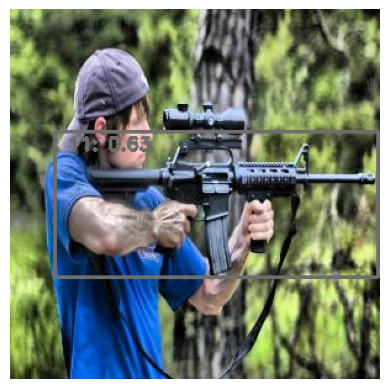

0.40


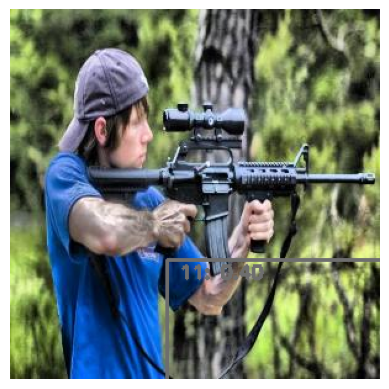

In [142]:
# 生成检测框图像
image_with_boxes = draw_boxes(image, outputs, class_range)

# 显示图像
plt.imshow(cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

image_with_boxes = draw_boxes(image, outputs_adv, class_range)

plt.imshow(cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()


0: 640x640 2 cars, 1 person, 1 traffic_cone, 9.5ms
Speed: 2.1ms preprocess, 9.5ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 bus, 1 car, 1 person, 1 traffic_cone, 7.5ms
Speed: 1.2ms preprocess, 7.5ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 bus, 1 car, 1 person, 1 traffic_cone, 9.5ms
Speed: 1.2ms preprocess, 9.5ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 bus, 1 car, 1 person, 1 traffic_cone, 9.7ms
Speed: 1.2ms preprocess, 9.7ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 bus, 1 car, 1 person, 1 traffic_cone, 9.4ms
Speed: 1.2ms preprocess, 9.4ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 bus, 1 car, 1 person, 1 traffic_cone, 9.5ms
Speed: 1.2ms preprocess, 9.5ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 bus, 1 car, 1 person, 1 traffic_cone, 9.4ms
Speed: 1.2ms preprocess,

Generating adversarial examples...



0: 640x640 1 bus, 1 car, 1 person, 1 traffic_cone, 9.5ms
Speed: 1.4ms preprocess, 9.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 bus, 1 car, 1 person, 1 traffic_cone, 9.4ms
Speed: 1.3ms preprocess, 9.4ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 bus, 1 car, 1 person, 1 traffic_cone, 9.5ms
Speed: 1.2ms preprocess, 9.5ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 bus, 1 car, 1 person, 1 traffic_cone, 9.4ms
Speed: 1.2ms preprocess, 9.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 bus, 1 car, 1 person, 1 traffic_cone, 9.5ms
Speed: 1.2ms preprocess, 9.5ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 bus, 1 car, 1 person, 1 traffic_cone, 9.4ms
Speed: 1.2ms preprocess, 9.4ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 bus, 1 car, 1 person, 1 traffic_cone, 10.5ms
Speed: 1.3ms prep

0.68
0.58
0.49
0.48


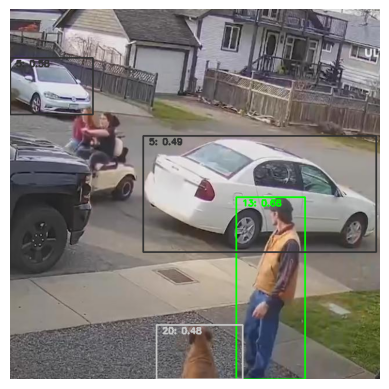

0.55
0.53
0.50
0.37


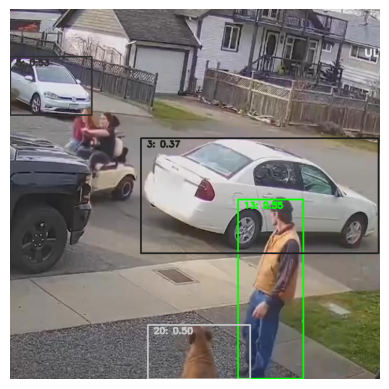

In [146]:
image_path = '/content/drive/My Drive/2024 Fall/COMS 6730/Projects/Person-Detection-YOLOV8N-Dectection/test/images/544_png.rf.098d916b42a360d14b7b85d67ec18663.jpg'
image = cv2.imread(image_path)

outputs = model(image)

# 将图像和标签转换为 Tensor
# images = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0).to(device) / 255.0
# labels = torch.tensor([0]).to(device)
images = preprocess_image(image, size=(640, 640))

# 生成对抗样本
print("Generating adversarial examples...")
images_adv = pgd_attack(model, images, epsilon, alpha, num_iter)

# 使用对抗样本进行预测
outputs_adv = model(images_adv)

# 生成检测框图像
image_with_boxes = draw_boxes(image, outputs, class_range)

# 显示图像
plt.imshow(cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

image_with_boxes = draw_boxes(image, outputs_adv, class_range)

plt.imshow(cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()